# Code 5: Splines

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [4]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
from patsy import bs, dmatrix

from scripts.splines import splines

In [5]:
az.style.use('arviz-grayscale')
plt.rcParams["figure.dpi"] = 300
np.random.seed(435)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0),
            (0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 0.5),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 0.5),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 0.5),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 0.5),
            (0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 0.3),
            (0.1843137254901961, 0.4196078431372549, 0.5568627450980392, 0.3),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 0.3),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 0.3)]

## Polynomial Regression

### Figure 5.1

In [6]:
x = np.random.normal(0.5, 1, 50)
y = np.random.normal(x**2, 1)

/tmp/ipykernel_2715/2509635768.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0X" (-> color=(0.0, 0.0, 0.0, 1.0)). The keyword argument will take precedence.
  ax.plot(x[0], y[0], 'C0X', color="C4")
/tmp/ipykernel_2715/2509635768.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0X" (-> color=(0.0, 0.0, 0.0, 1.0)). The keyword argument will take precedence.
  ax.plot(x[0], y[0], 'C0X', color="C4")
/tmp/ipykernel_2715/2509635768.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0X" (-> color=(0.0, 0.0, 0.0, 1.0)). The keyword argument will take precedence.
  ax.plot(x[0], y[0], 'C0X', color="C4")


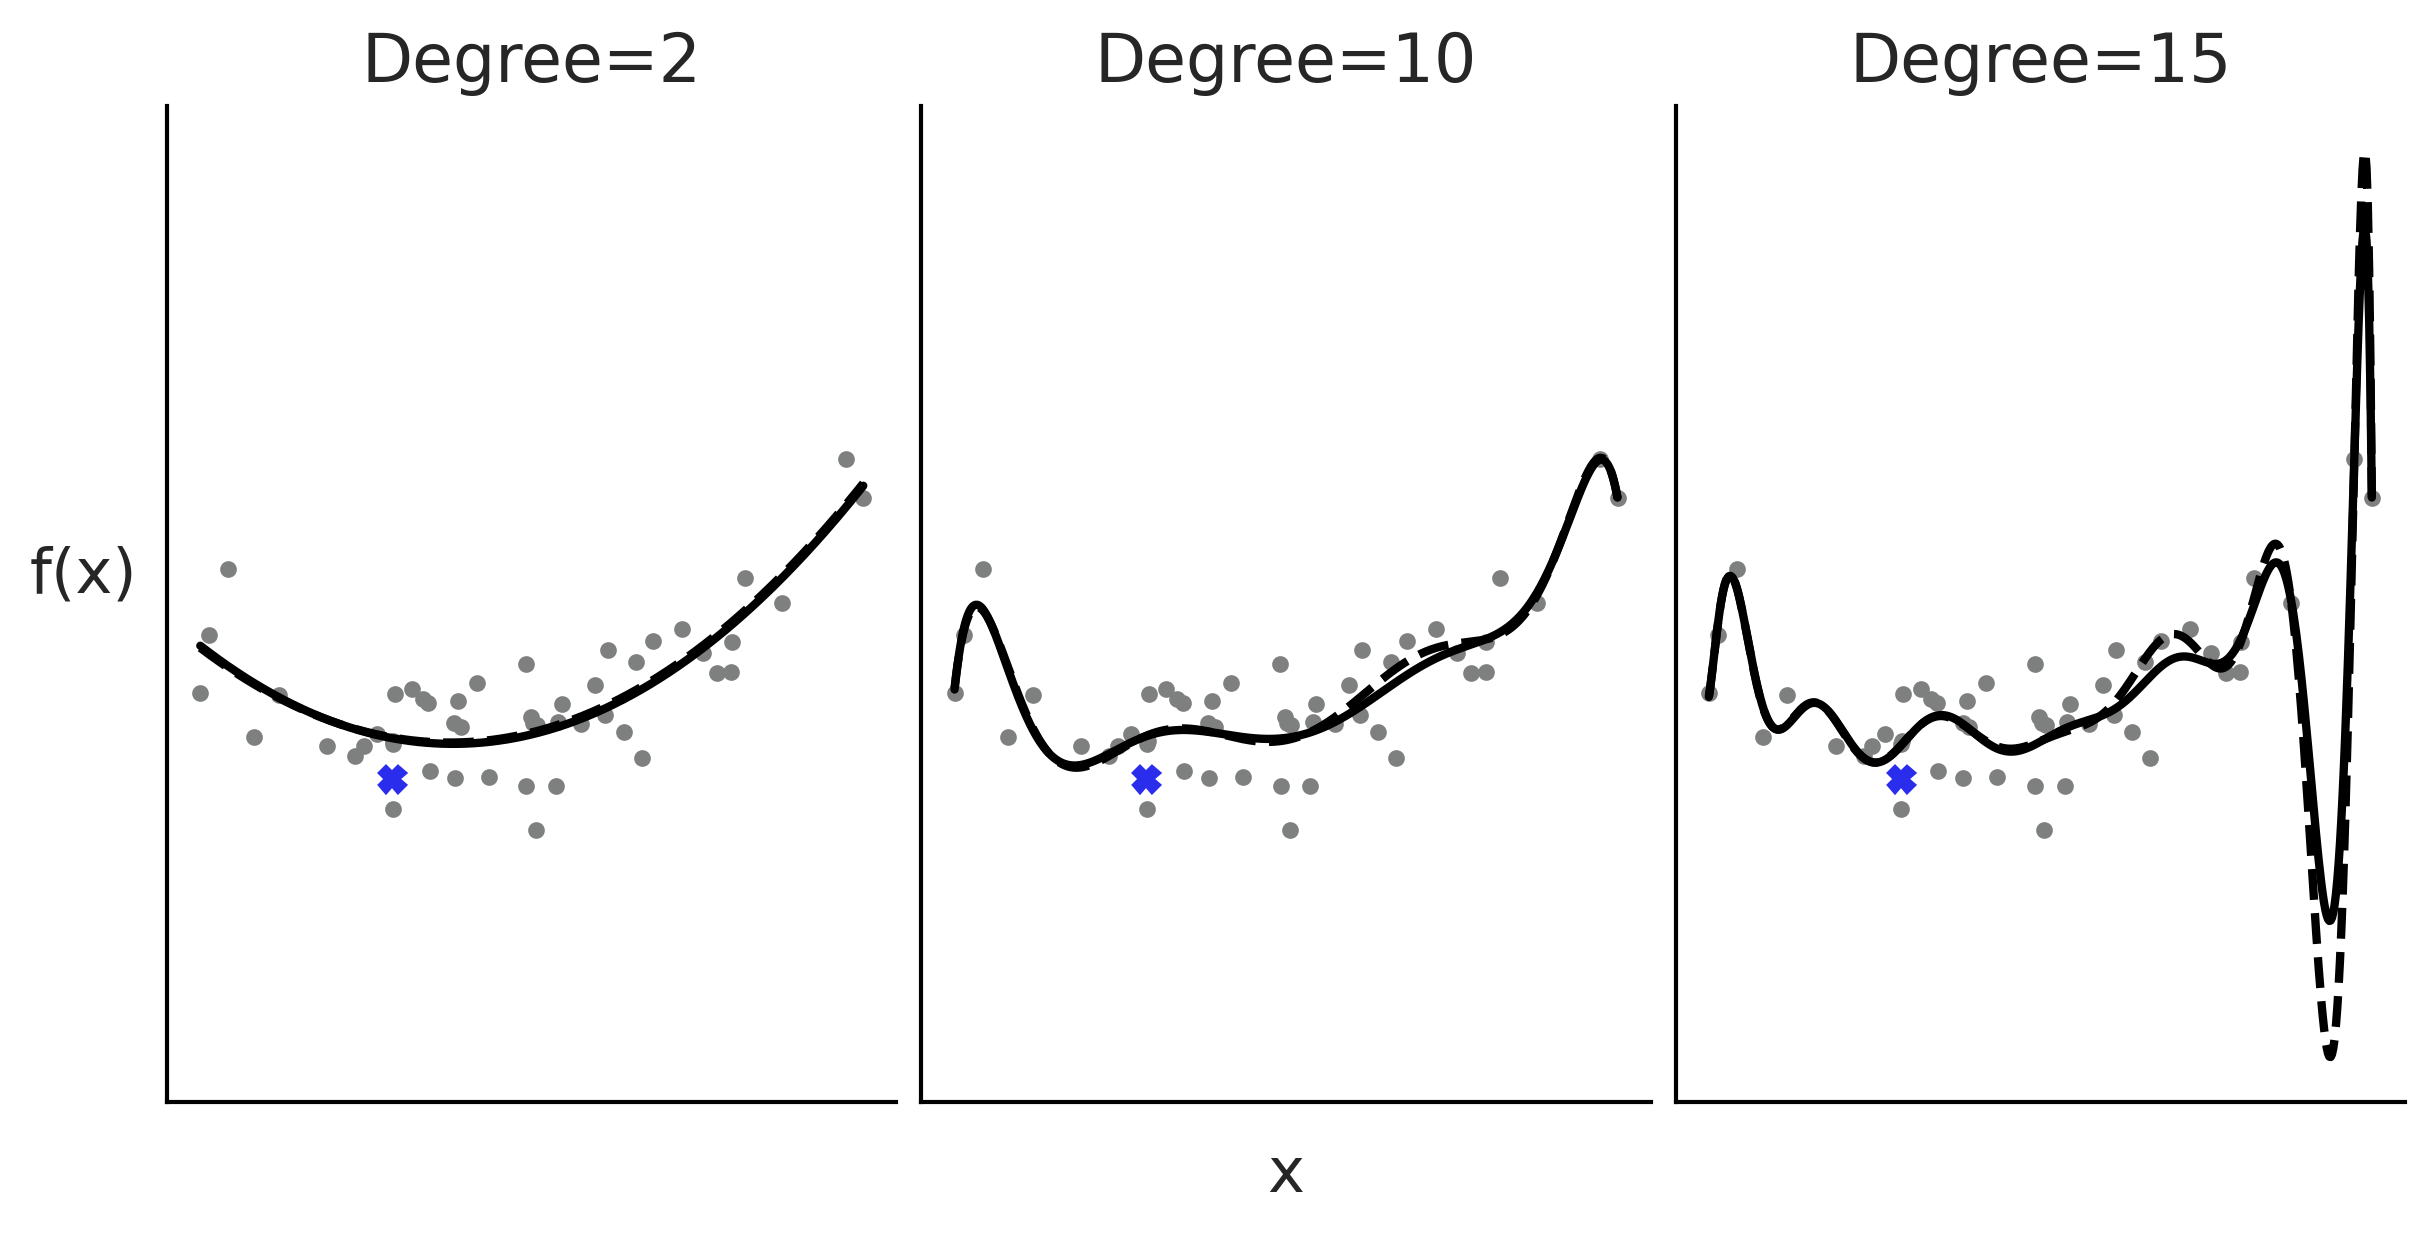

In [7]:
x_ = np.linspace(x.min(), x.max(), 500)


_, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

for deg, ax in zip([2, 10, 15], axes):
    ax.plot(x, y, 'C2.')
    ax.set_title(f"Degree={deg}")
    coefs = np.polyfit(x, y, deg=deg)
    ffit = np.poly1d(coefs)
    ax.plot(x_, ffit(x_), color="C0", lw=2)

    coefs = np.polyfit(x[:-1], y[:-1], deg=deg)
    ffit = np.poly1d(coefs)
    ax.plot(x_, ffit(x_), color="C0", lw=2, ls="--")
    ax.plot(x[0], y[0], 'C0X', color="C4")


axes[1].set_xlabel("x", labelpad=10)
axes[0].set_ylabel("f(x)", rotation=0, labelpad=20)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("img/chp05/polynomial_regression.png")

## Expanding the Feature Space

### Figure 5.2

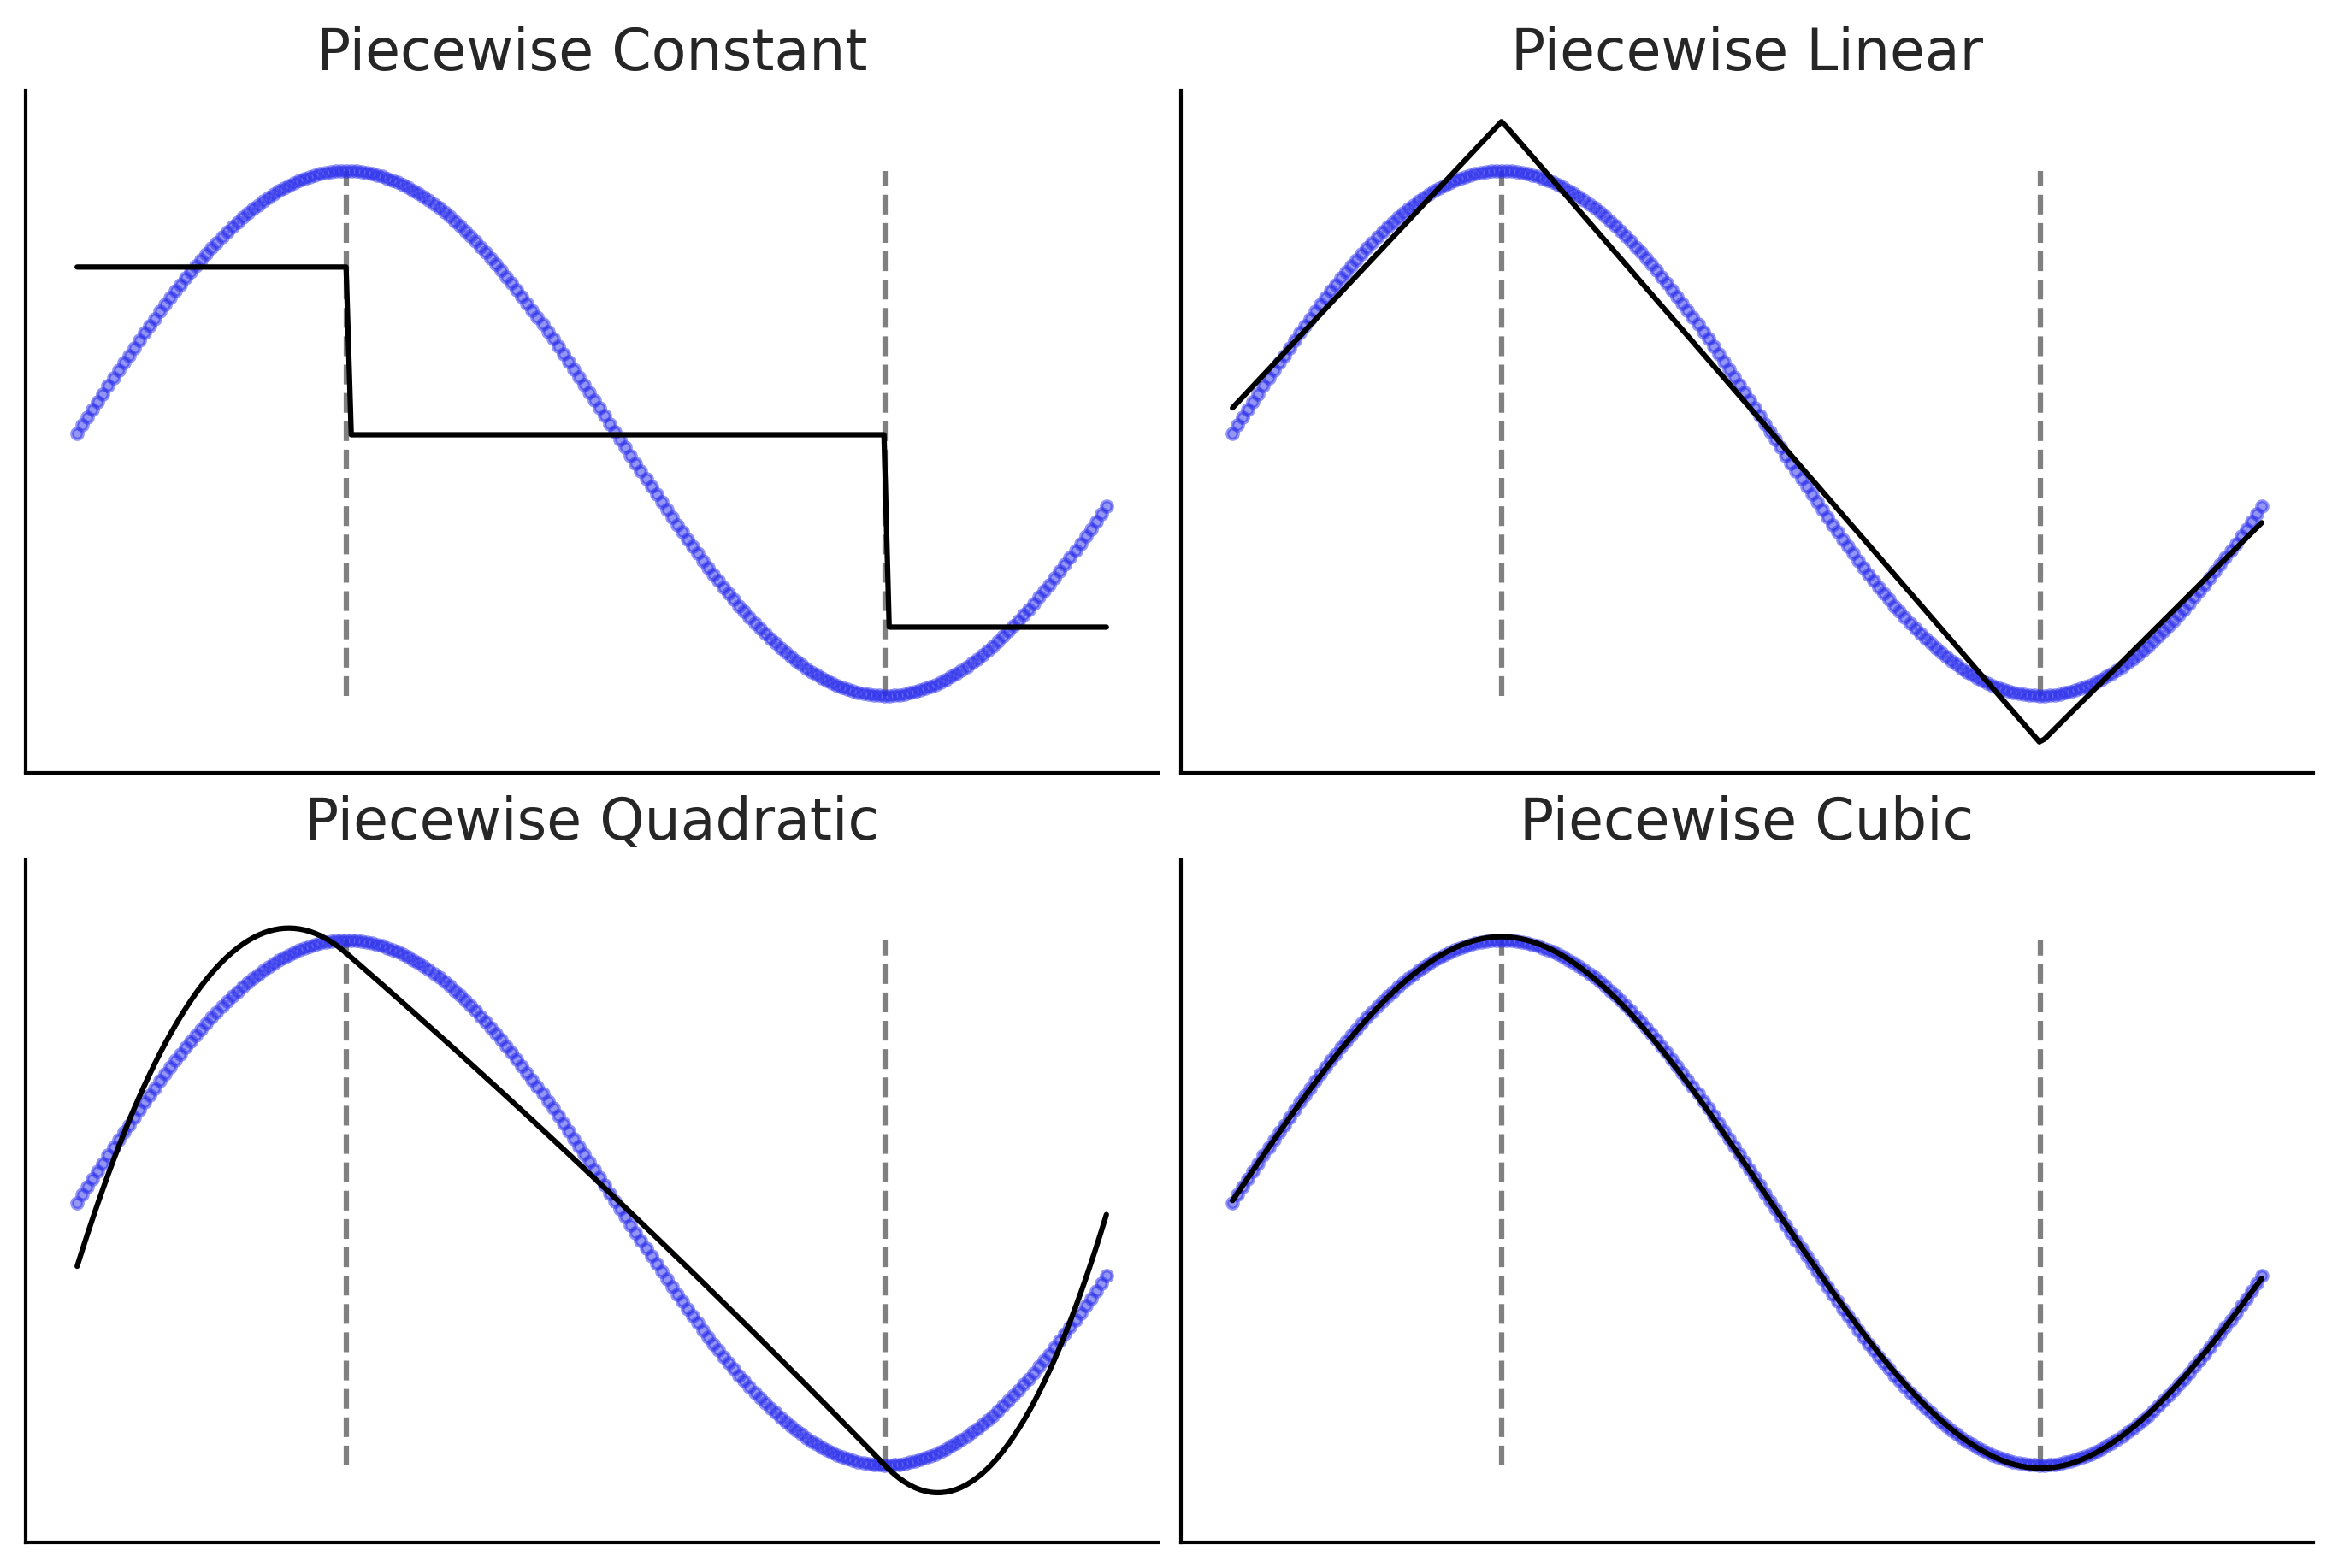

In [8]:
splines([1.57, 4.71])

## Introducing Splines

### Figure 5.3

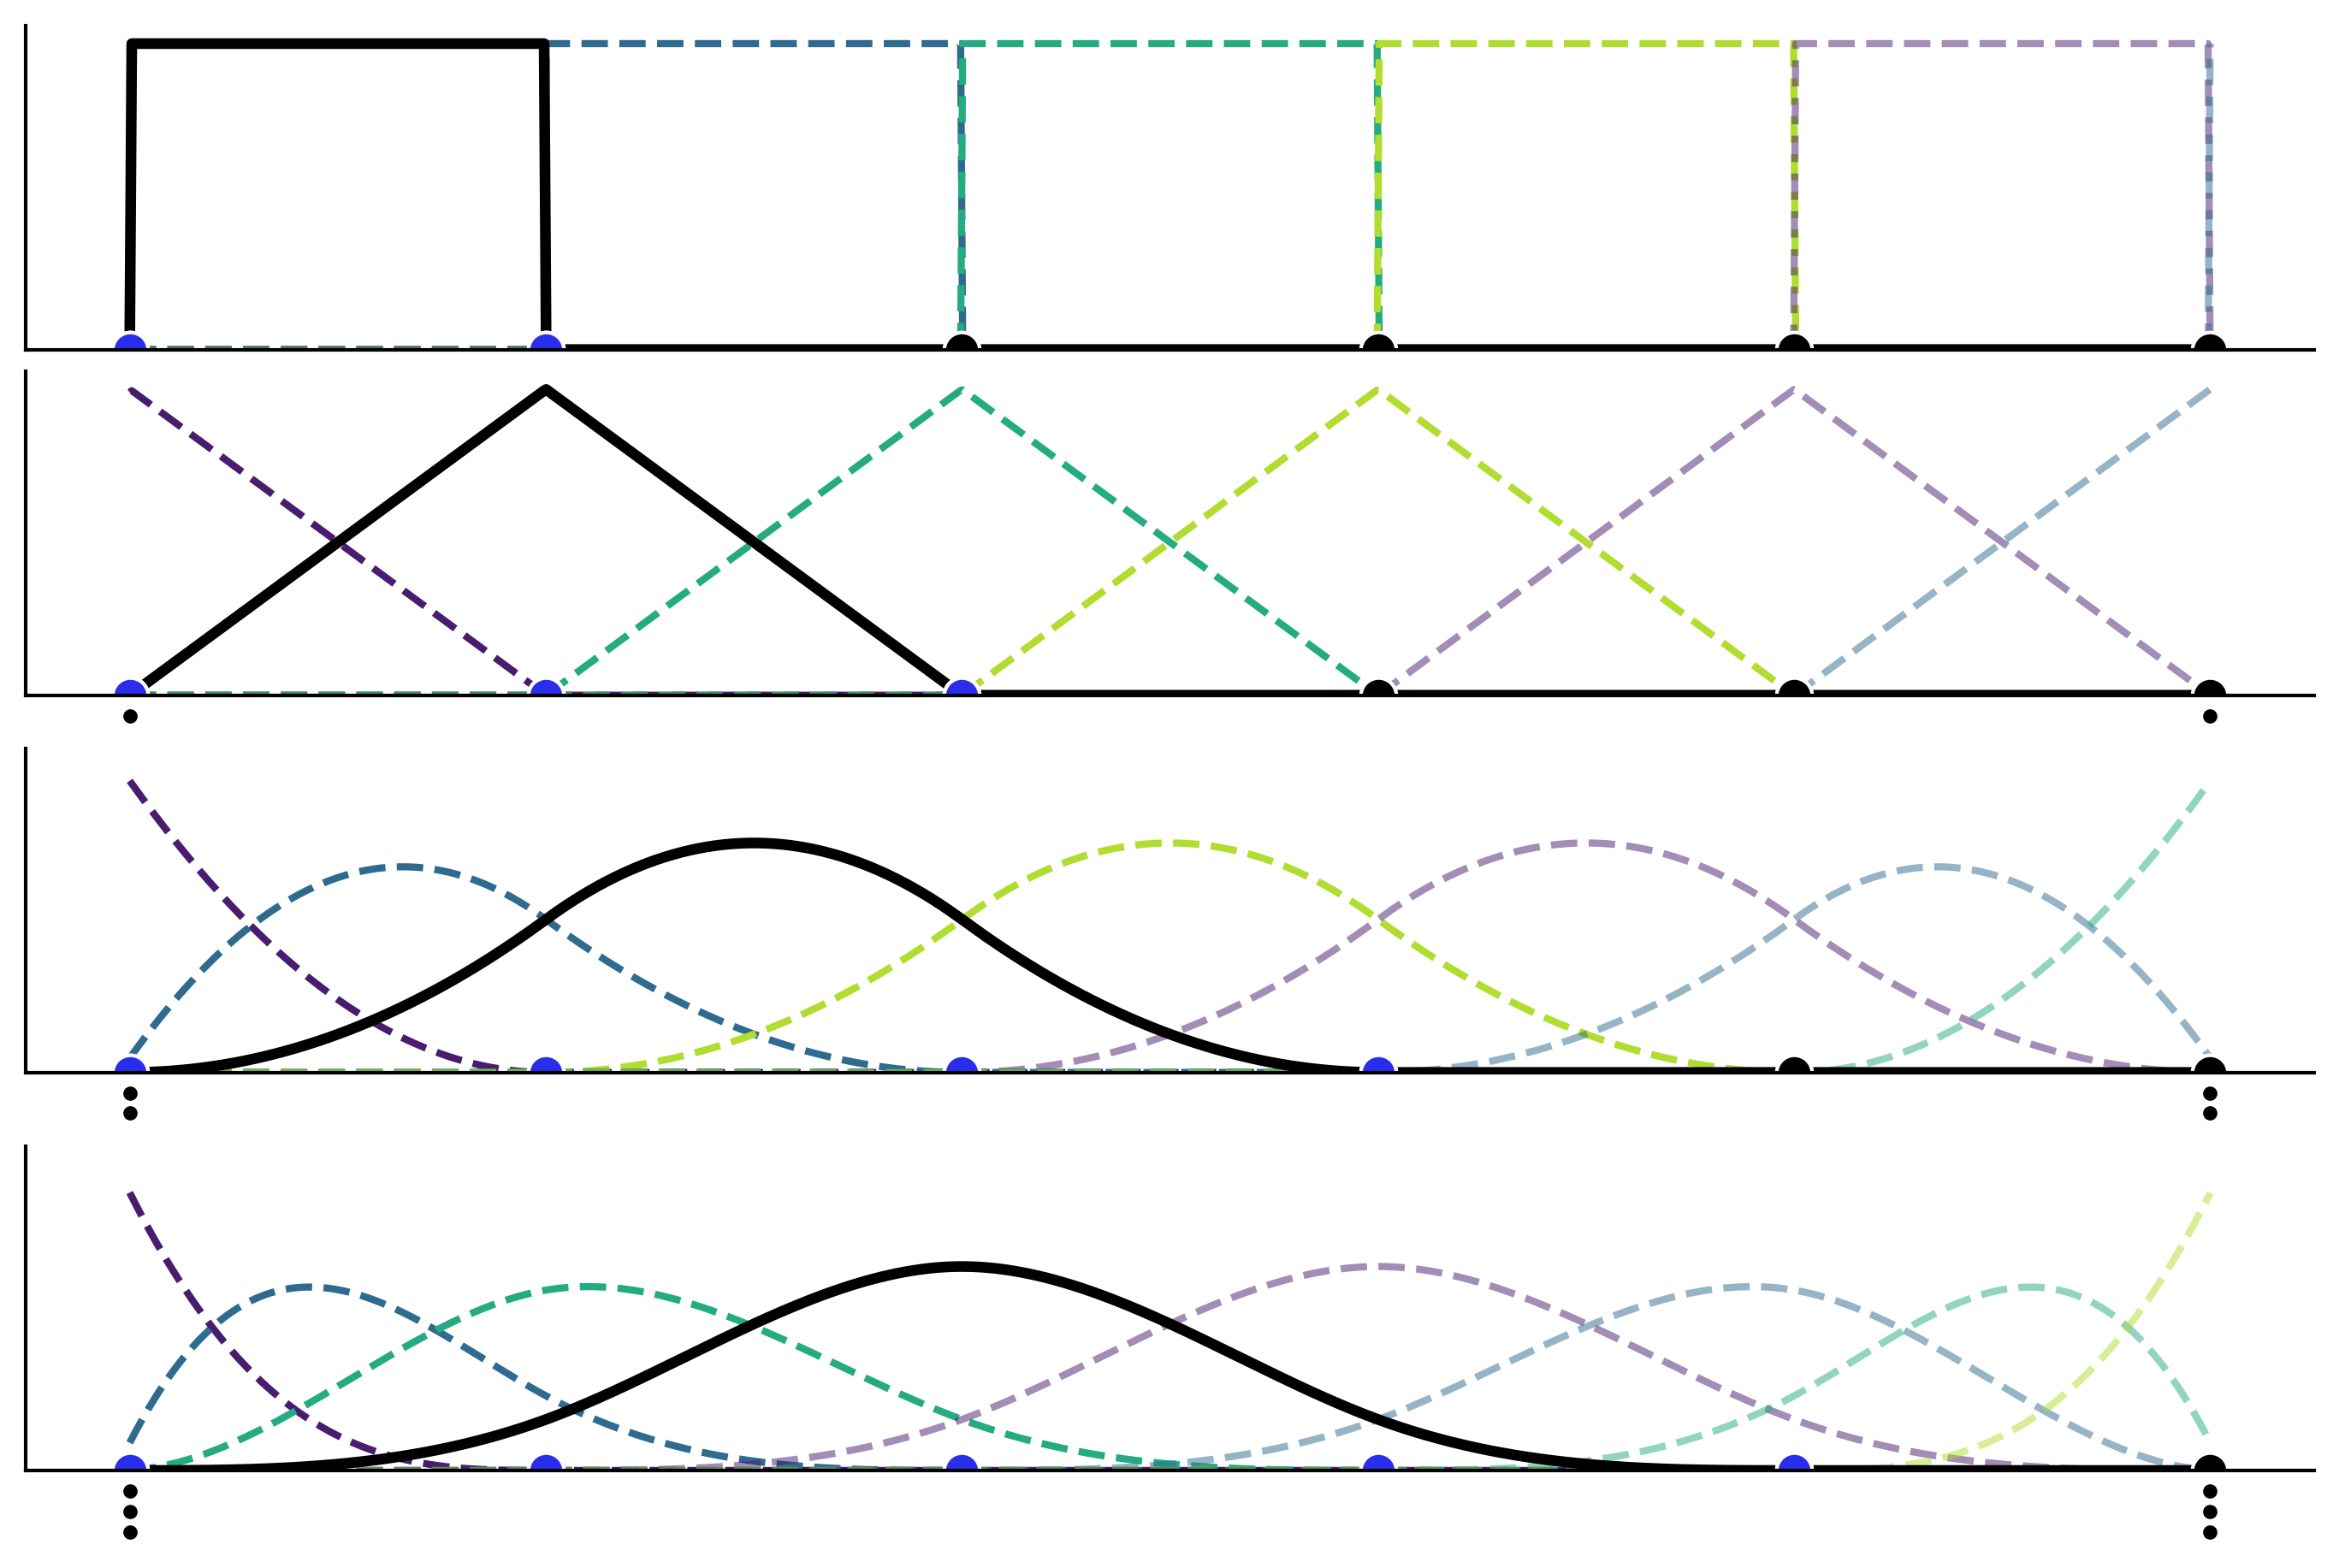

In [9]:
x = np.linspace(-0.0001, 1, 1000)
knots = [0, 0.2, 0.4, 0.6, 0.8, 1]

_, axes = plt.subplots(4, 1, figsize=(9, 6), sharex=True, sharey=True)
for deg, ax in enumerate(axes):
    b_splines = bs(x, degree=deg, knots=knots, lower_bound=-0.01, upper_bound=1.01)
    for enu, b_s in enumerate(b_splines.T):
        ax.plot(x, b_s, color=viridish[enu], lw=2, ls="--")
    ax.plot(x, b_splines[:,deg], lw=3)
    ax.plot(knots, np.zeros_like(knots), "ko", mec="w", ms=10)
    for i in range(1, deg+1):
        ax.plot([0, 1], np.array([0, 0])-(i/15), "k.", clip_on=False)
    ax.plot(knots[:deg+2], np.zeros_like(knots[:deg+2]), "C4o", mec="w", ms=10)
plt.ylim(0)
plt.xticks([])
plt.yticks([]);
plt.savefig('img/chp05/splines_basis.png')

## Building the Design Matrix using Patsy

### Figure 5.4 and Code 5.1

In [10]:
x = np.linspace(0., 1., 500)
knots = [0.25, 0.5, 0.75]

B0 = dmatrix("bs(x, knots=knots, degree=0, include_intercept=True) - 1", 
             {"x": x, "knots":knots})
B1 = dmatrix("bs(x, knots=knots, degree=1, include_intercept=True) - 1",
             {"x": x, "knots":knots})
B3 = dmatrix("bs(x, knots=knots, degree=3,include_intercept=True) - 1",
             {"x": x, "knots":knots})

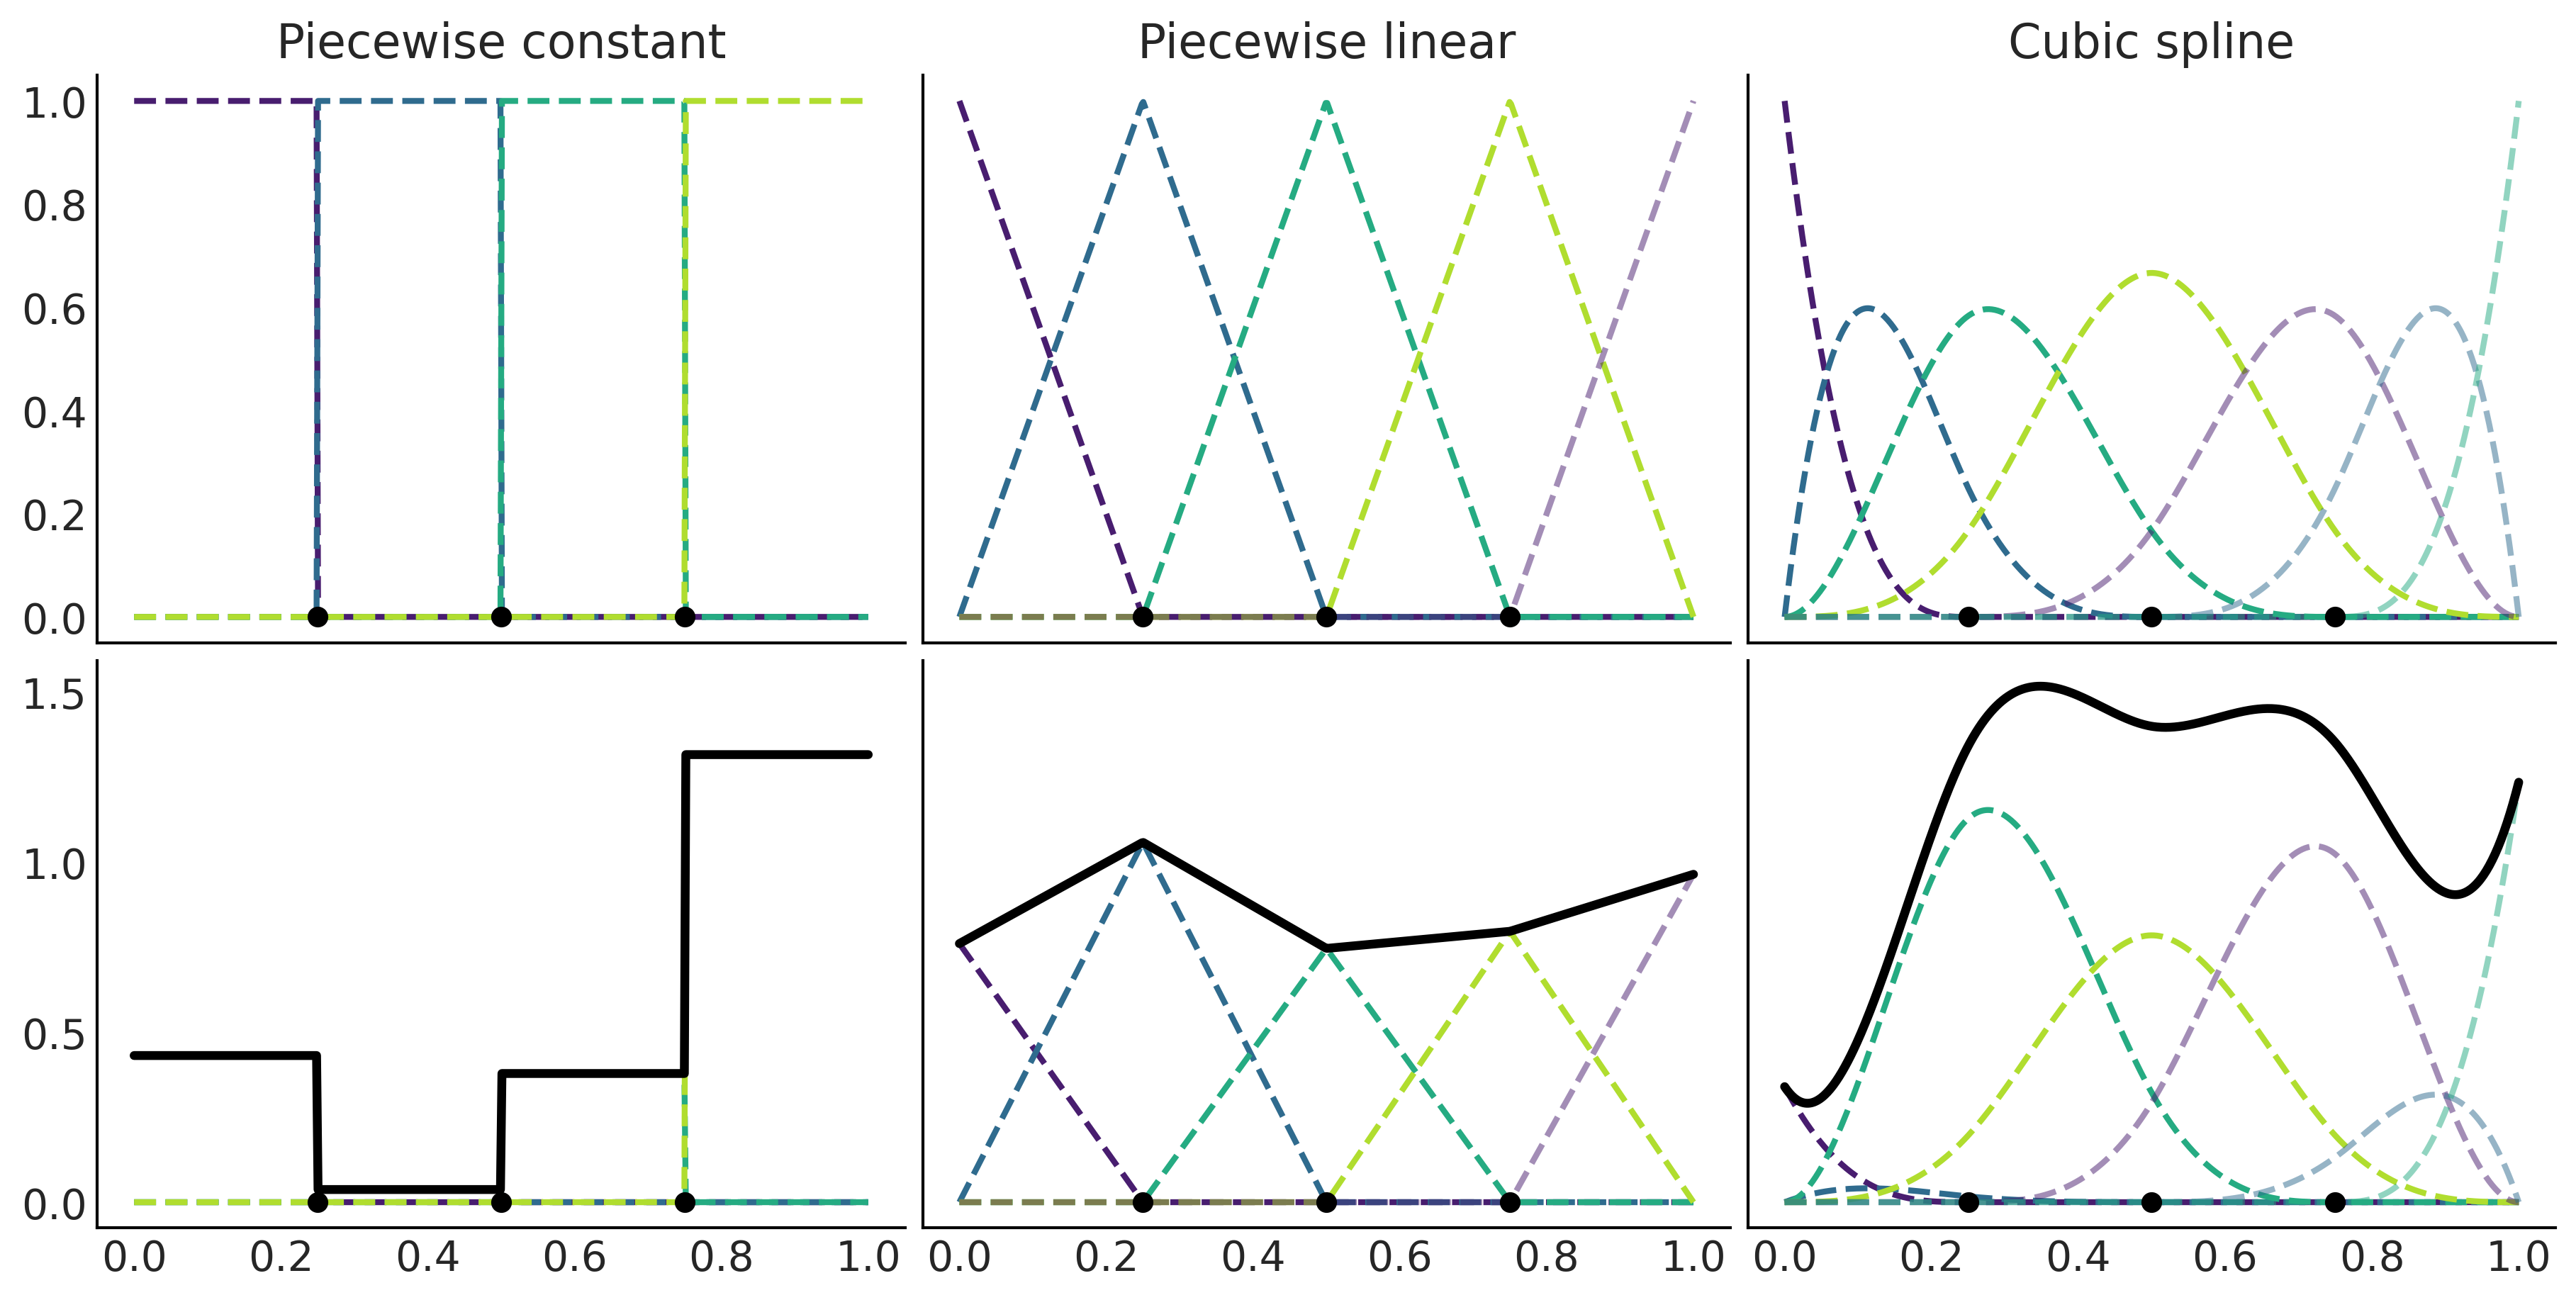

In [11]:
np.random.seed(1563)
_, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey='row')
for idx, (B, title) in enumerate(zip((B0, B1, B3),
                                     ("Piecewise constant",
                                      "Piecewise linear",
                                      "Cubic spline"))):
    # plot spline basis functions
    for i in range(B.shape[1]):
        axes[0, idx].plot(x, B[:, i],
                          color=viridish[i], lw=2, ls="--")
    # we generate some positive random coefficients 
    # there is nothing wrong with negative values
    β = np.abs(np.random.normal(0, 1, size=B.shape[1]))
    # plot spline basis functions scaled by its β
    for i in range(B.shape[1]):
        axes[1, idx].plot(x, B[:, i]*β[i],
                          color=viridish[i], lw=2, ls="--")
    # plot the sum of the basis functions
    axes[1, idx].plot(x, np.dot(B, β), color='k', lw=3)
    # plot the knots
    axes[0, idx].plot(knots, np.zeros_like(knots), "ko")
    axes[1, idx].plot(knots, np.zeros_like(knots), "ko")
    axes[0, idx].set_title(title)

plt.savefig('img/chp05/splines_weighted.png')

### Figure 5.5

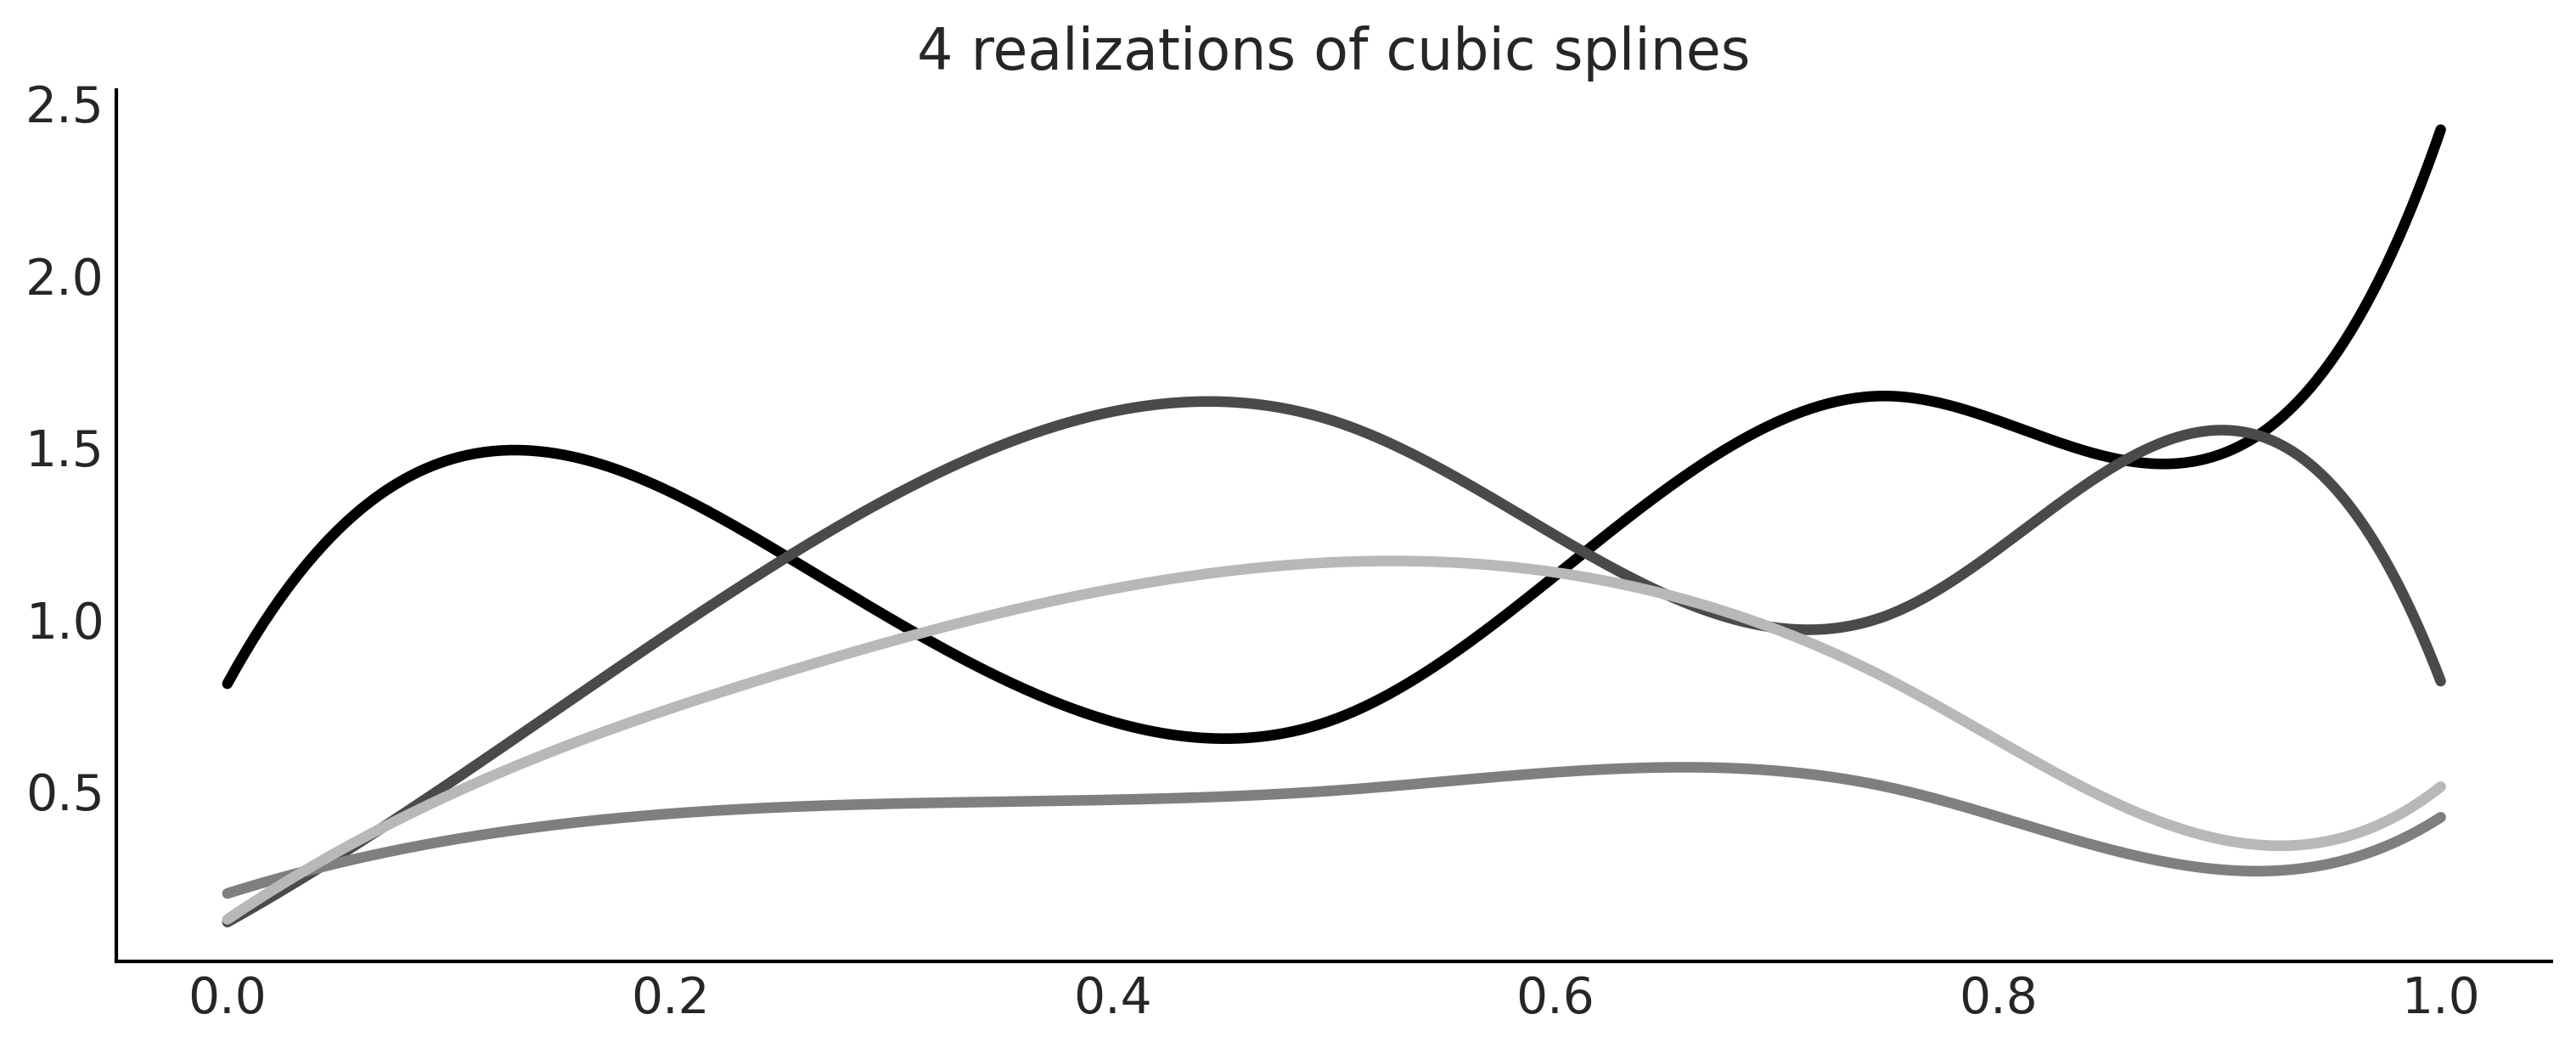

In [12]:
_, axes = plt.subplots(1, 1, figsize=(10, 4))

for i in range(4):
    β = np.abs(np.random.normal(0, 1, size=B.shape[1]))
    axes.plot(x, np.dot(B, β), color=f'C{i}', lw=3)
    axes.set_title("4 realizations of cubic splines")

plt.savefig('img/chp05/splines_realizations.png')

### Figure 5.6

In [13]:
x = np.linspace(0., 1., 20)
knots = [0.25, 0.5, 0.75]

B0 = dmatrix("bs(x, knots=knots, degree=0, include_intercept=True) - 1", {"x": x, "knots":knots})
B1 = dmatrix("bs(x, knots=knots, degree=1, include_intercept=True) - 1", {"x": x, "knots":knots})
B3 = dmatrix("bs(x, knots=knots, degree=3, include_intercept=True) - 1", {"x": x, "knots":knots})

### Code 5.2

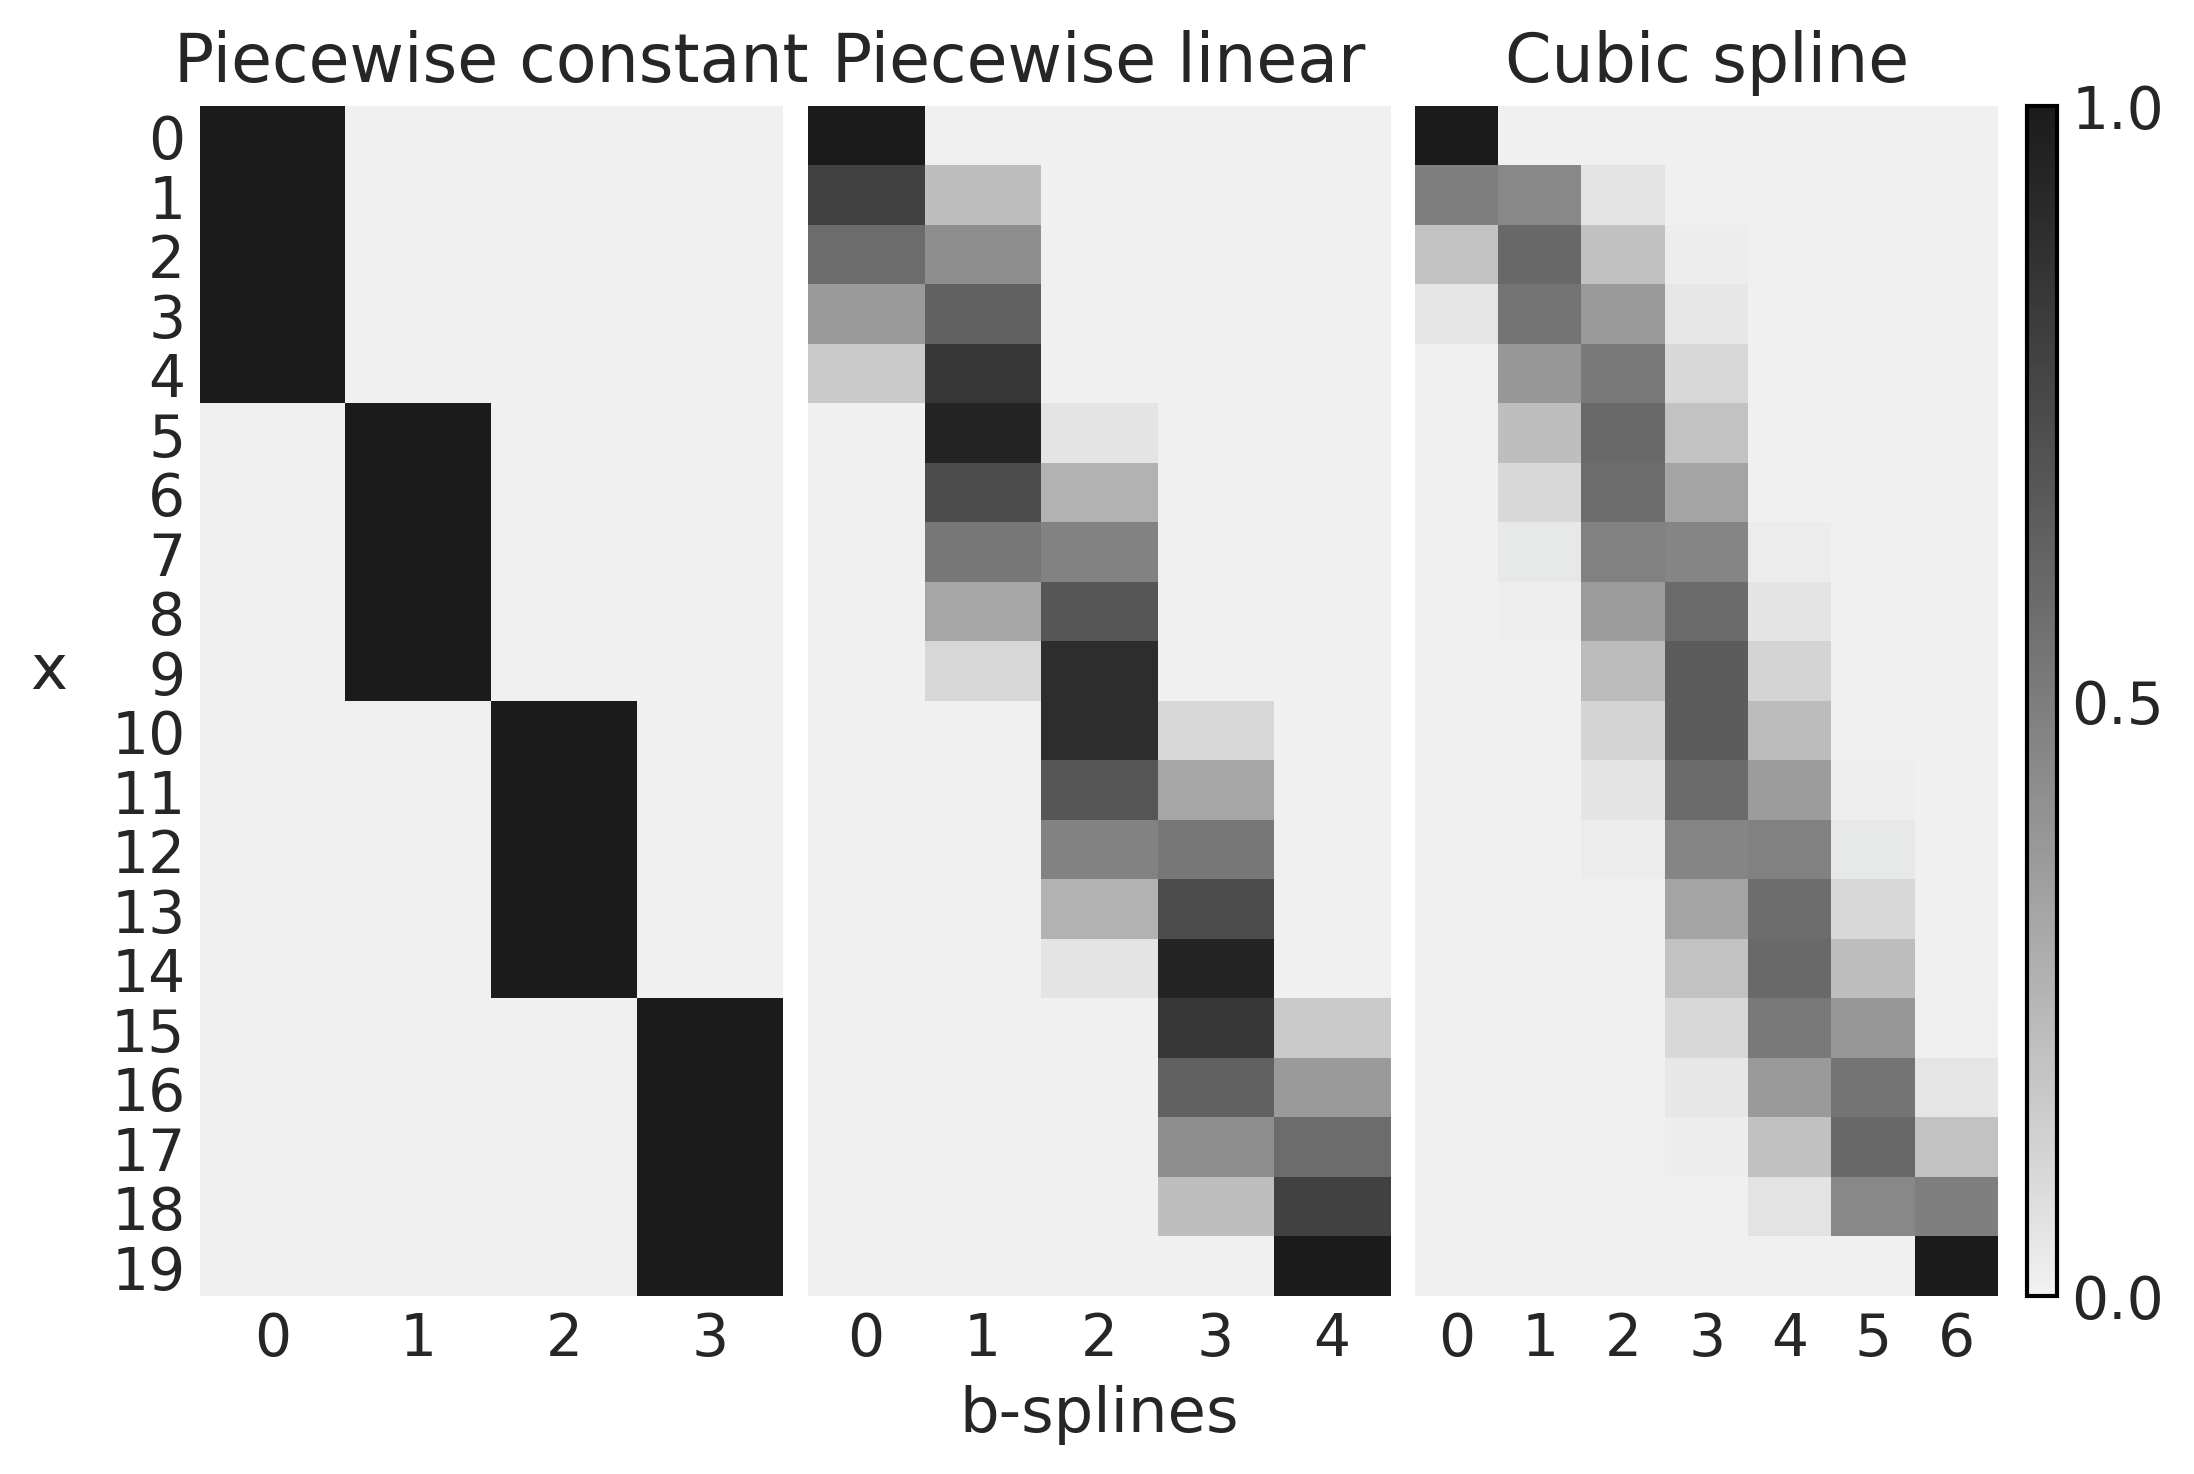

In [14]:
fig, axes = plt.subplots(1, 3, sharey=True)
for idx, (B, title, ax) in enumerate(zip((B0, B1, B3),
                                     ("Piecewise constant", 
                                      "Piecewise linear", 
                                      "Cubic spline"),
                                      axes)):
    cax = ax.imshow(B, cmap="cet_gray_r", aspect="auto")
    ax.set_xticks(np.arange(B.shape[1]))
    ax.set_yticks(np.arange(B.shape[0]))
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(title)


axes[1].set_xlabel("b-splines")
axes[0].set_ylabel("x", rotation=0, labelpad=15)
fig.colorbar(cax, aspect=40, ticks=[0, 0.5, 1])
plt.savefig('img/chp05/design_matrices.png')

## Fitting Splines in PyMC3

### Code 5.3 and Figure 5.7

In [15]:
data = pd.read_csv("../data/bikes_hour.csv")
data.sort_values(by="hour", inplace=True)

# We standardize the response variable
data_cnt_om = data["count"].mean()
data_cnt_os = data["count"].std()
data["count_normalized"] = (data["count"] - data_cnt_om) / data_cnt_os
# Remove data, you may later try to refit the model to the whole data
data = data[::50]

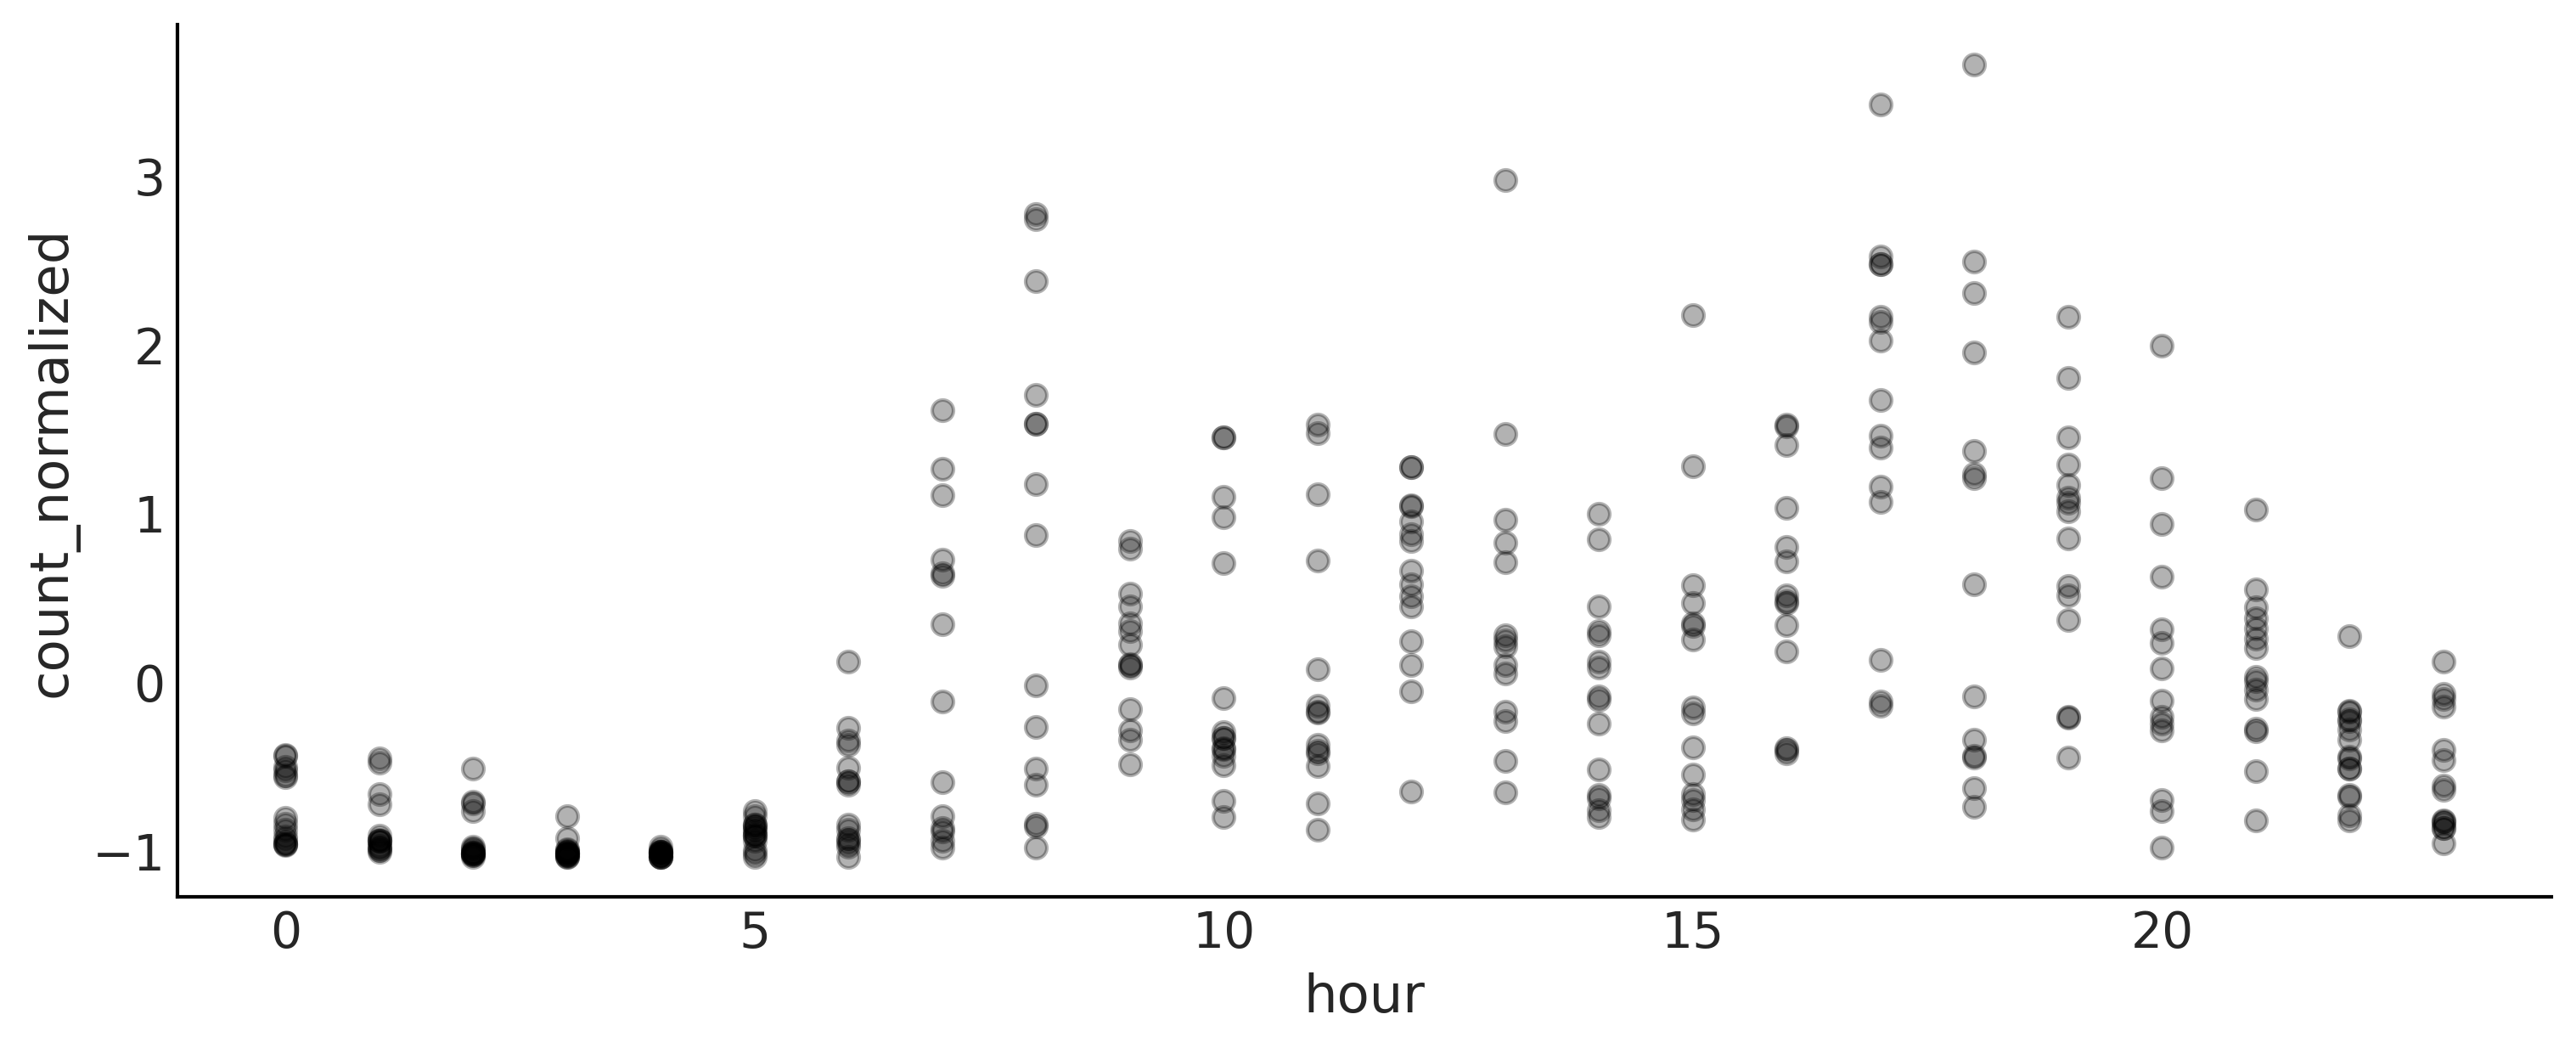

In [16]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data.hour, data.count_normalized, "o", alpha=0.3)
ax.set_xlabel("hour")
ax.set_ylabel("count_normalized")
plt.savefig('img/chp05/bikes_data.png');

### Code 5.4

In [17]:
num_knots = 6
knot_list = np.linspace(0, 23, num_knots)[1:-1]

### Code 5.5

In [18]:
B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data.hour.values, "knots": knot_list},
)

### Code 5.6

In [19]:
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idata_s = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


### Figure 5.8

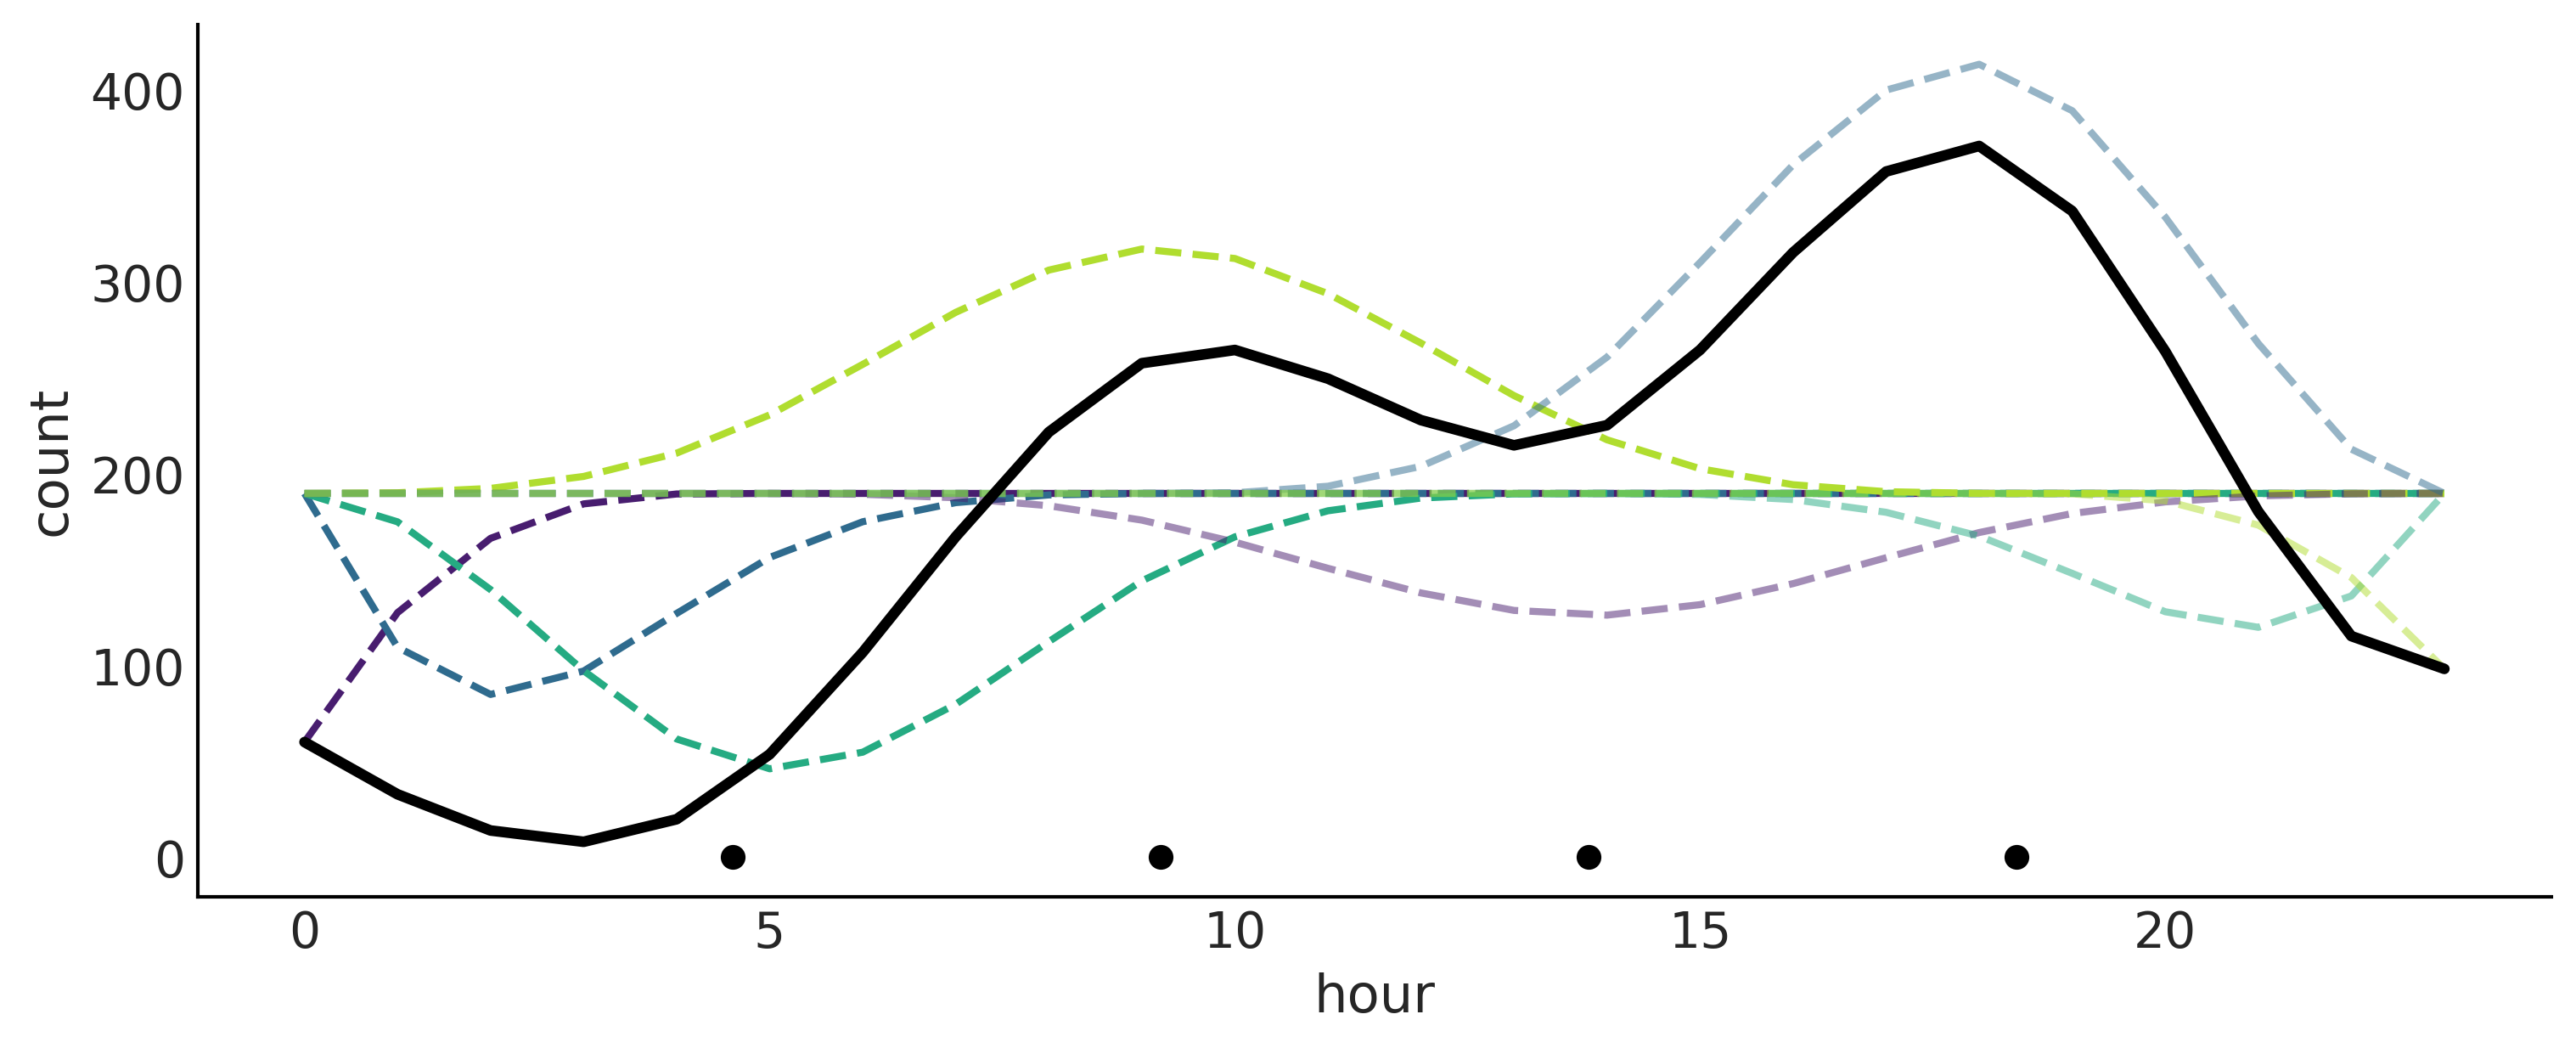

In [20]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_prop_cycle(cycler('color', viridish))
posterior = idata_s.posterior.stack(samples=['chain', 'draw'])
ax.plot(data.hour, (B*posterior["β"].mean("samples").values * data_cnt_os) + data_cnt_om, lw=2, ls='--')
ax.plot(data.hour, posterior["μ"].mean("samples") * data_cnt_os + data_cnt_om, 'k', lw=3)
ax.set_xlabel("hour")
ax.set_ylabel("count")
ax.plot(knot_list, np.zeros_like(knot_list), 'ko')
plt.savefig("img/chp05/bikes_spline_raw_data.png")

### Figure 5.9

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


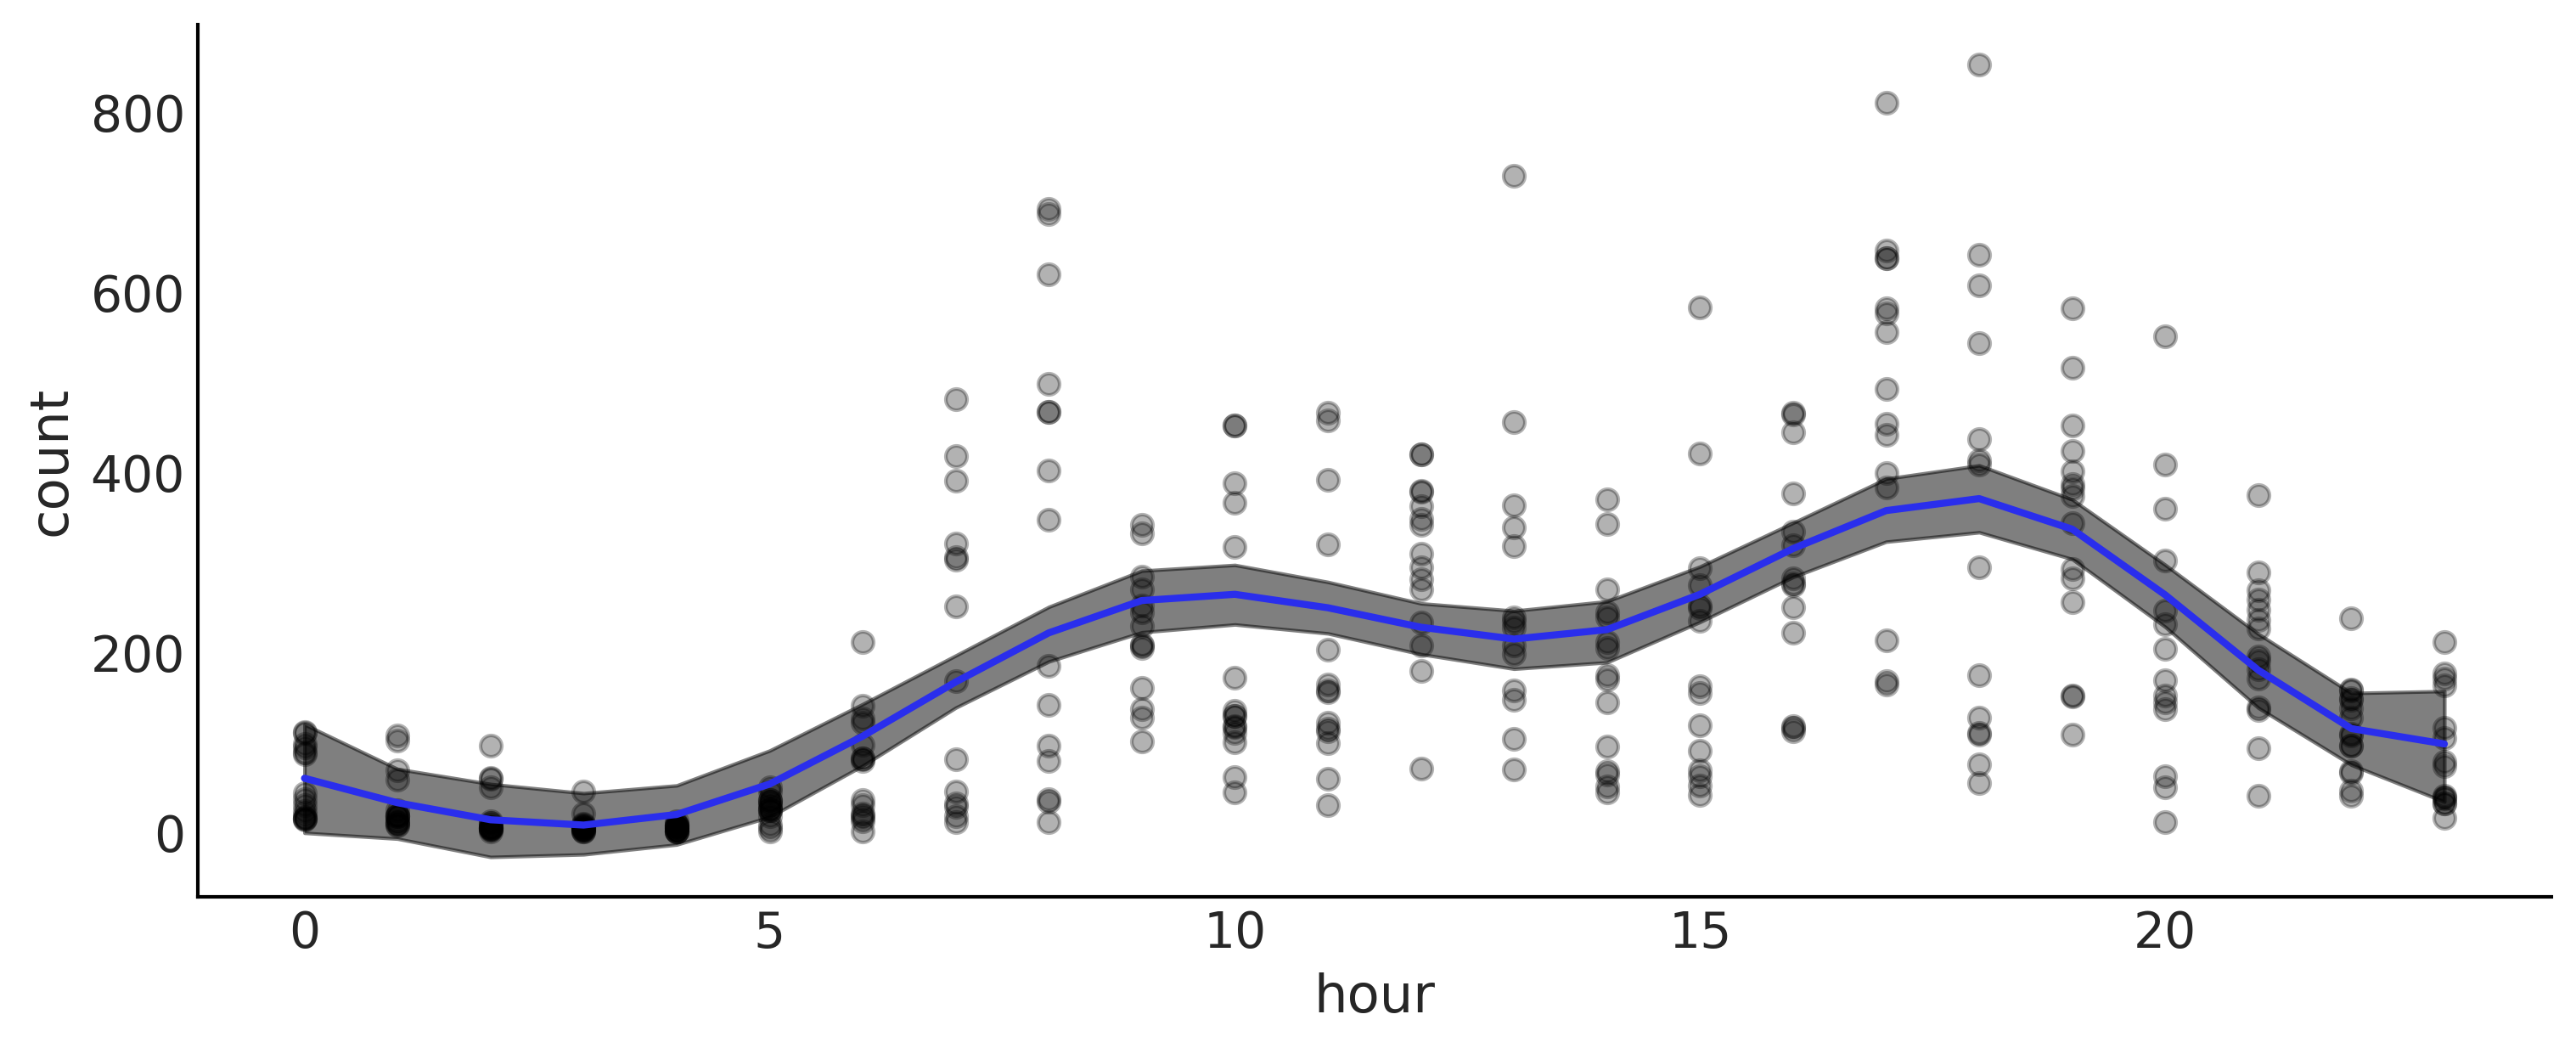

In [21]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(data.hour, data["count"], "o", alpha=0.3, zorder=-1)
# we use data_cnt_os and data_cnt_om to rescale the cnt data and results
ax.plot(data.hour, (posterior["μ"].mean("samples")  * data_cnt_os) + data_cnt_om, color="C4", lw=2)
az.plot_hdi(data.hour, (posterior["μ"].T  * data_cnt_os) + data_cnt_om,
            color="C0", smooth=False)
ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig("img/chp05/bikes_spline_data.png")

## Choosing Knots and Prior for Splines

### Table 5.1 and Figure 5.10

In [22]:
Bs = []

num_knots = (3, 6, 9, 12, 18)
for nk in num_knots:
    knot_list = np.linspace(0, 24, nk+2)[1:-1]
    B = dmatrix(
        "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
        {"cnt": data.hour.values, "knots": knot_list},
    )
    Bs.append(B)

In [23]:
idatas = []
for B in Bs:
    with pm.Model() as splines:
        τ = pm.HalfCauchy('τ', 1) 
        β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
        μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
        σ = pm.HalfNormal("σ", 1)
        c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
        idata = pm.sample(1000, return_inferencedata=True)
        idatas.append(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [24]:
dict_cmp = {f"m_{k}k":v for k,v in zip(num_knots, idatas)}
cmp = az.compare(dict_cmp)
cmp.round(2)

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank     loo  p_loo  d_loo  weight     se   dse  warning loo_scale
m_12k     0 -377.46  14.02   0.00    0.88  17.91  0.00    False       log
m_18k     1 -379.82  17.65   2.37    0.00  17.86  1.59    False       log
m_9k      2 -380.55  11.48   3.10    0.00  18.14  3.01    False       log
m_6k      3 -389.28   9.18  11.83    0.00  18.05  5.70    False       log
m_3k      4 -400.09   7.04  22.63    0.12  17.98  7.77    False       log

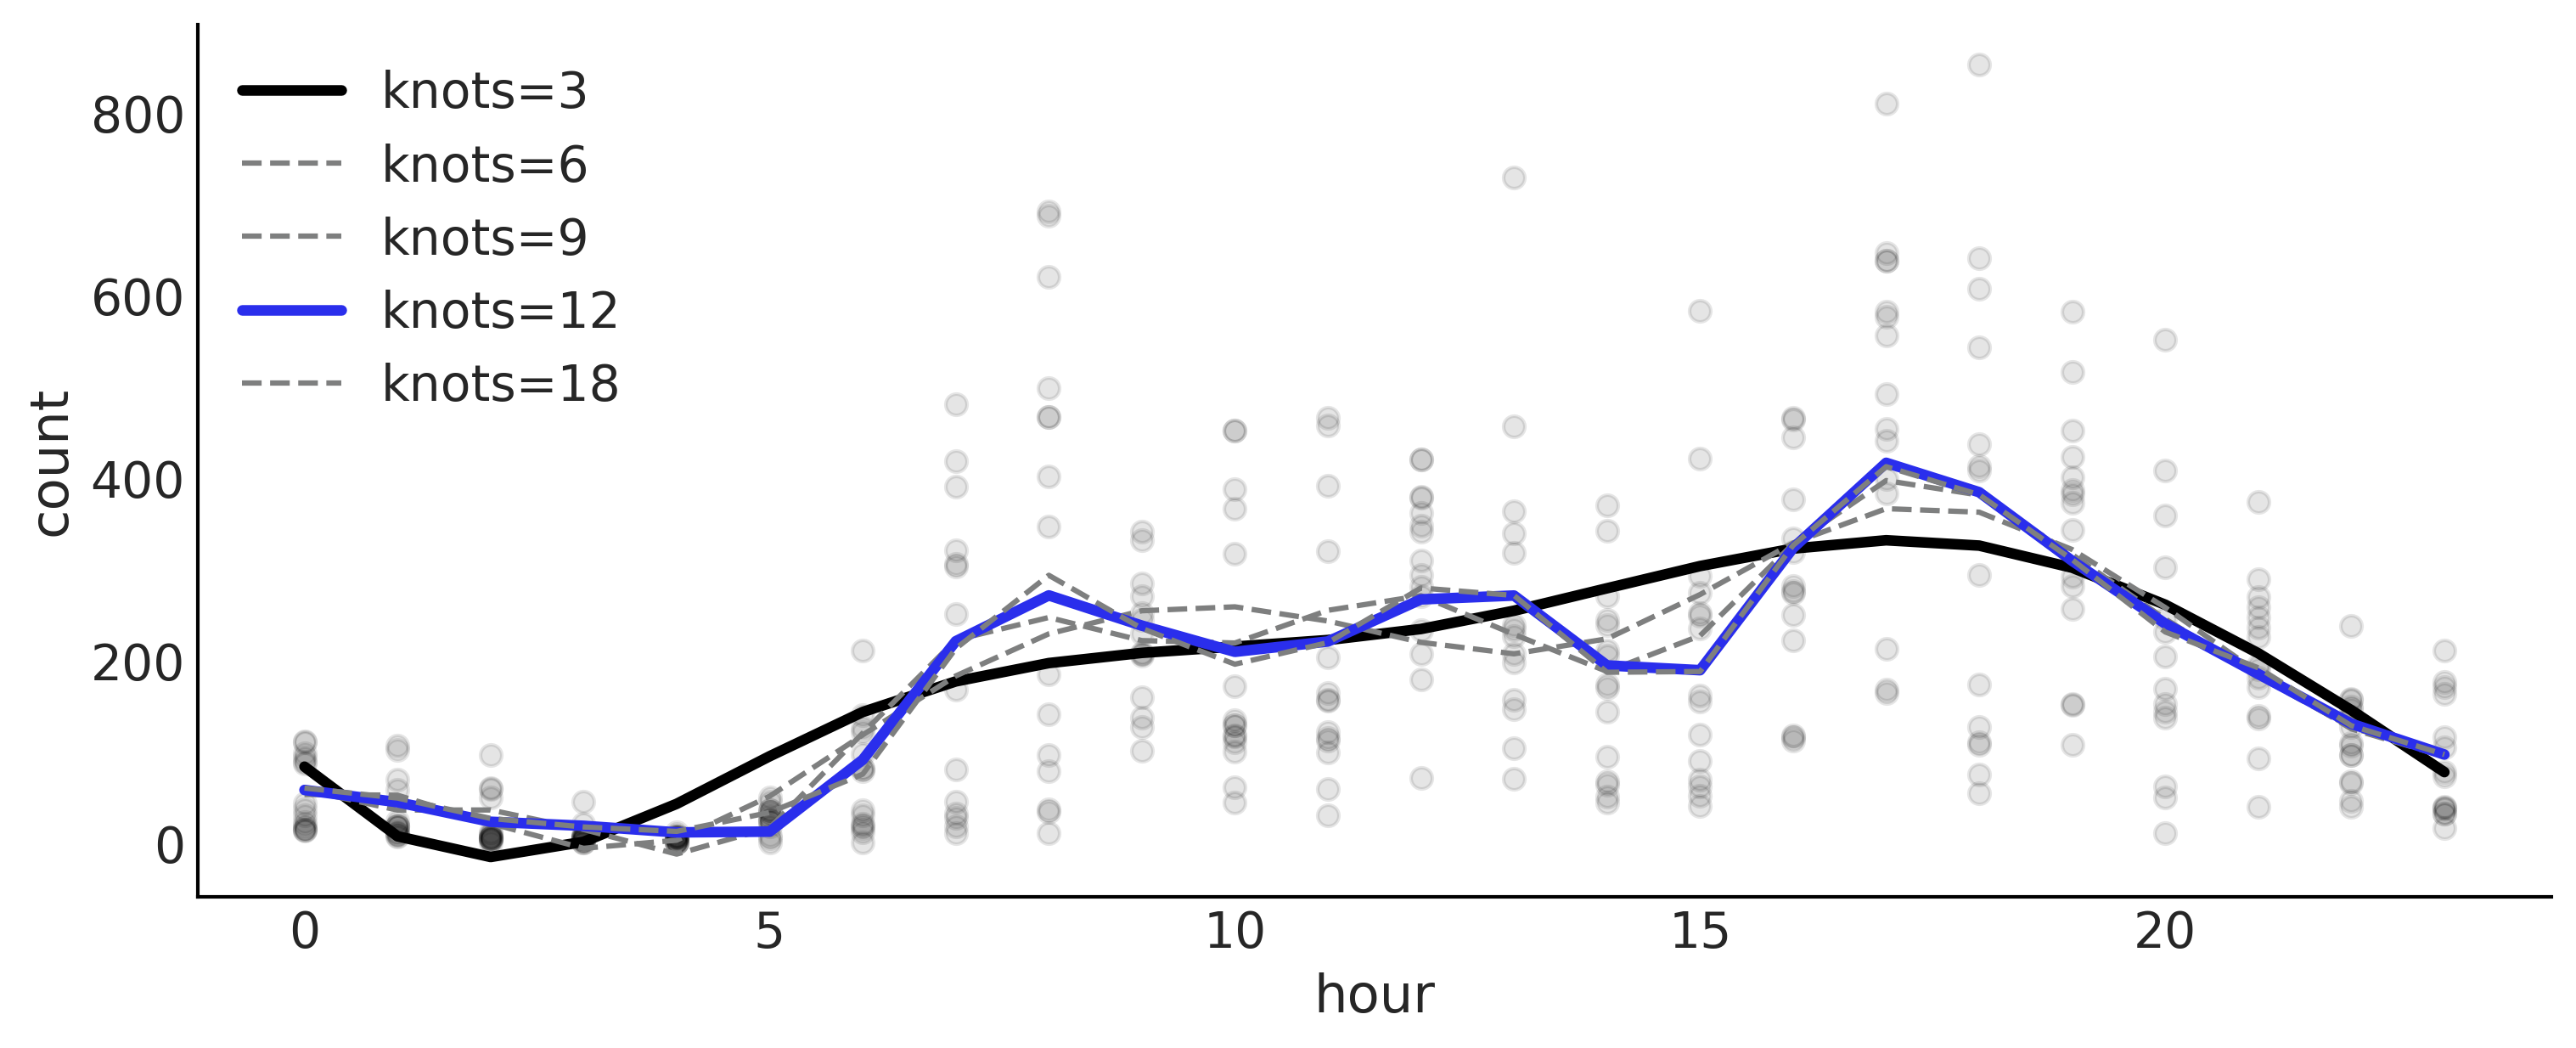

In [25]:
_, ax = plt.subplots(figsize=(10, 4))
ax.plot(data.hour, data["count"], "o", alpha=0.1, zorder=-1)

for idx, (idata, i, ls, lw) in enumerate(zip(idatas, (0,2,2,4,2), ("-","--","--","-","--"), (3,1.5,1.5,3,1.5))):
    mean_f = idata.posterior["μ"].mean(dim=['chain', 'draw'])
    ax.plot(data.hour,
            (mean_f * data_cnt_os) + data_cnt_om, color=f"C{i}",
            label=f"knots={(3, 6, 9, 12, 18)[idx]}" ,
            ls=ls, lw=lw)

plt.legend()
ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig("img/chp05/bikes_spline_loo_knots.png")

### Figure 5.11

In [26]:
knot_list = np.arange(1, 23)

In [27]:
B = dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data.hour.values, "knots": knot_list},
)

### Code 5.7

In [28]:
with pm.Model() as splines_rw:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.GaussianRandomWalk("β", mu=0, sigma=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    trace_splines_rw = pm.sample(1000)
    idata_splines_rw = az.from_pymc3(trace=trace_splines_rw,
                                 posterior_predictive=pm.sample_posterior_predictive(trace_splines_rw))

/tmp/ipykernel_2715/2940513050.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_splines_rw = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [29]:
with pm.Model() as wiggly:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    trace_wiggly = pm.sample(1000)
    idata_wiggly = az.from_pymc3(trace=trace_wiggly,
                                 posterior_predictive=pm.sample_posterior_predictive(trace_wiggly))

/tmp/ipykernel_2715/1183472520.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_wiggly = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


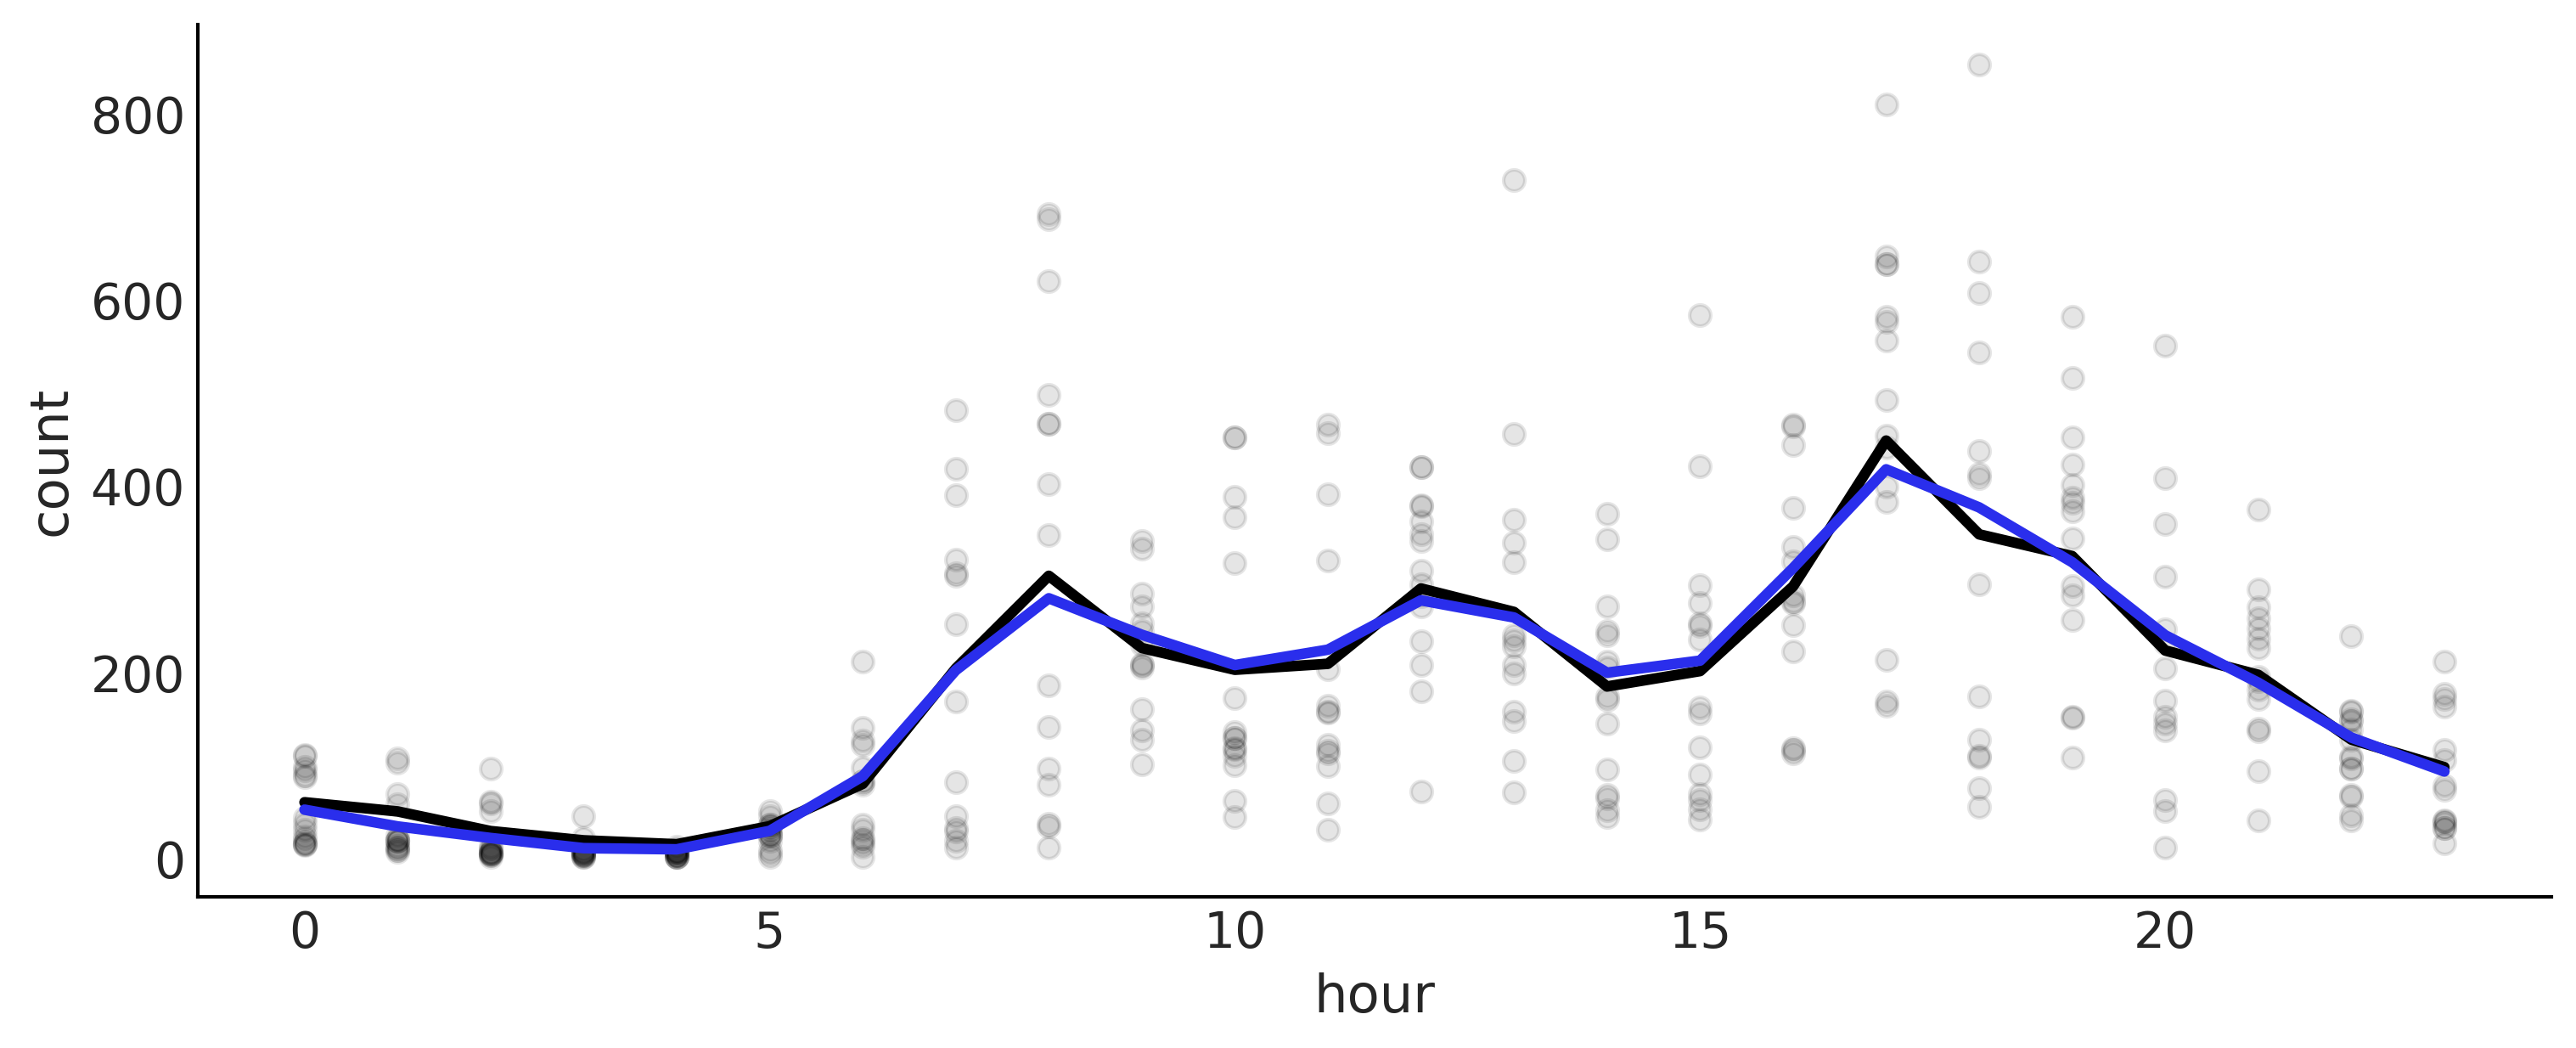

In [30]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(data.hour, data["count"], "o", alpha=0.1, zorder=-1)

wiggly_posterior = (idata_wiggly.posterior["μ"] * data_cnt_os) + data_cnt_om
mean_f = wiggly_posterior.mean(dim=['chain', 'draw'])
ax.plot(data.hour, mean_f , color="C0", lw=3)
#az.plot_hdi(data.hour, wiggly_posterior, smooth=False, color="C0")

splines_rw = (idata_splines_rw.posterior["μ"] * data_cnt_os) + data_cnt_om
mean_f = splines_rw.mean(dim=['chain', 'draw'])
ax.plot(data.hour, mean_f, color="C4", lw=3)
#az.plot_hdi(data.hour, splines_rw, smooth=False, color="C4")

ax.set_xlabel("hour")
ax.set_ylabel("count")
plt.savefig("img/chp05/bikes_spline_data_grw.png")

## Modeling CO2 Uptake with Splines

In [31]:
np.random.seed(435)

### Code 5.8

In [32]:
plants_CO2 = pd.read_csv("../data/CO2_uptake.csv")
plant_names = plants_CO2.Plant.unique()
CO2_conc = plants_CO2.conc.values[:7]
CO2_concs = plants_CO2.conc.values
uptake = plants_CO2.uptake.values
index = range(12)
groups = len(index)

### Code 5.9

In [33]:
num_knots = 2
knot_list = np.linspace(CO2_conc[0], CO2_conc[-1], num_knots+2)[1:-1]

Bg = dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_concs, "knots": knot_list},
)

### Code 5.10 and Figure 5.12

In [34]:
with pm.Model() as sp_global:
    τ = pm.HalfCauchy('τ', 1)
    β = pm.Normal("β", mu=0, sd=τ, shape=Bg.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(np.asfortranarray(Bg), β))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg, σ, observed=uptake)
    idata_sp_global = pm.sample(3000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8789287751544588, but should be close to 0.8. Try to increase the number of tuning steps.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/a

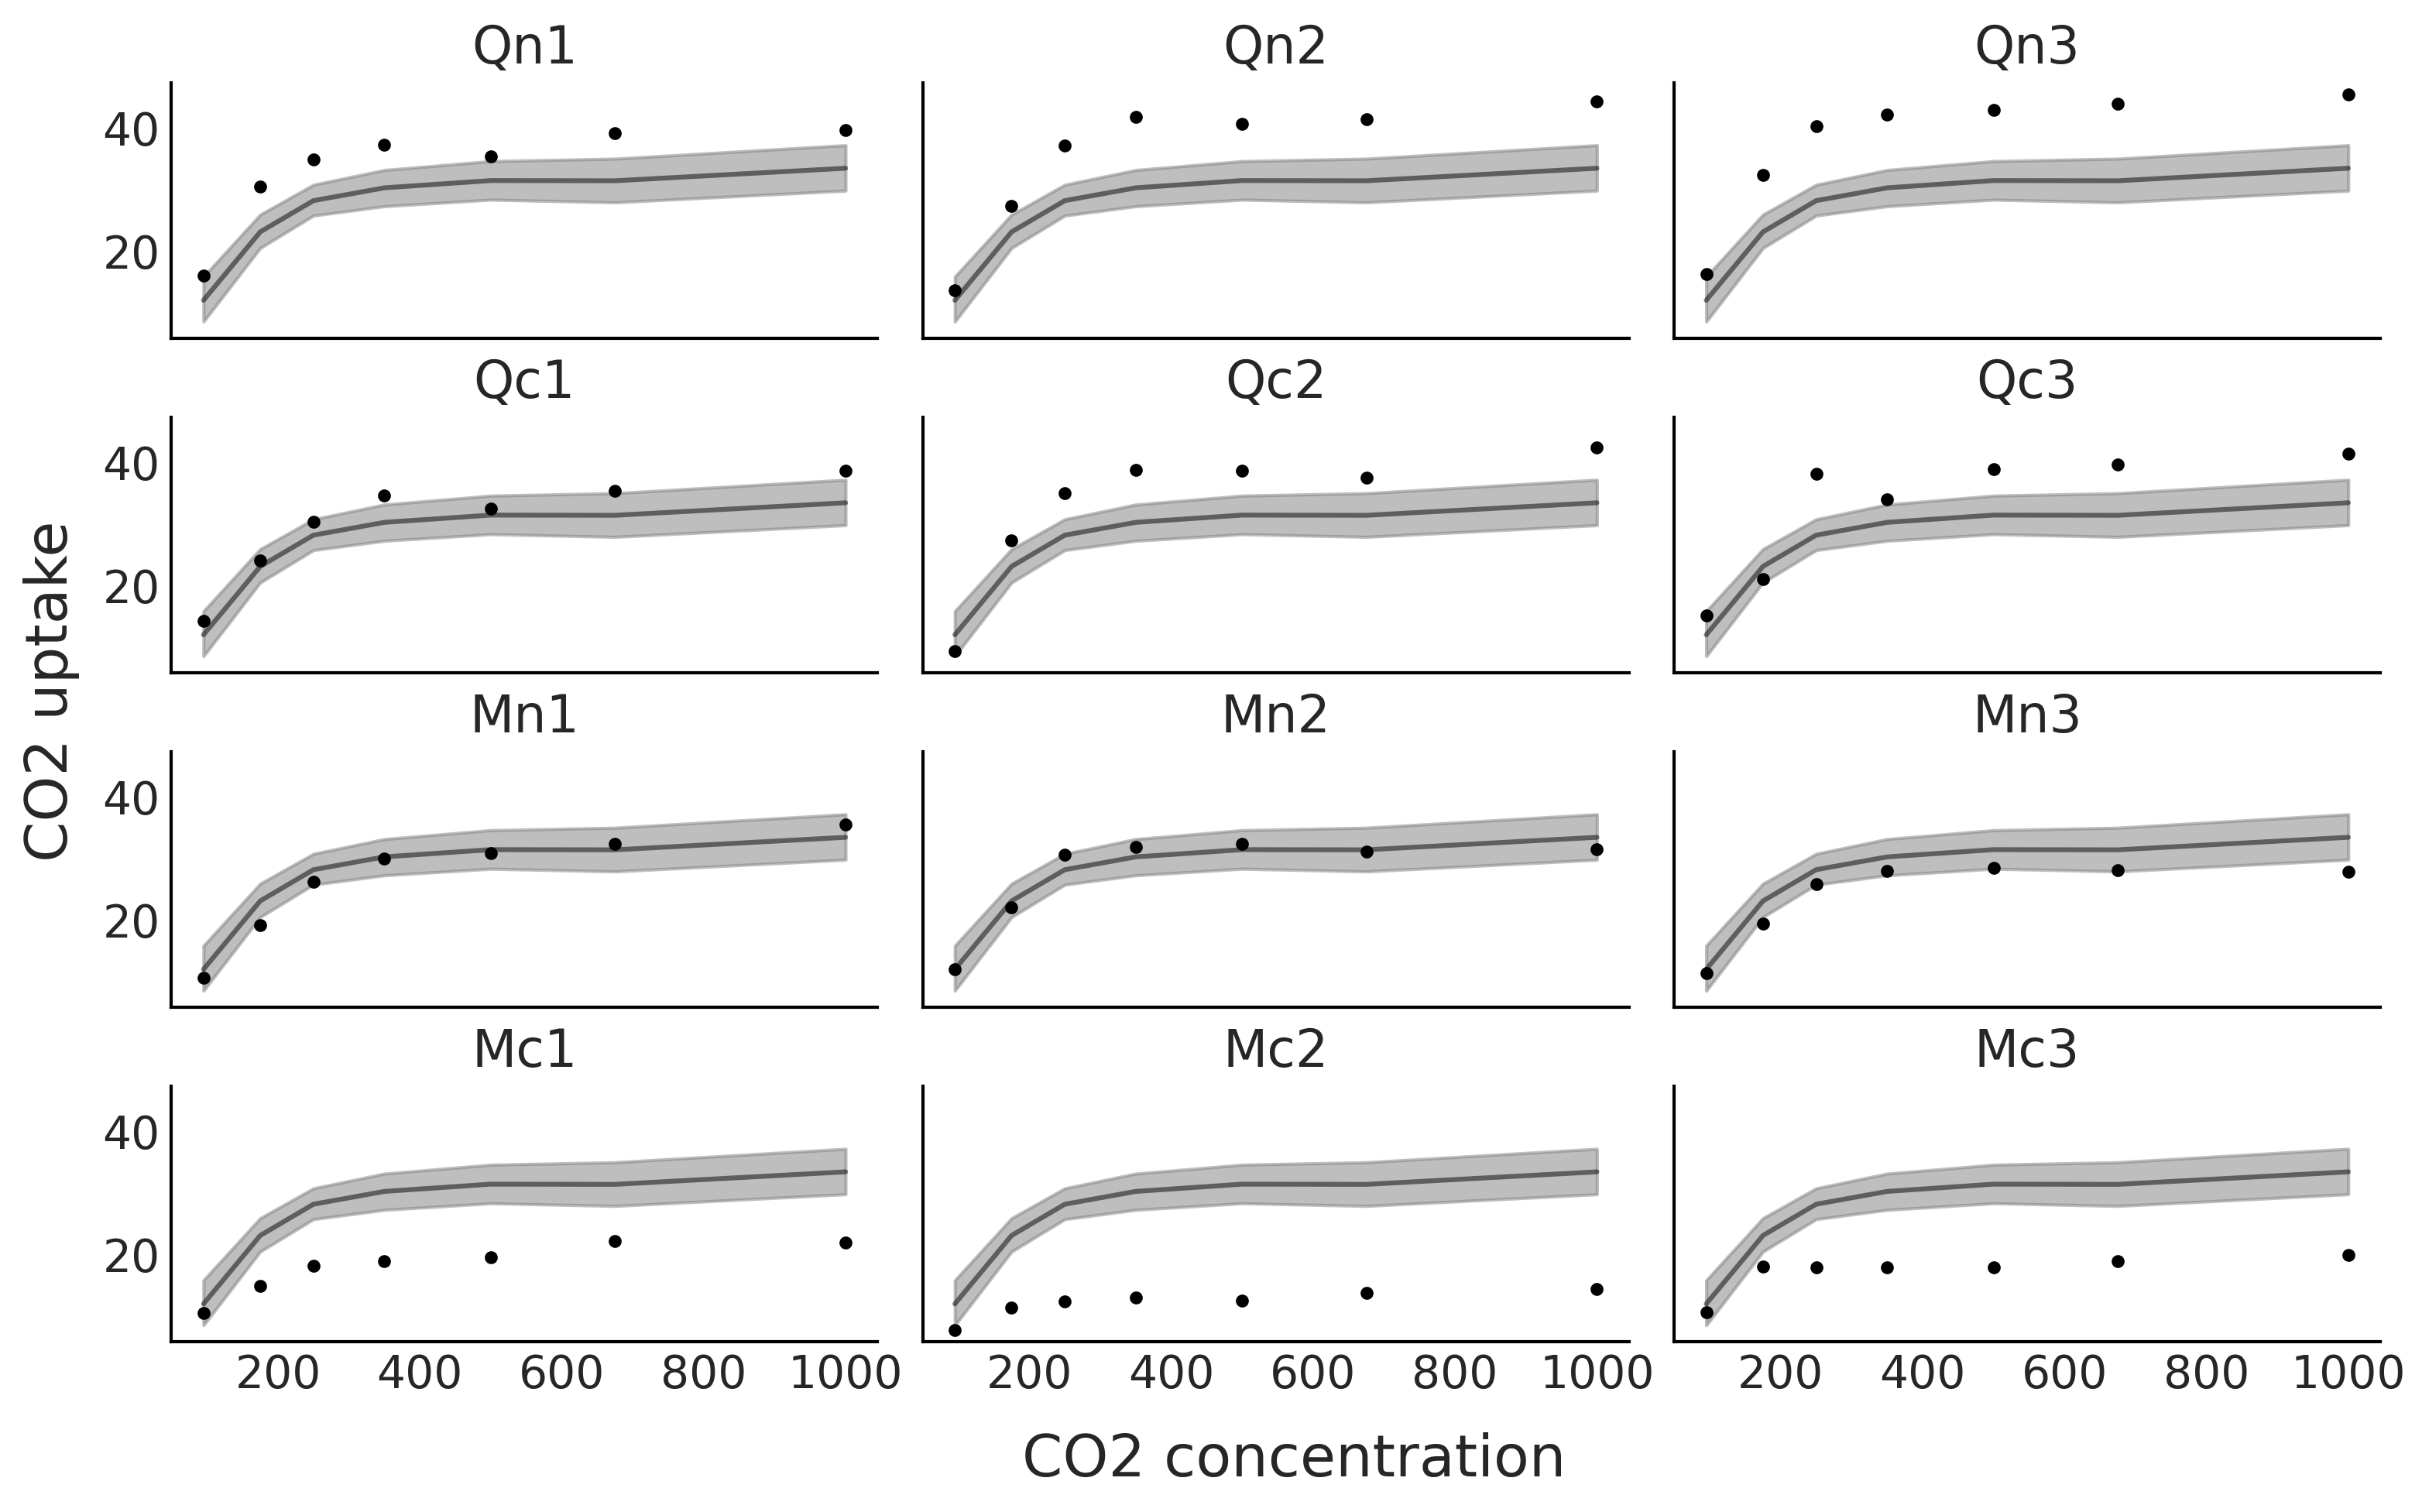

In [35]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)
μsg = idata_sp_global.posterior.stack(draws=("chain", "draw"))["μg"].values.T
μsg_mean = μsg.mean(0)
for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(CO2_conc, uptake[idx:idx+7], '.', lw=1)
    ax.plot(CO2_conc, μsg_mean[idx:idx+7], "k", alpha=0.5);
    az.plot_hdi(CO2_conc, μsg[:,idx:idx+7], color="C2", smooth=False, ax=ax)
    ax.set_title(plant_names[count])
    
fig.text(0.4, -0.05, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)

plt.savefig("sp_global.png", bbox_inches='tight')

### Code 5.11

In [36]:
Bi = dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_conc, "knots": knot_list},
)

### Code 5.12 and Figure 5.13

In [37]:

with pm.Model() as sp_individual:
    τ = pm.HalfCauchy('τ', 1)
    βi = pm.Normal("βi", mu=0, sd=τ, shape=(Bi.shape[1], groups))
    μi = pm.Deterministic("μi", pm.math.dot(np.asfortranarray(Bi), βi))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μi[:,index].T.ravel(), σ, observed=uptake)
    idata_sp_individual = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, βi, τ]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/a

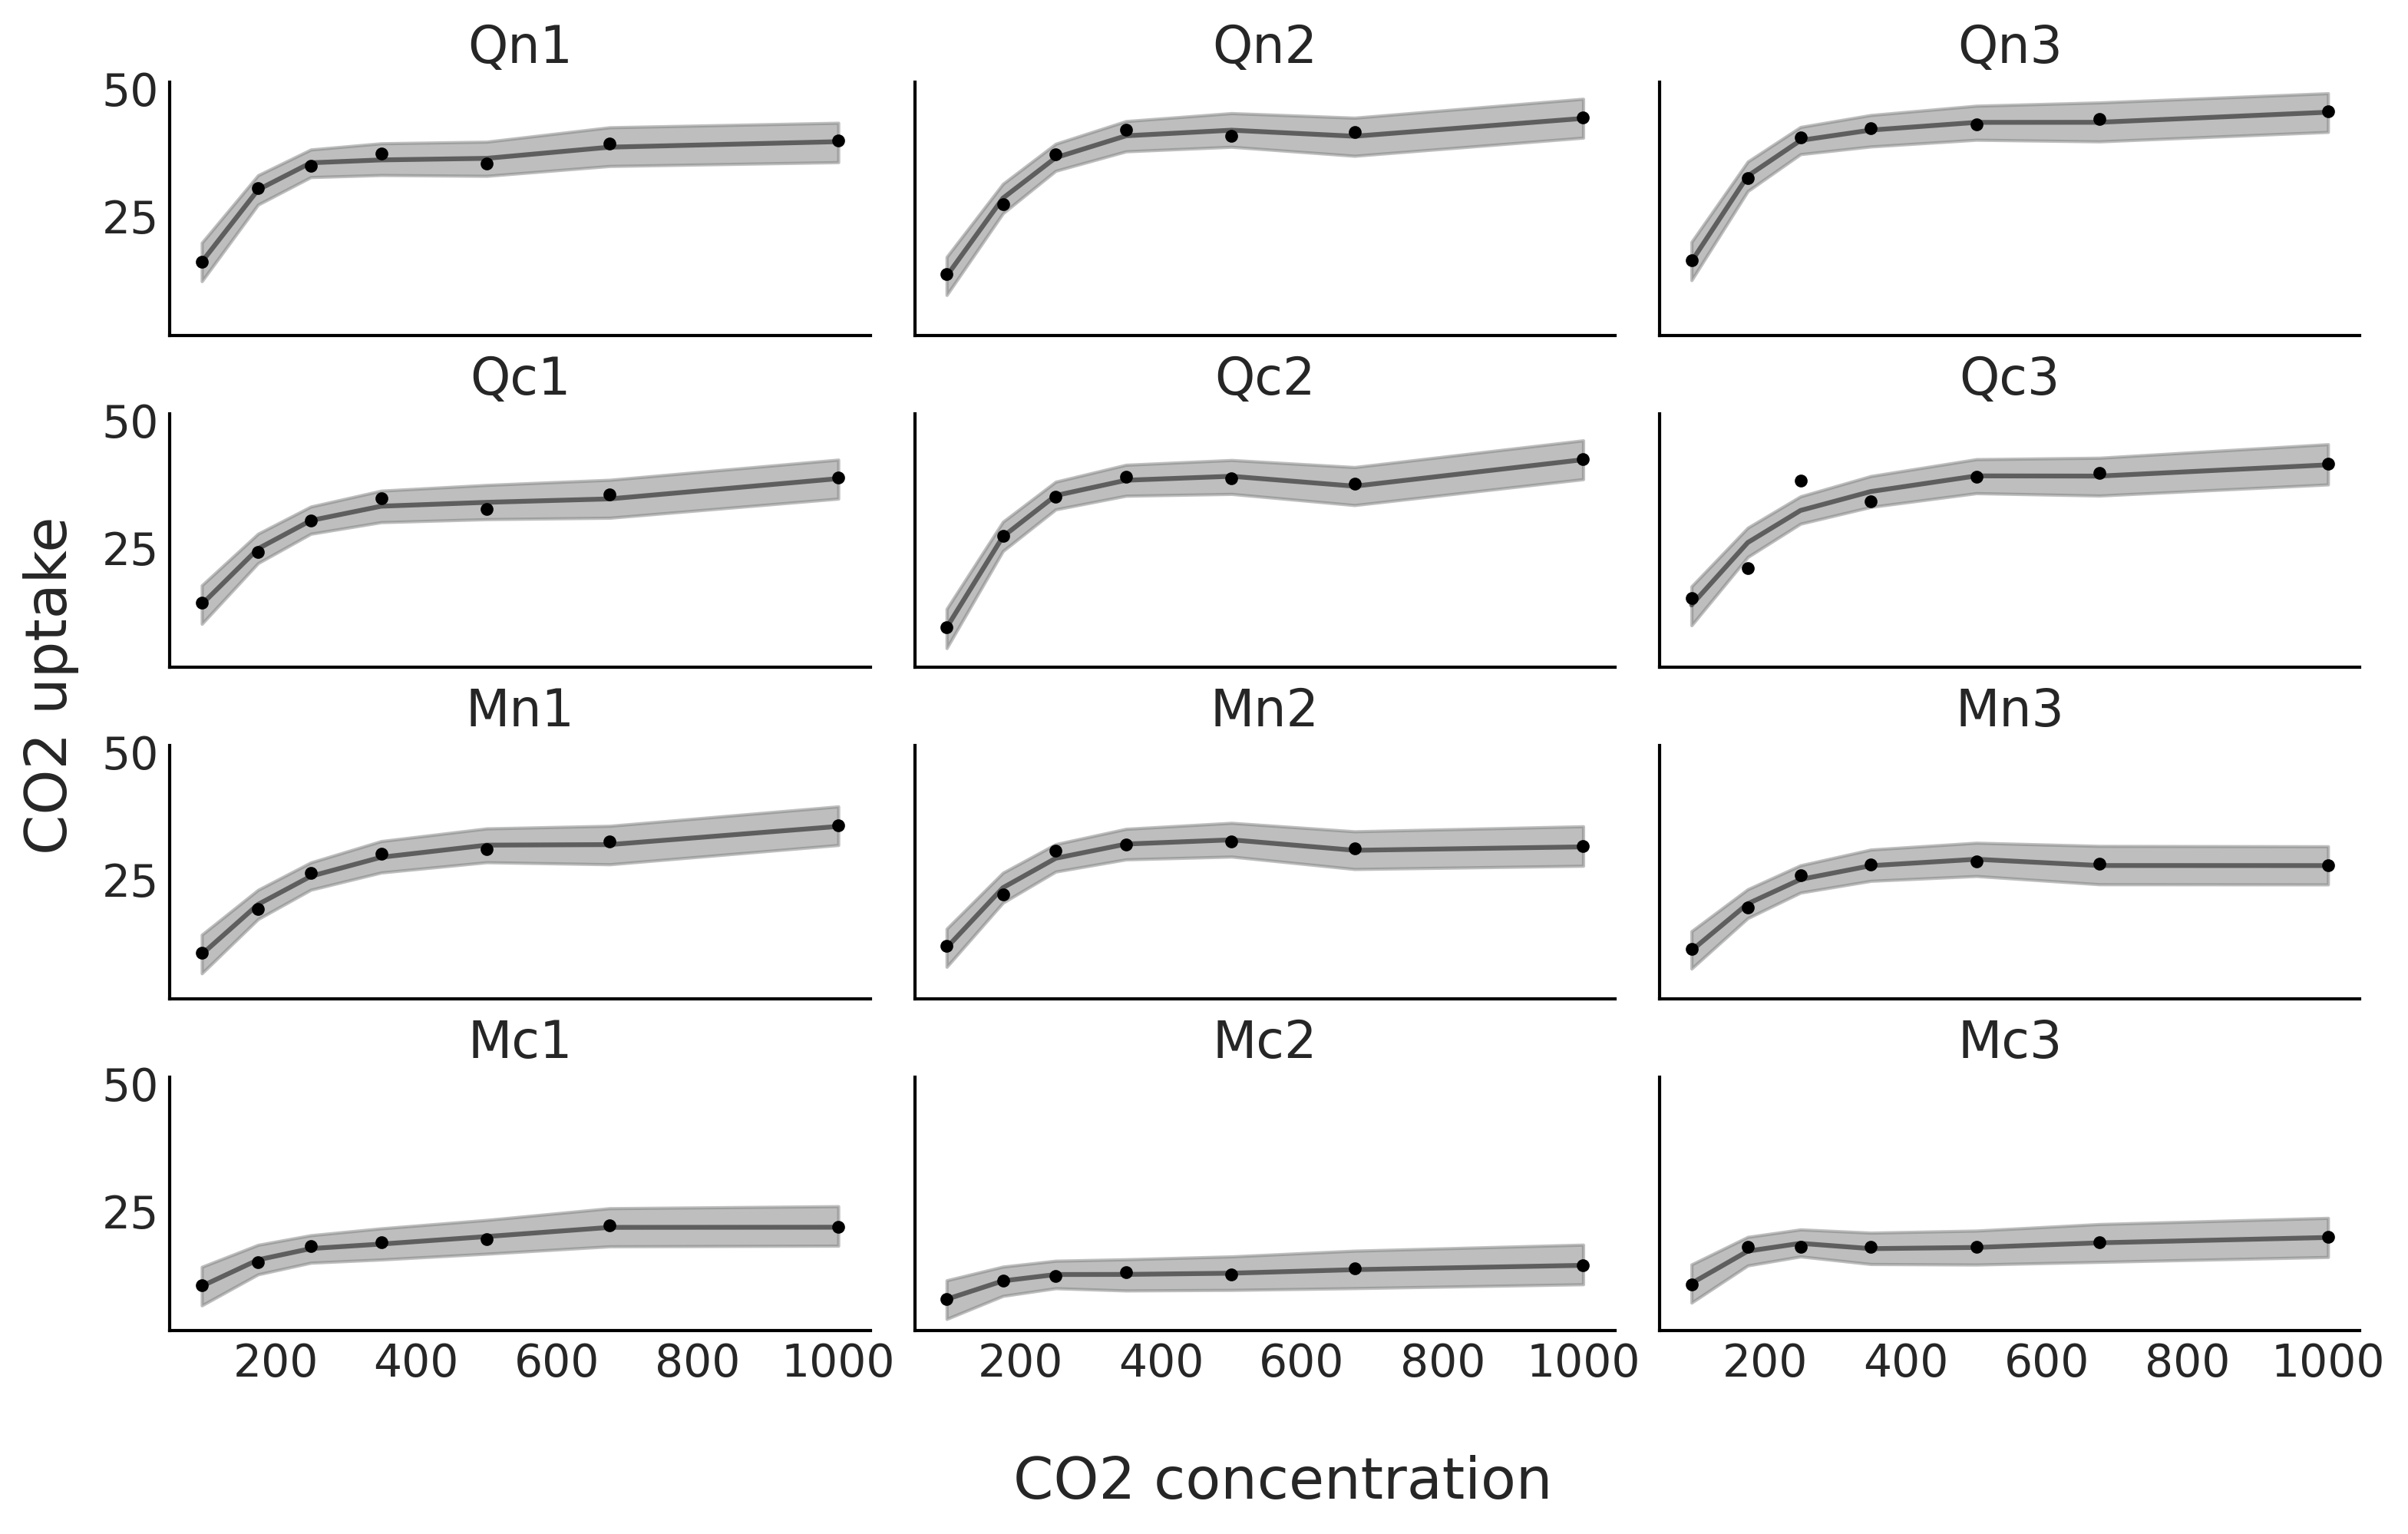

In [38]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)

μsi = idata_sp_individual.posterior.stack(draws=("chain", "draw"))["μi"].values.T
μsi_mean = μsi.mean(0)
for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(CO2_conc, uptake[idx:idx+7], '.', lw=1)
    ax.plot(CO2_conc, μsi_mean[index[count]], "k", alpha=0.5)
    az.plot_hdi(CO2_conc, μsi[:,index[count]], color="C2", smooth=False, ax=ax)
    ax.set_title(plant_names[count])
    
fig.text(0.4, -0.075, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)

plt.savefig("sp_individual.png", bbox_inches='tight')

### Code 5.13 and Figure 5.14

In [39]:
with pm.Model() as sp_mix:
    τ = pm.HalfCauchy('τ', 1)
    β = pm.Normal("β", mu=0, sd=τ, shape=Bg.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(np.asfortranarray(Bg), β))
    βi = pm.Normal("βi", mu=0, sd=τ, shape=(Bi.shape[1], groups))
    μi = pm.Deterministic("μi", pm.math.dot(np.asfortranarray(Bi), βi))
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg+μi[:,index].T.ravel(), σ, observed=uptake)
    idata_sp_mix = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, βi, β, τ]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 36 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/a

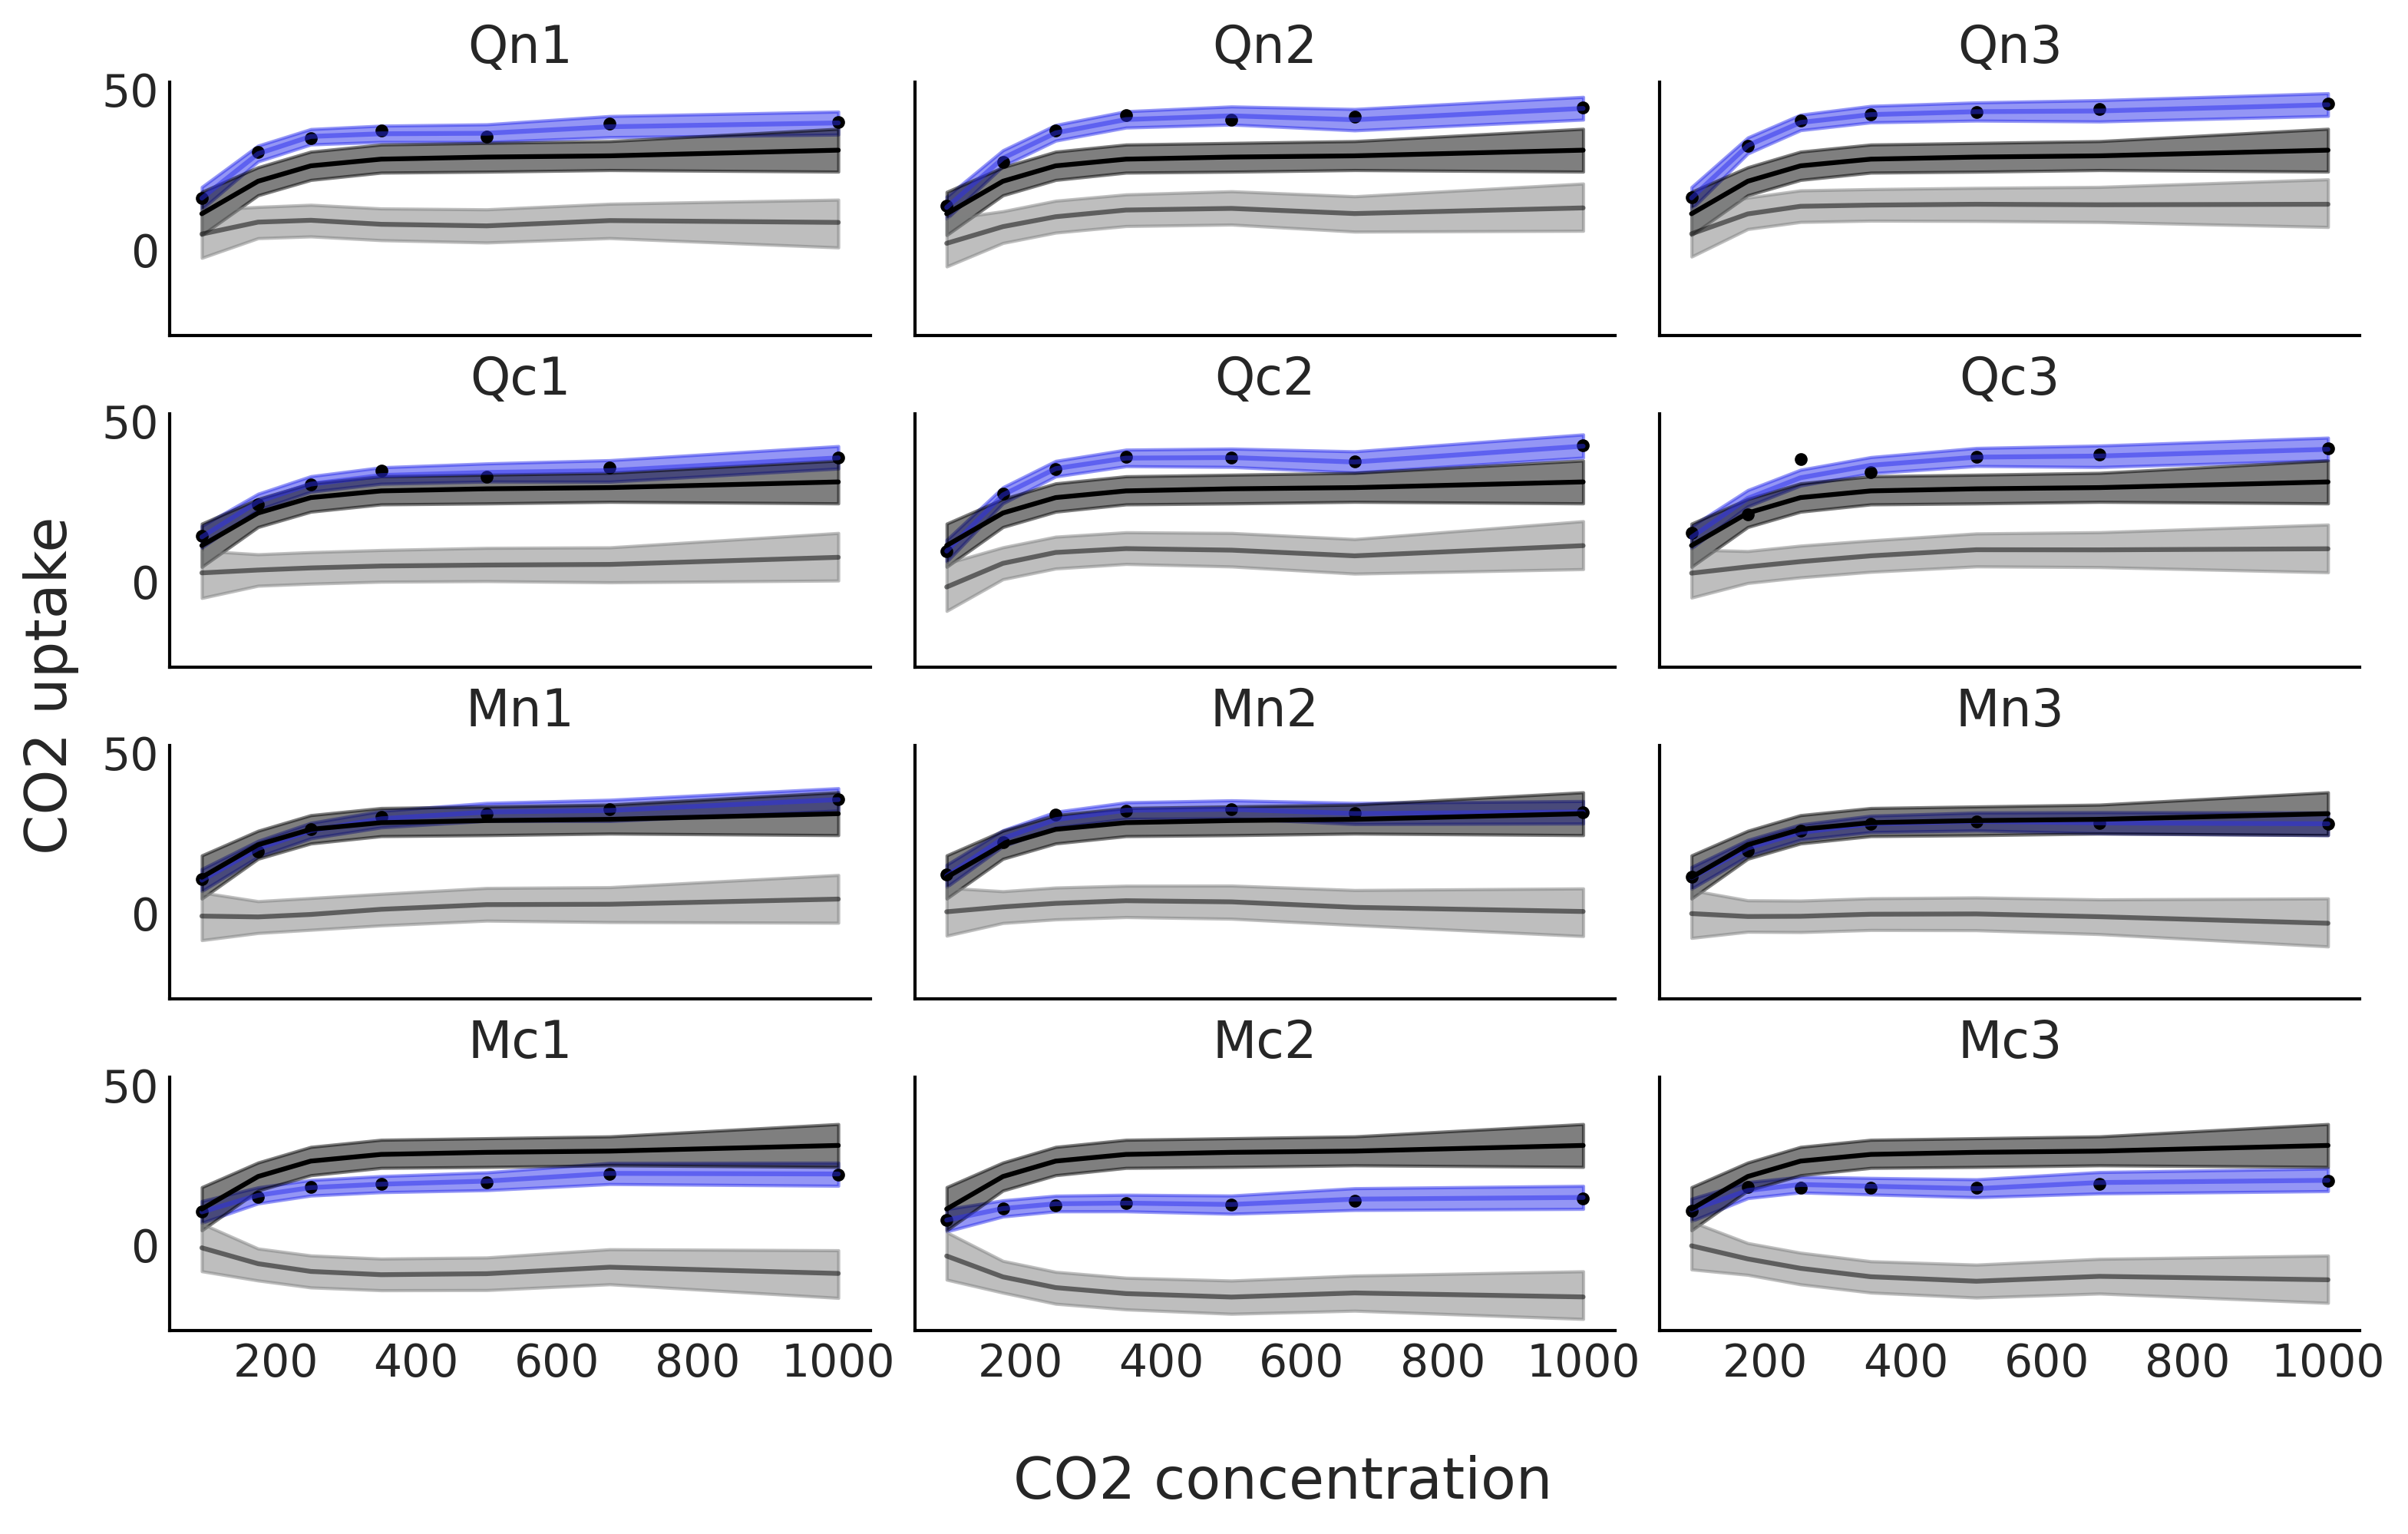

In [40]:
fig, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)

μsg = idata_sp_mix.posterior.stack(draws=("chain", "draw"))["μg"].values.T
μsg_mean = μsg.mean(0)

μsi = idata_sp_mix.posterior.stack(draws=("chain", "draw"))["μi"].values.T
μsi_mean = μsi.mean(0)

for count, (idx, ax) in enumerate(zip(range(0, 84, 7), axes.ravel())):
    ax.plot(CO2_conc, uptake[idx:idx+7], '.', lw=1)
    ax.plot(CO2_conc, μsg_mean[idx:idx+7]+μsi_mean[index[count]], "C4", alpha=0.5)
    az.plot_hdi(CO2_conc, μsg[:,idx:idx+7]+μsi[:,index[count]], color="C4", smooth=False,ax=ax)
    
    ax.plot(CO2_conc, μsg_mean[idx:idx+7], "k")
    az.plot_hdi(CO2_conc, μsg[:,idx:idx+7], color="k", smooth=False,ax=ax)
    
    ax.plot(CO2_conc, μsi_mean[index[count]], "k", alpha=0.5)
    az.plot_hdi(CO2_conc, μsi[:,index[count]], color="C2", smooth=False,ax=ax)
    ax.set_title(plant_names[count])
    
fig.text(0.4, -0.075, "CO2 concentration", size=18)
fig.text(-0.03, 0.4, "CO2 uptake", size=18, rotation=90)
plt.savefig("sp_mix_decomposed.png", bbox_inches='tight')

### Code 5.14 and Figure 5.15

In [41]:
cmp = az.compare({"sp_global":idata_sp_global, 
                  "sp_individual":idata_sp_individual, 
                  "sp_mix":idata_sp_mix})
cmp

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

rank         loo      p_loo      d_loo        weight  \
sp_mix            0 -217.084595  57.761701   0.000000  9.604449e-01   
sp_individual     1 -229.938877  64.015402  12.854282  6.485485e-12   
sp_global         2 -307.397540   8.931111  90.312945  3.955510e-02   

                      se        dse  warning loo_scale  
sp_mix         12.994436   0.000000     True       log  
sp_individual  12.104280   1.757456     True       log  
sp_global       9.012528  16.106581    False       log

# Exercises

## 5E7

In [90]:
num_knots = 6
knot_list = np.linspace(0, 23, num_knots)[1:-1]
B= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
           {"cnt": data.hour.values, "knots": knot_list})

with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idata = pm.sample(1000, return_inferencedata=True)
posterior = idata.posterior.stack(samples=['chain', 'draw'])

knot_listA = np.linspace(0, 23, num_knots)
BA= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
            {"cnt": data.hour.values, "knots": knot_listA})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=BA.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(BA), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idataA = pm.sample(1000, return_inferencedata=True)
posteriorA = idataA.posterior.stack(samples=['chain', 'draw'])    

knot_listB = np.quantile(data.hour,np.linspace(0, 1, num_knots))
BB= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
            {"cnt": data.hour.values, "knots": knot_listB})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=BB.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(BB), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idataB = pm.sample(1000, return_inferencedata=True)
posteriorB = idataB.posterior.stack(samples=['chain', 'draw'])  


num_knots = 3
knot_listA2 = np.linspace(0, 23, num_knots)
BA= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
            {"cnt": data.hour.values, "knots": knot_listA2})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=BA.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(BA), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idataA2 = pm.sample(1000, return_inferencedata=True)
posteriorA2 = idataA2.posterior.stack(samples=['chain', 'draw'])    

knot_listB2 = np.quantile(data.hour,np.linspace(0, 1, num_knots))
BB= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
            {"cnt": data.hour.values, "knots": knot_listB2})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=BB.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(BB), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idataB2 = pm.sample(1000, return_inferencedata=True)
posteriorB2 = idataB2.posterior.stack(samples=['chain', 'draw'])  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Text(0, 0.5, 'count')

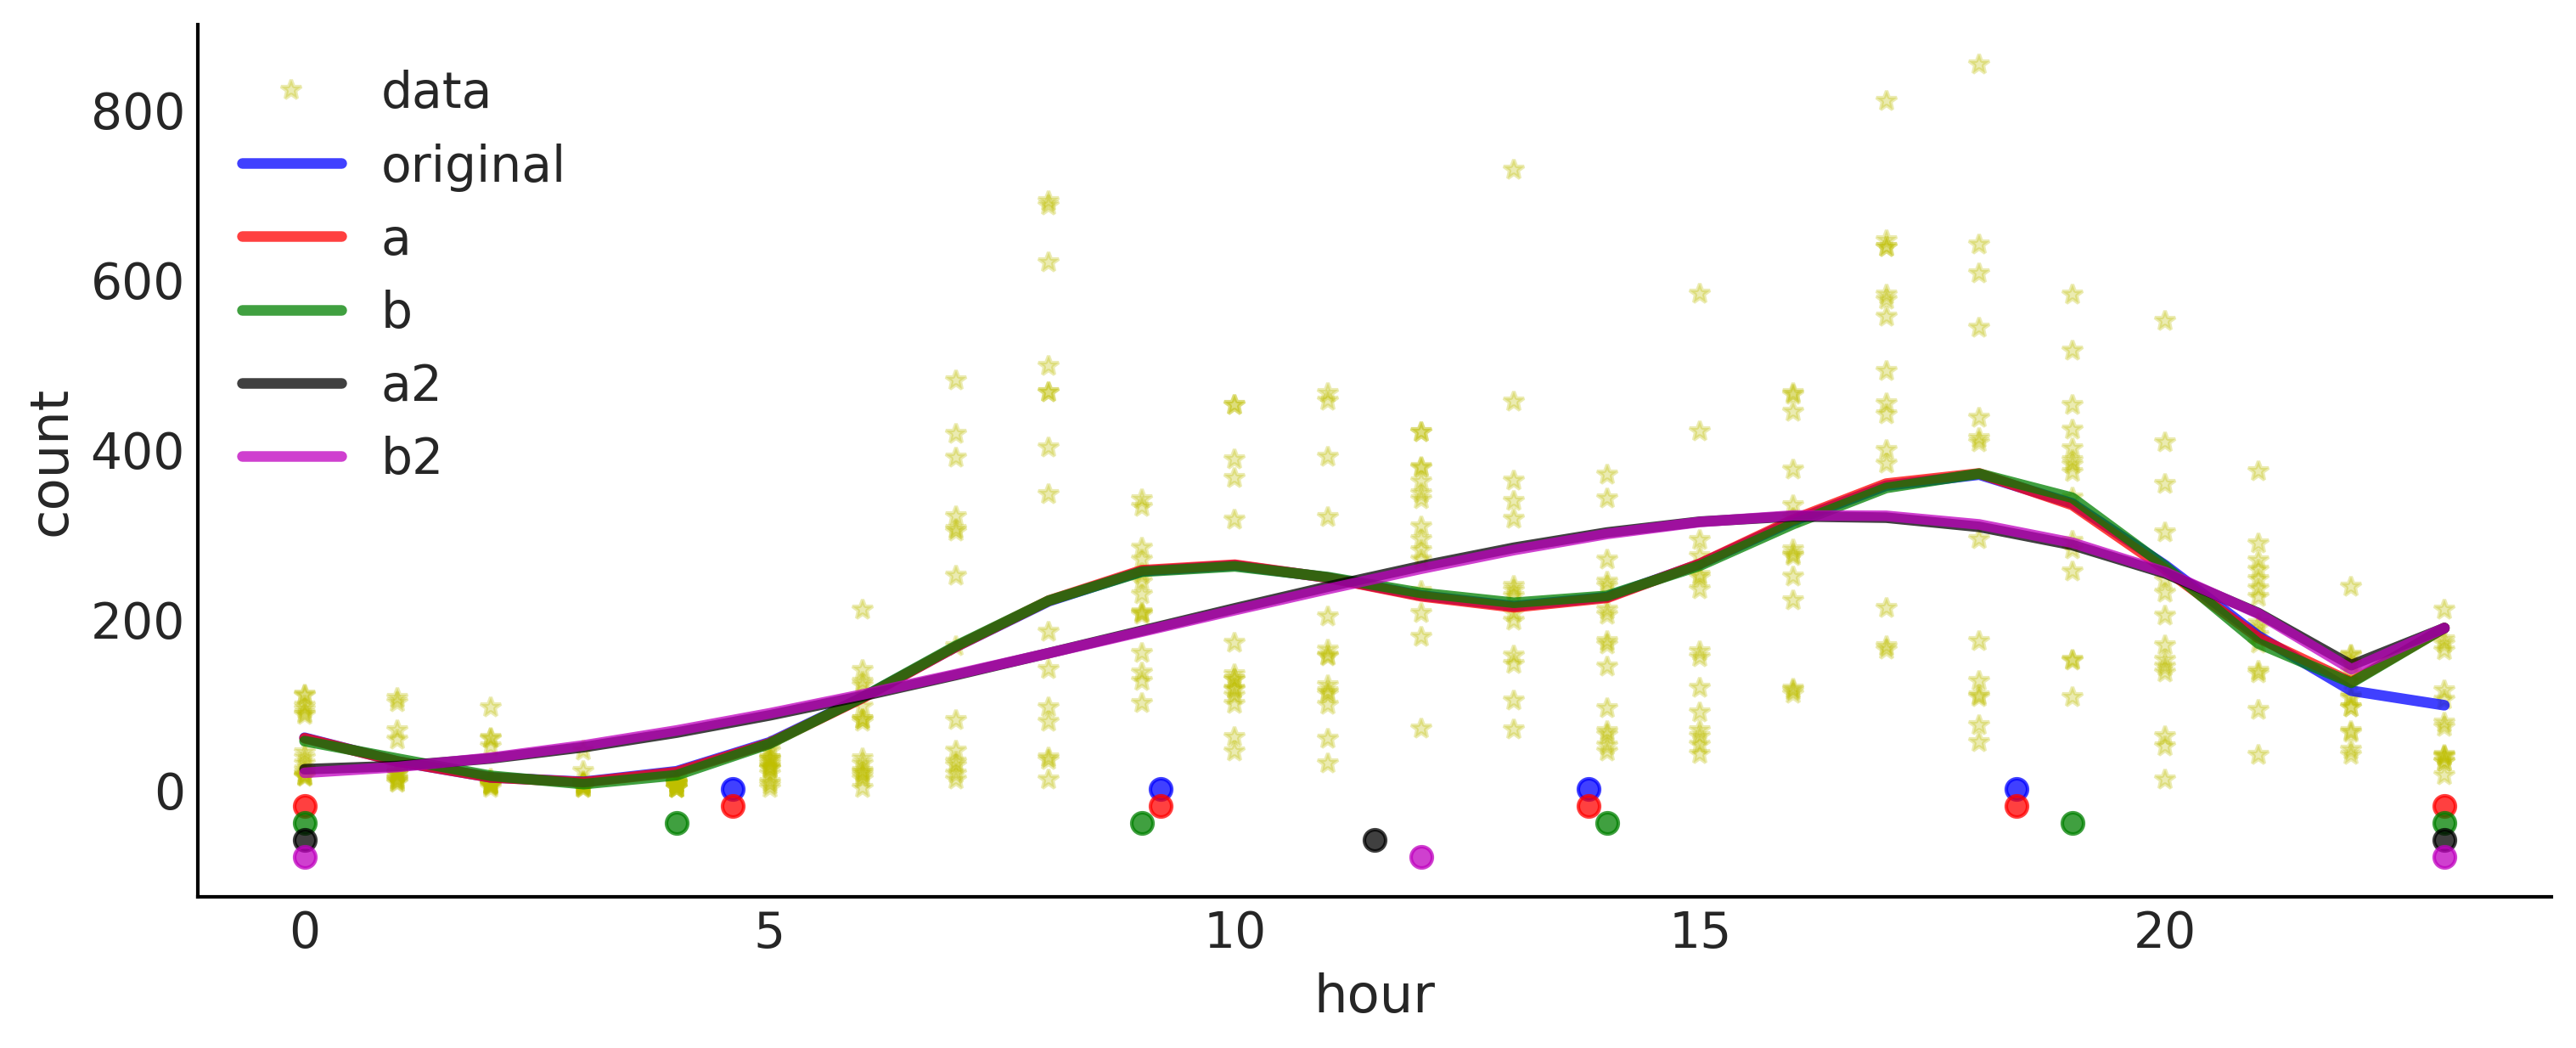

In [92]:
c=['b','r','g','k','m']
l={'original':(posterior,knot_list),'a':(posteriorA,knot_listA),
   'b':(posteriorB,knot_listB),'a2':(posteriorA2,knot_listA2),'b2':(posteriorB2,knot_listB2)}
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data.hour, data['count'], "y*", alpha=0.3,label='data')
for i,k in enumerate(l.keys()):
    ax.plot(data.hour, l[k][0]["μ"].mean("samples") * data_cnt_os + data_cnt_om, c=c[i],
            lw=3,alpha=0.75,label=k)
    ax.plot(l[k][1], -20*i + np.zeros_like(l[k][1]), c[i]+'o',alpha=0.75)

    ax.legend()
ax.set_xlabel("hour")
ax.set_ylabel("count")

## 5E8 

In [153]:
df= pd.read_csv("../exercises/data/spectra.csv",index_col=False,header=None,names=['x','y'],sep=' ')
knot_list = np.quantile(df.x,np.arange(0,1,0.02))
B= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",{"cnt": df.x, "knots": knot_list})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=df["y"].values)
    idataA = pm.sample(1000, return_inferencedata=True)
posterior = idataA.posterior.stack(samples=['chain', 'draw']) 


with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.GaussianRandomWalk("β", mu=0, sigma=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=df["y"].values)
    idataB = pm.sample(1000, return_inferencedata=True)
posterior2 = idataB.posterior.stack(samples=['chain', 'draw']) 

knot_list3 = np.quantile(df.x,np.arange(0.1,1,0.1))
B3= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",{"cnt": df.x, "knots": knot_list3})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B3.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B3), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=df["y"].values)
    idataC = pm.sample(1000, return_inferencedata=True)
posterior3 = idataC.posterior.stack(samples=['chain', 'draw']) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Text(0, 0.5, 'count')

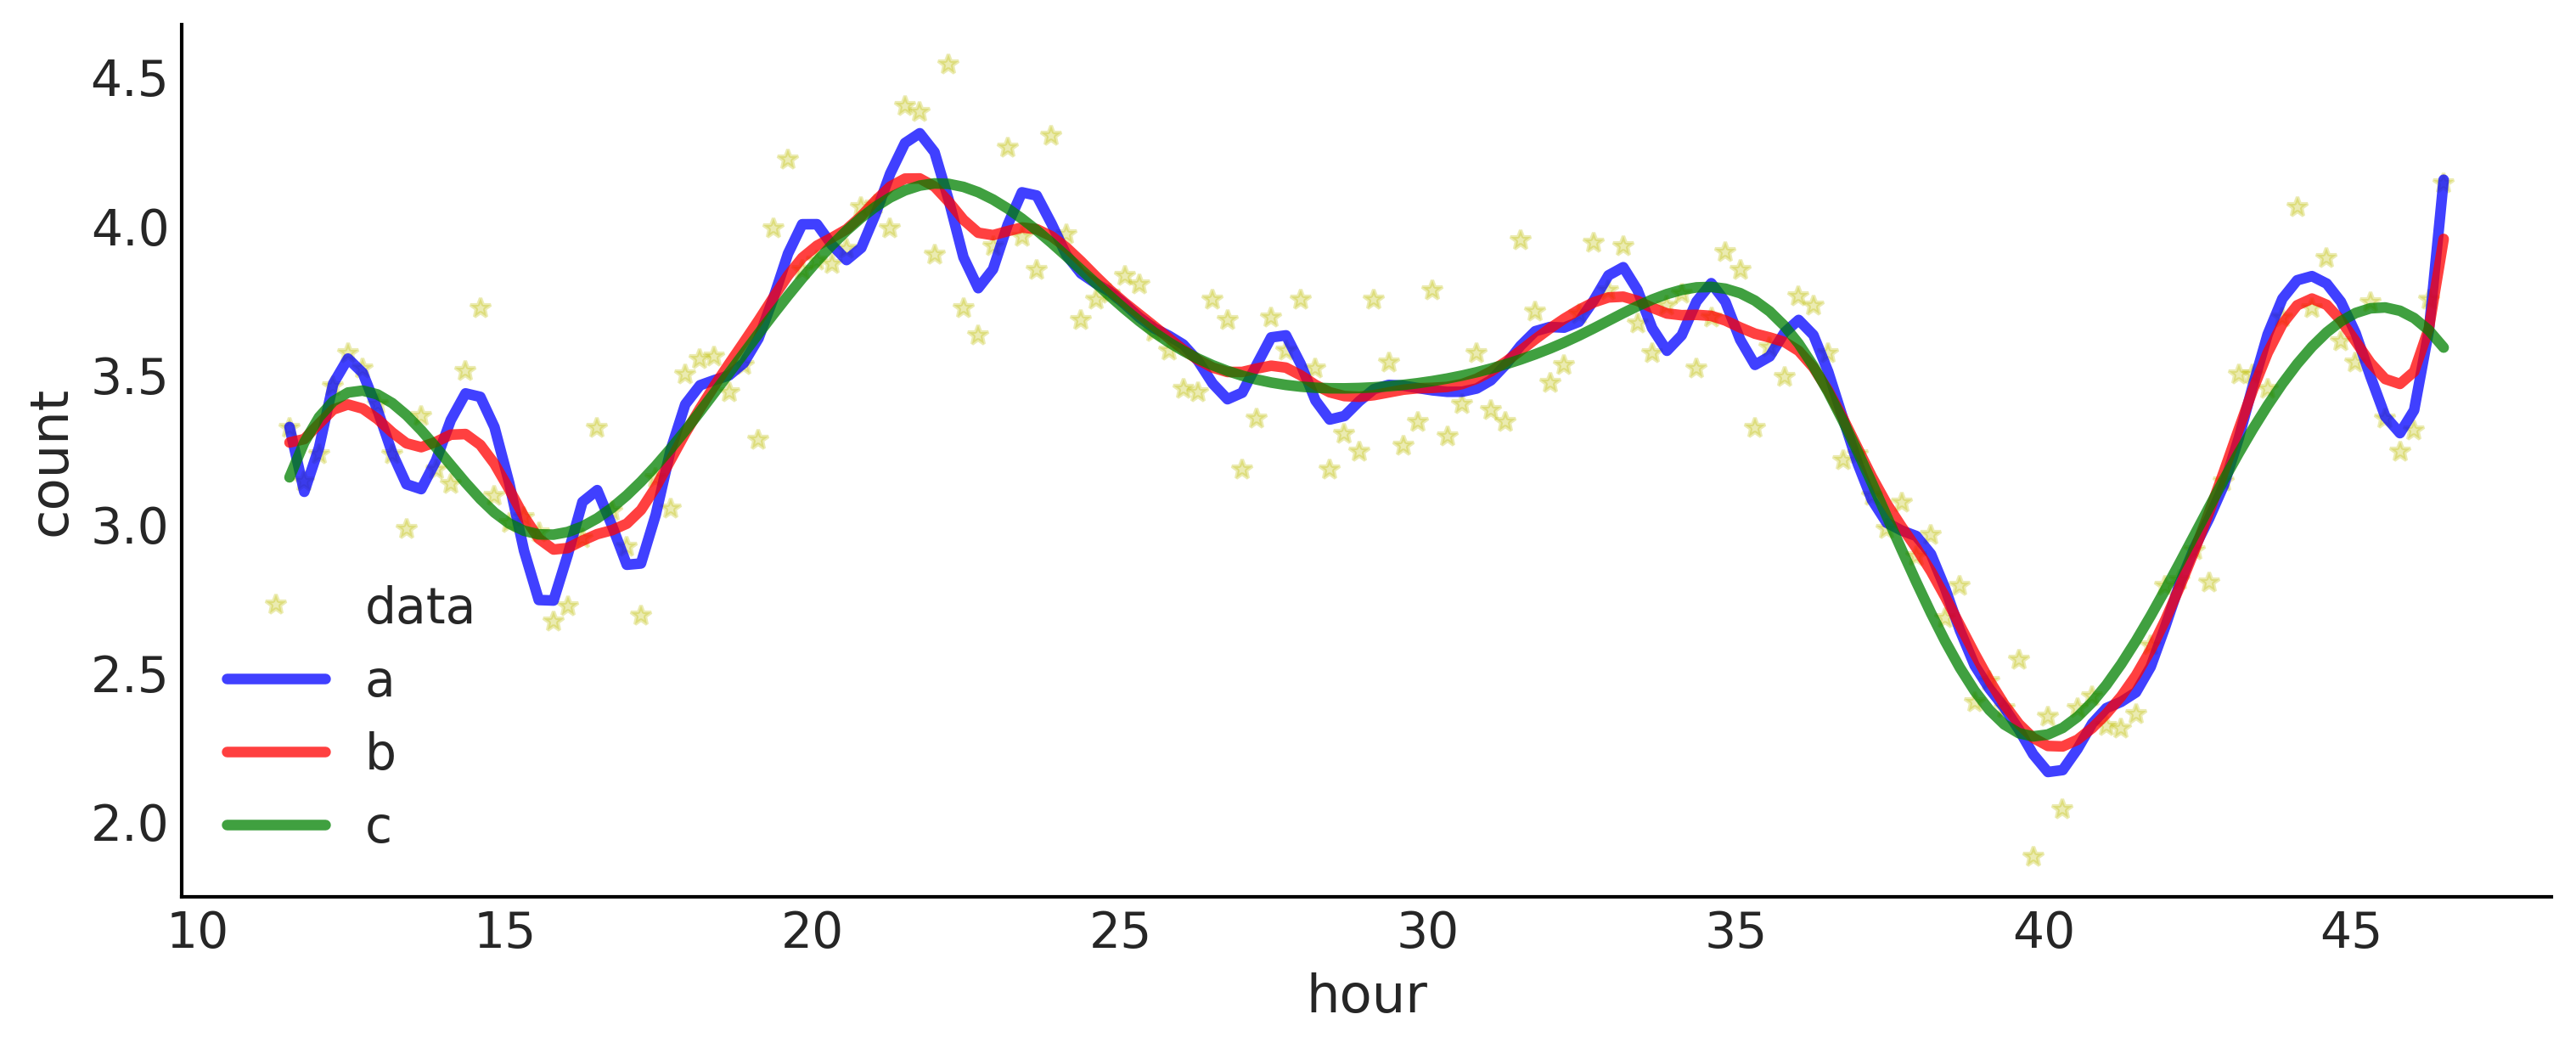

In [154]:
c=['b','r','g','k','m']
l={'a':(posterior,knot_list),'b':(posterior2,knot_list),'c':(posterior3,knot_list3)}
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(df.x, df['y'], "y*", alpha=0.3,label='data')
for i,k in enumerate(l.keys()):
    ax.plot(df.x, l[k][0]["μ"].mean("samples"), c=c[i],lw=3,alpha=0.75,label=k)
ax.legend()
ax.set_xlabel("hour")
ax.set_ylabel("count")

In [155]:
az.compare({'a':idataA,'b':idataB,'c':idataC})

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

rank        loo      p_loo      d_loo    weight         se       dse  \
b     0  13.756052  27.573608   0.000000  0.791883   8.079217  0.000000   
c     1   2.195566  16.601261  11.560486  0.164683  10.212551  6.840757   
a     2  -0.713820  47.515469  14.469872  0.043434   7.485442  5.293750   

   warning loo_scale  
b     True       log  
c     True       log  
a     True       log

## 5M10

In [197]:
num_knots = 6
knot_list = np.linspace(0, 23, num_knots)[1:-1]
B= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",{"cnt": data.hour.values, "knots": knot_list})

with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idata = pm.sample(1000, return_inferencedata=True)
posterior = idata.posterior.stack(samples=['chain', 'draw'])


num_knots = 18
knot_listA = np.linspace(0, 23, num_knots)[1:-1]
BA= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",{"cnt": data.hour.values, "knots": knot_listA})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=BA.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(BA), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idataA = pm.sample(1000, return_inferencedata=True)
posteriorA = idataA.posterior.stack(samples=['chain', 'draw'])    

num_knots = 6
knot_listB = np.linspace(0, 23, num_knots)[1:-1]
BB= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",{"cnt": data.hour.values, "knots": knot_listB})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 100) 
    β = pm.Normal("β", mu=0, sd=τ, shape=BB.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(BB), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    idataB = pm.sample(1000, return_inferencedata=True)
posteriorB = idataB.posterior.stack(samples=['chain', 'draw'])  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Text(0, 0.5, 'count')

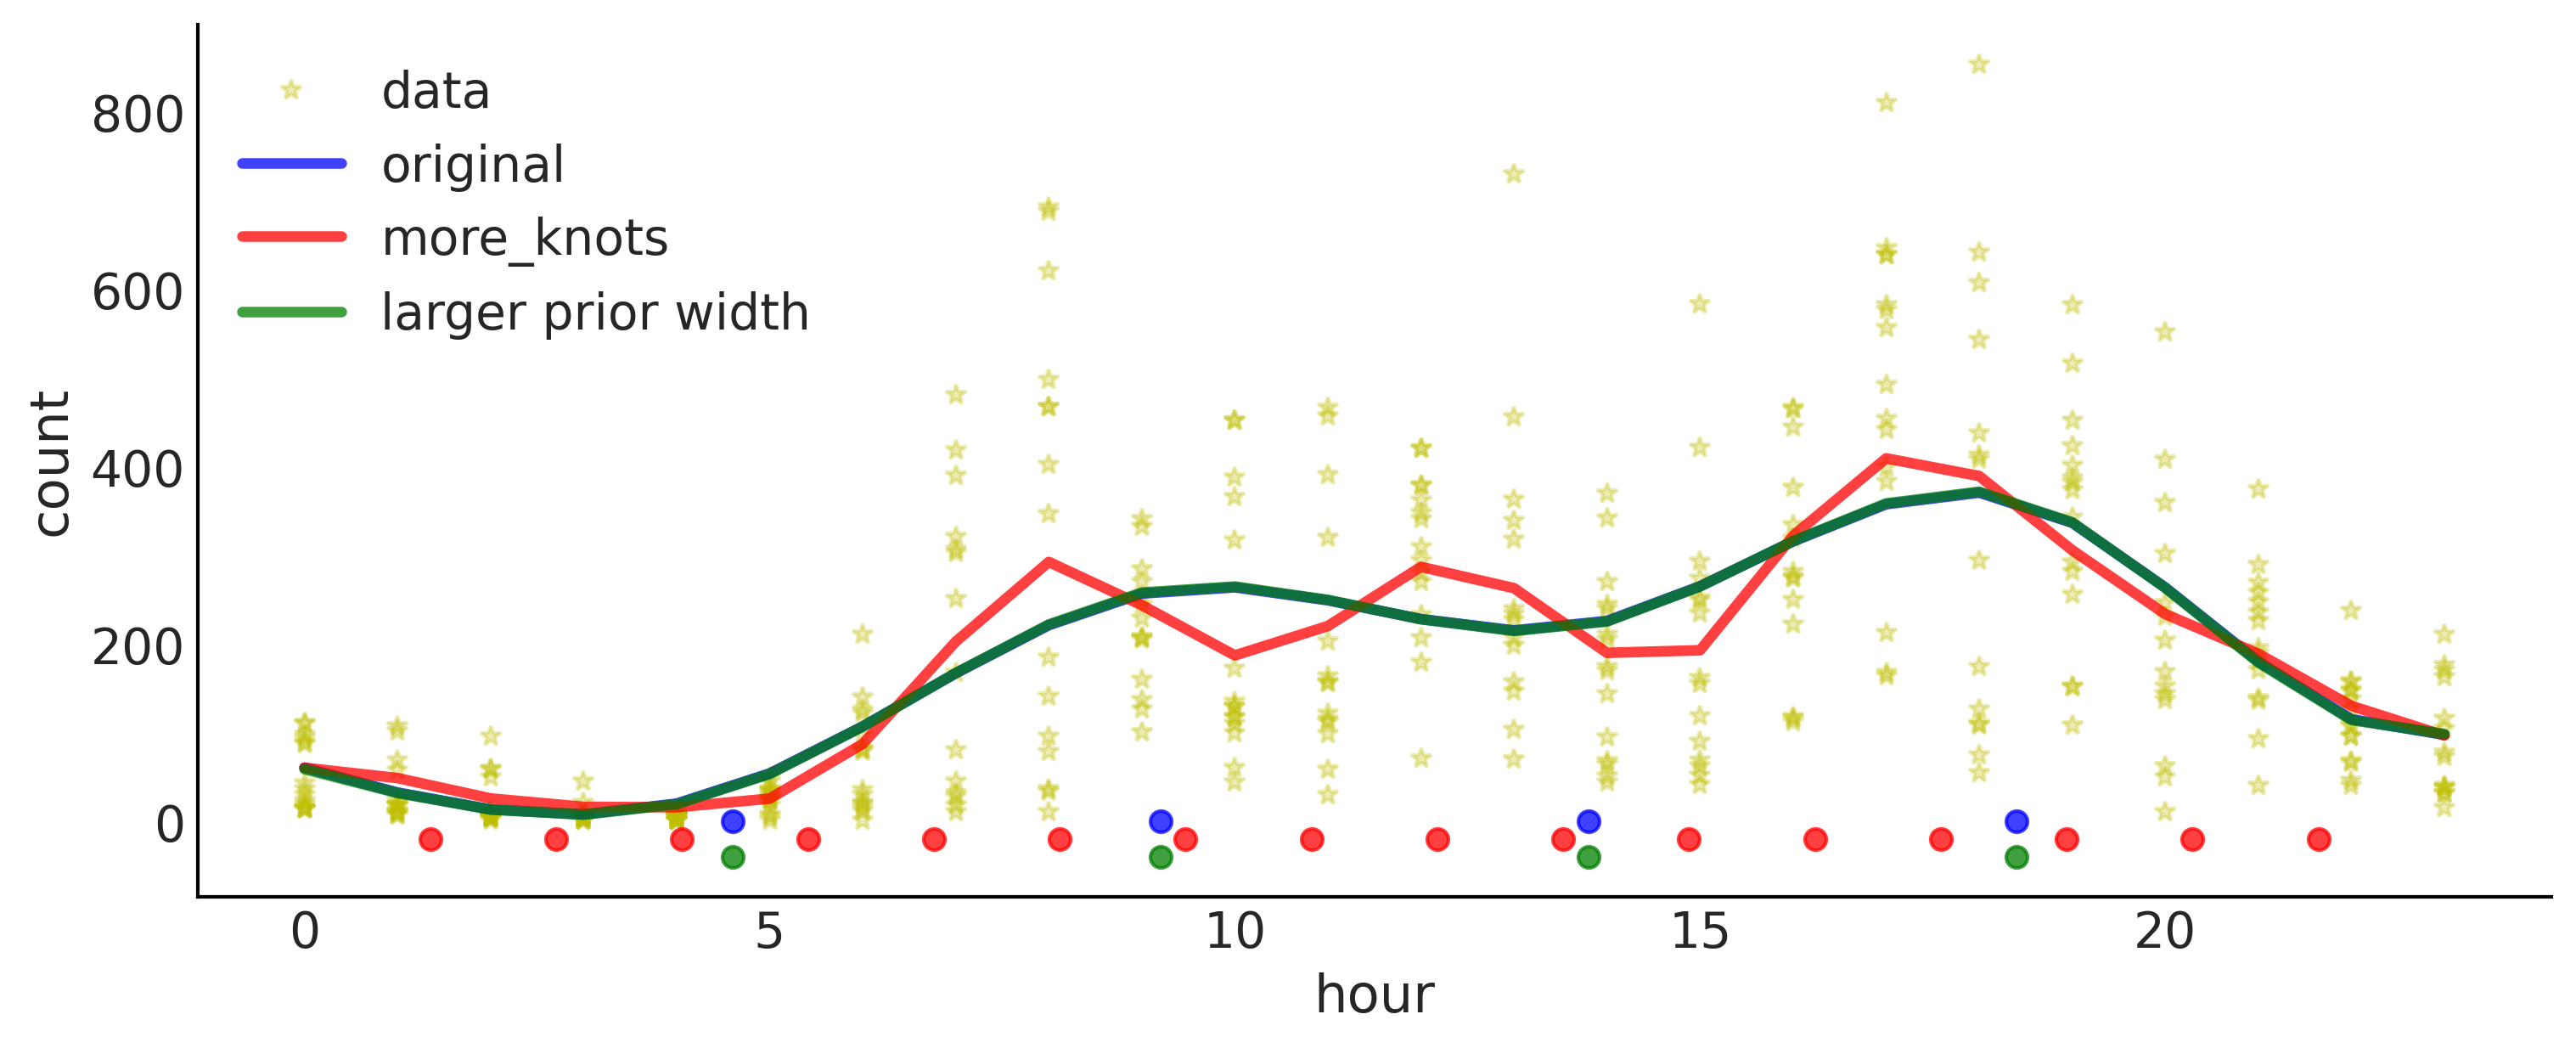

In [198]:
c=['b','r','g','k','m']
l={'original':(posterior,knot_list),'more_knots':(posteriorA,knot_listA),
   'larger prior width':(posteriorB,knot_listB)}
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data.hour, data['count'], "y*", alpha=0.3,label='data')
for i,k in enumerate(l.keys()):
    ax.plot(data.hour, l[k][0]["μ"].mean("samples") * data_cnt_os + data_cnt_om, c=c[i],
            lw=3,alpha=0.75,label=k)
    ax.plot(l[k][1], -20*i + np.zeros_like(l[k][1]), c[i]+'o',alpha=0.75)

    ax.legend()
ax.set_xlabel("hour")
ax.set_ylabel("count")

## 5M11

In [220]:
babies = pd.read_csv('../data/babies.csv')
knot_list = np.arange(0,25,5)
B= dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",{"cnt": babies.Month, "knots": knot_list})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.GaussianRandomWalk("β", mu=0, sigma=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=babies["Length"].values)
    idata = pm.sample(1000, return_inferencedata=True)
posterior = idata.posterior.stack(samples=['chain', 'draw']) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9001977855222705, but should be close to 0.8. Try to increase the number of tuning steps.


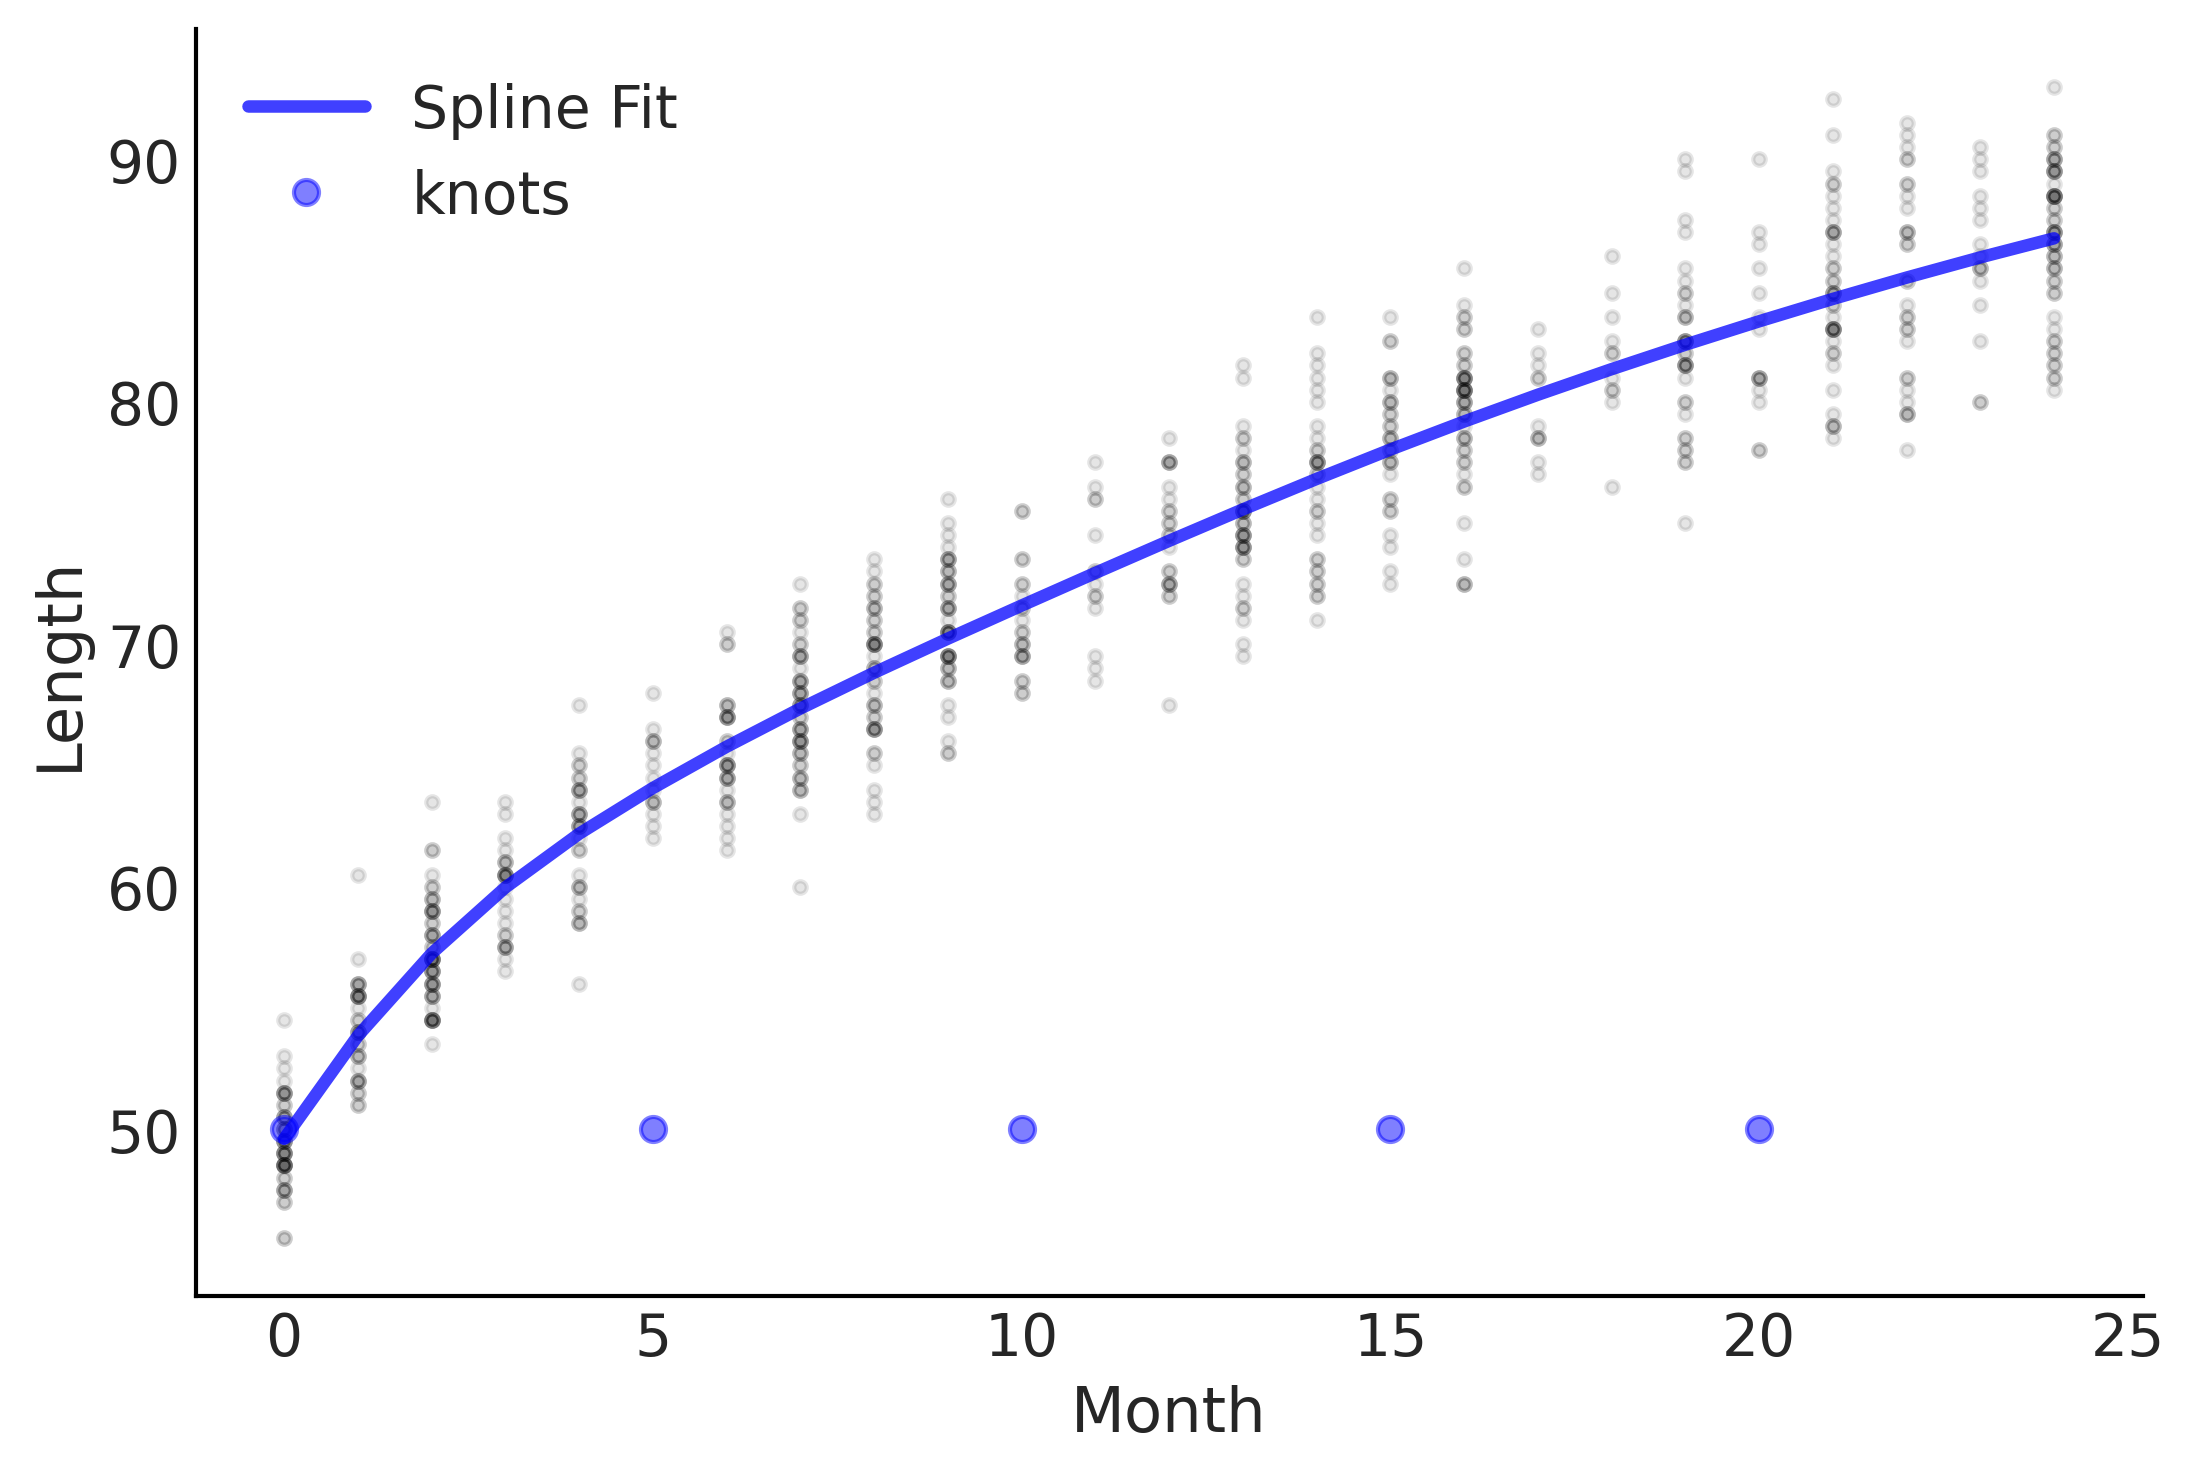

In [221]:
fig, ax = plt.subplots()

ax.set_ylabel("Length")
ax.set_xlabel("Month");
#μ_m = inf_data_linear.posterior["μ"].values.reshape(-1, babies["Length"].shape[0]).mean(axis=0)
#ax.plot(babies["Month"], μ_m, c='C4')
#az.plot_hdi(babies["Month"], inf_data_linear.posterior_predictive["length"], hdi_prob=.50, ax=ax)
#az.plot_hdi(babies["Month"], inf_data_linear.posterior_predictive["length"], hdi_prob=.94, ax=ax)

ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=0.1)
ax.plot(babies["Month"], posterior["μ"].mean("samples"), c='b',lw=3,alpha=0.75,label='Spline Fit')
ax.plot(knot_list, 50 + np.zeros_like(knot_list), 'bo',alpha=0.5,label='knots')
ax.legend()

## 5M12

In [238]:
#Repeat processing steps from the chapter above
bikes = pd.read_csv("../data/bikes_hour.csv")
bikes.sort_values(by="hour", inplace=True)
bikes_cnt_om = bikes["count"].mean()
bikes_cnt_os = bikes["count"].std()
bikes["count_normalized"] = (bikes["count"] - bikes_cnt_om) / bikes_cnt_os
bikes = bikes[::50]
bikes_c=bikes.copy()
h24=bikes[bikes.hour==0].copy()
h24["hour"]=24
bikes_c=pd.concat([bikes_c,h24],axis=0)
bikes_c.sort_values(by="hour", inplace=True)

In [241]:
num_knots = 6
knot_list = np.linspace(0, 23, num_knots)[1:-1]
B = dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
            {"cnt": bikes.hour.values, "knots": knot_list})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=bikes["count_normalized"].values)
    idata = pm.sample(1000, return_inferencedata=True)
    
Bc = dmatrix("cc(cnt, knots=knots) - 1",
            {"cnt": bikes_c.hour.values, "knots": knot_list})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=Bc.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(Bc), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=bikes_c["count_normalized"].values)
    idatac = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Text(0, 0.5, 'count')

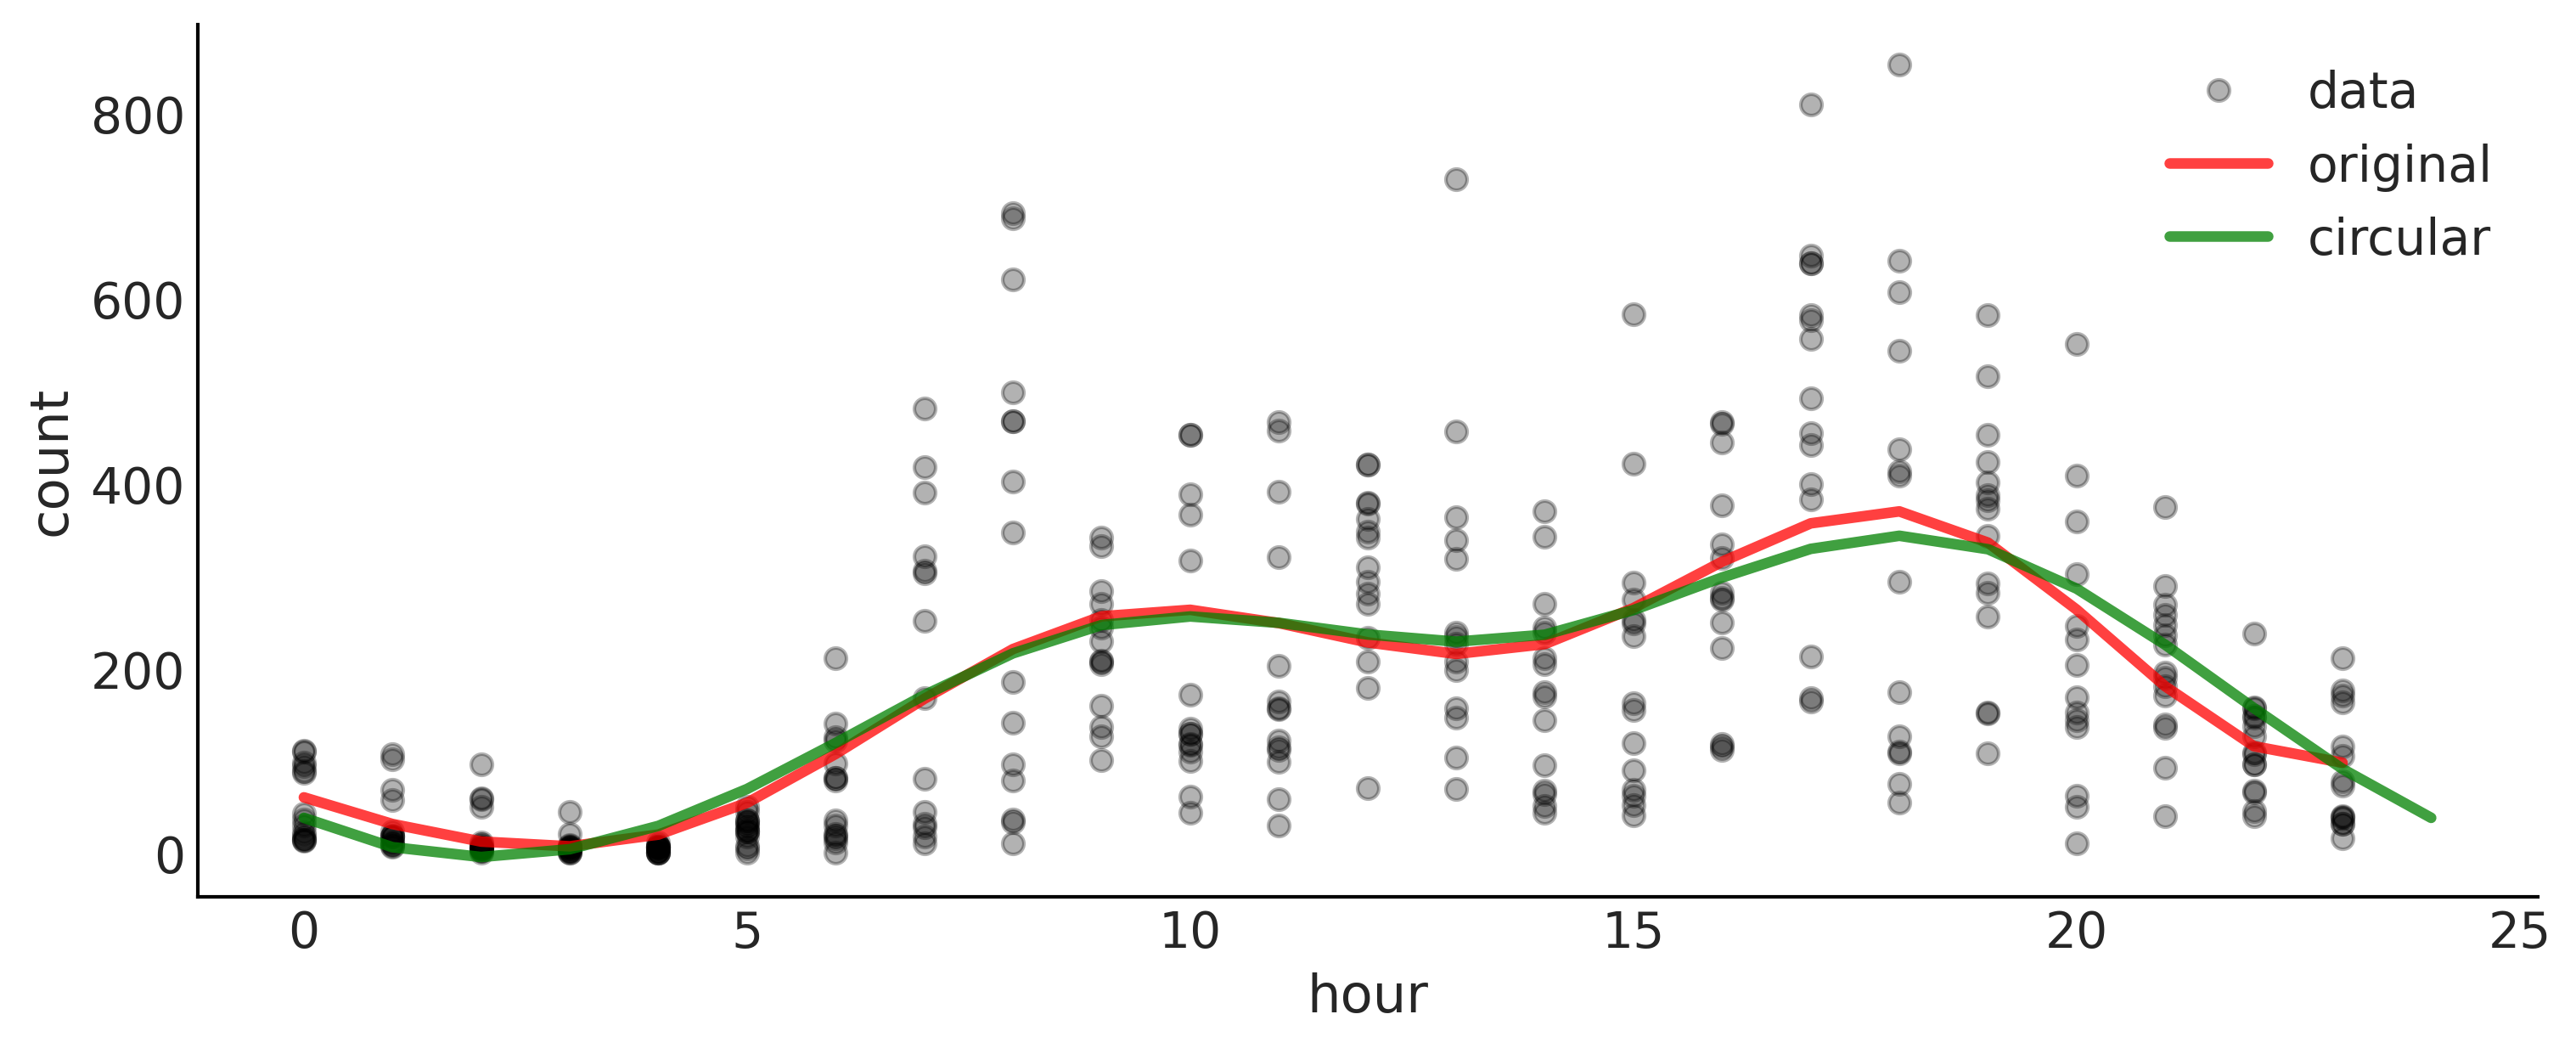

In [243]:
p = idata.posterior.stack(samples=['chain', 'draw'])
pc = idatac.posterior.stack(samples=['chain', 'draw'])
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(bikes.hour, bikes['count'], "ko", alpha=0.3,label='data')
ax.plot(bikes.hour,p["μ"].mean("samples")*bikes_cnt_os+bikes_cnt_om,c='r',lw=3,alpha=0.75,label='original')
ax.plot(bikes_c.hour,pc["μ"].mean("samples")*bikes_cnt_os+bikes_cnt_om,c='g',lw=3,alpha=0.75,label='circular')

ax.legend()
ax.set_xlabel("hour")
ax.set_ylabel("count")

In [256]:
print("***Original***")
print(az.loo(idata))
print(az.summary(idata,var_names=['σ']))
print("***Circular***")
print(az.loo(idatac))
print(az.summary(idatac,var_names=['σ']))

***Original***
Computed from 4000 by 348 log-likelihood matrix

         Estimate       SE
elpd_loo  -388.58    18.25
p_loo        7.94        -
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
σ  0.731  0.028   0.682    0.784        0.0      0.0    4511.0    2933.0   

   r_hat  
σ    1.0  
***Circular***
Computed from 4000 by 363 log-likelihood matrix

         Estimate       SE
elpd_loo  -401.74    19.14
p_loo        7.07        -
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
σ  0.726  0.027   0.674    0.776        0.0      0.0    4600.0    3302.0   

   r_hat  
σ    1.0  


## 5M13

In [297]:
num_knots = 6
knot_list = np.linspace(0, 23, num_knots)[1:-1]

B = dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
            {"cnt": bikes.hour.values,"knots": knot_list})

with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=bikes["count_normalized"].values)
    idata = pm.sample(1000, return_inferencedata=True)
    ppc_n = pm.sample_posterior_predictive(idata)


with pm.Model() as poisson:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.TruncatedNormal("β", mu=0, sd=τ,lower=0, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    c = pm.Poisson("c", mu=μ, observed=bikes["count"].values)
    idata_p = pm.sample(1000, return_inferencedata=True)
    ppc_p = pm.sample_posterior_predictive(idata_p)
    
    
with pm.Model() as neg_bin:
    τ = pm.HalfCauchy('τ', 1) 
    α= pm.Exponential('α',lam=0.5)
    β = pm.TruncatedNormal("β", mu=0, sd=τ,lower=0, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    c = pm.NegativeBinomial("c", alpha=α,mu=μ, observed=bikes["count"].values)
    idata_nb = pm.sample(1000, return_inferencedata=True)
    ppc_nb = pm.sample_posterior_predictive(idata_nb)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.9146436172740794, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Text(0, 0.5, 'count')

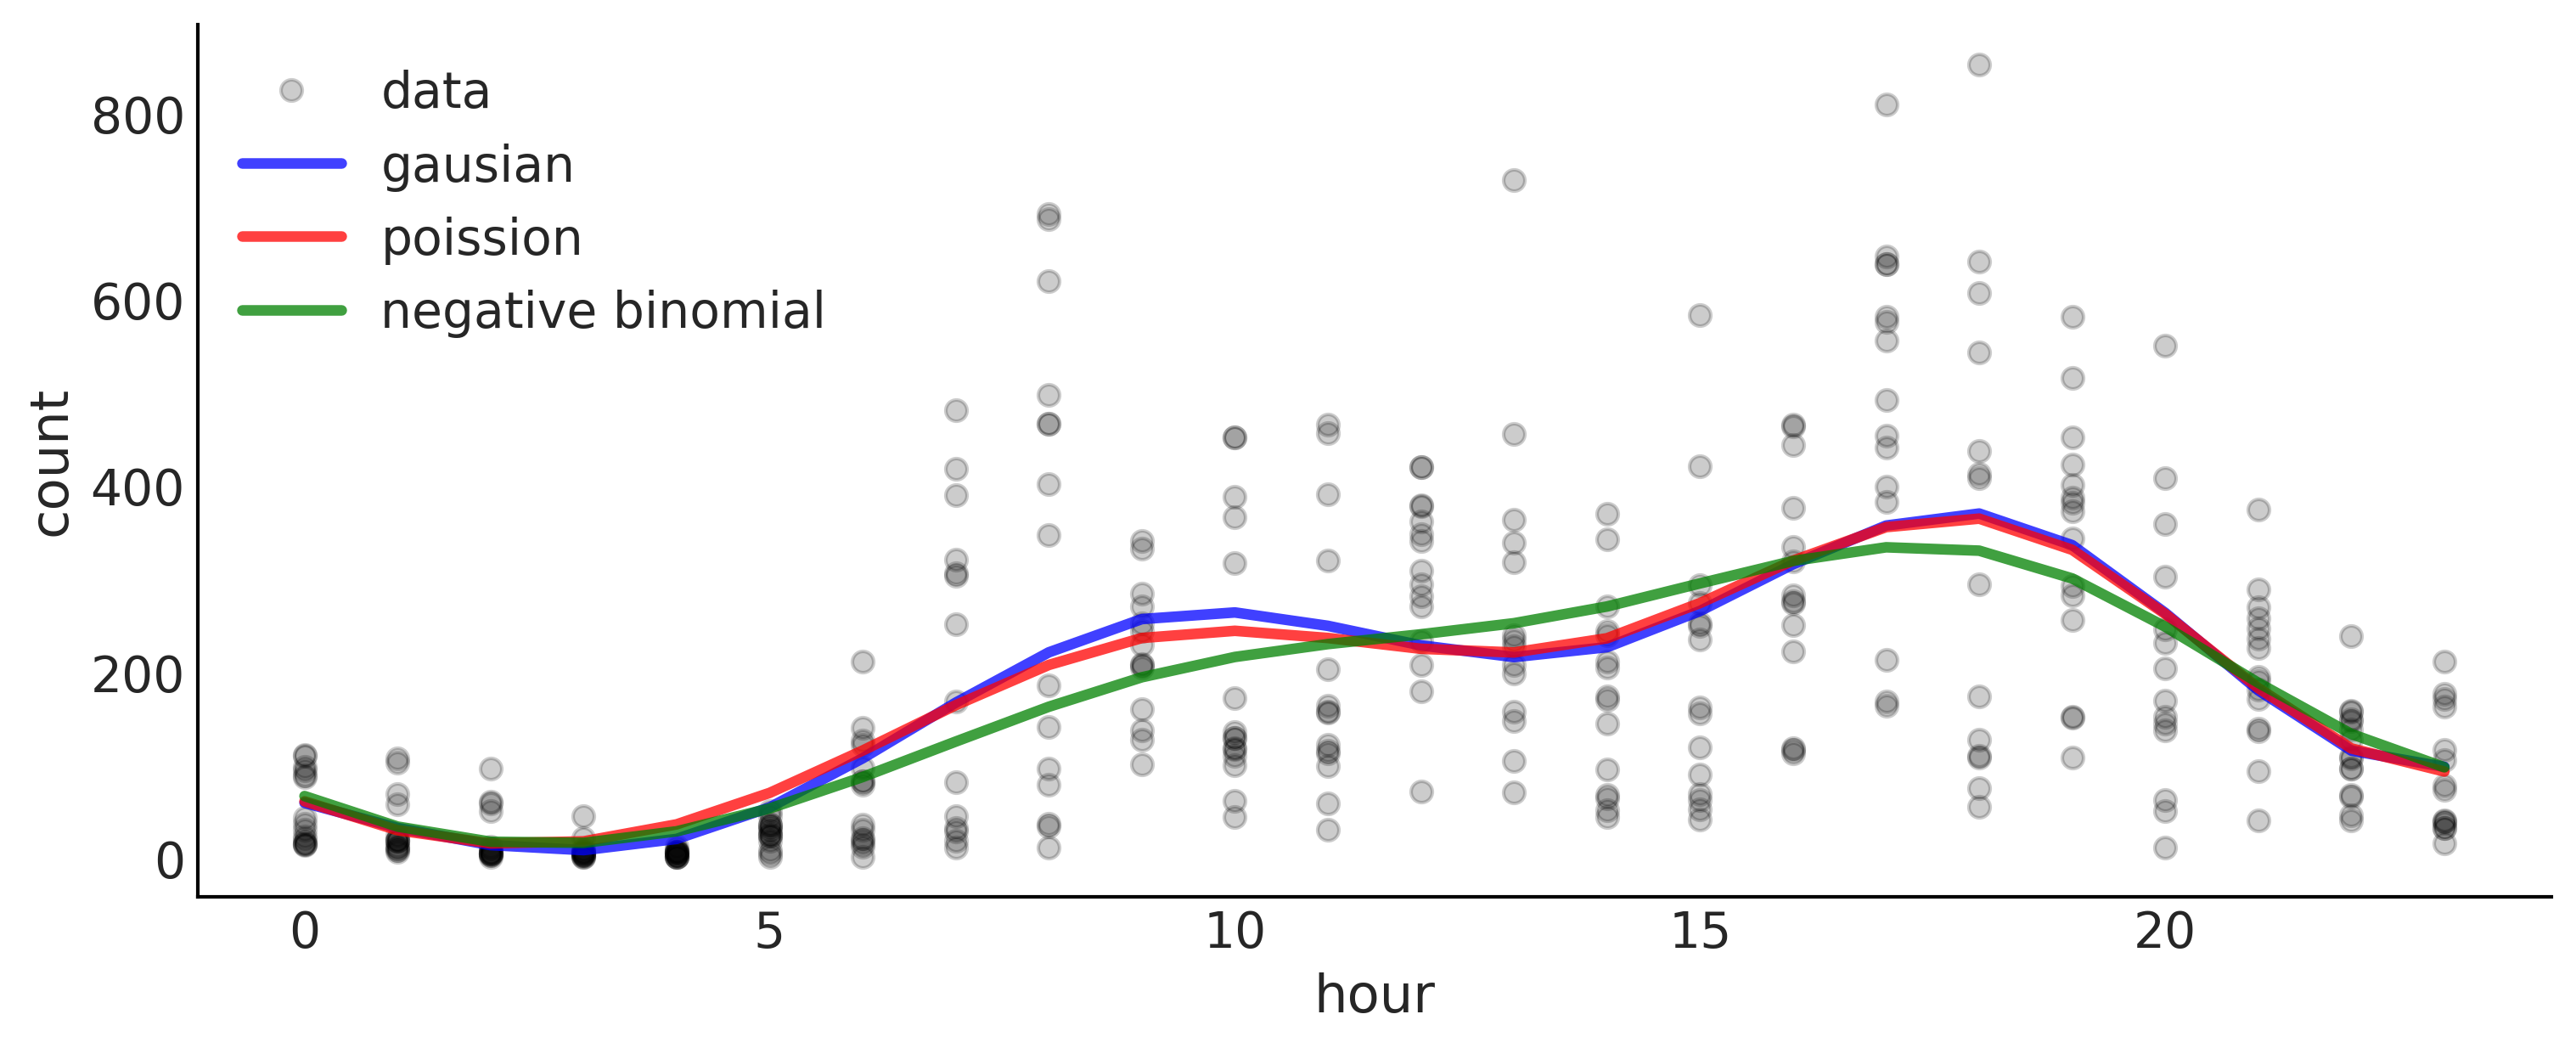

In [278]:
p=idata.posterior.stack(samples=['chain', 'draw'])
pp=idata_p.posterior.stack(samples=['chain', 'draw'])
pn=idata_nb.posterior.stack(samples=['chain', 'draw'])

_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data.hour, data['count'], "ko", alpha=0.2,label='data')
ax.plot(data.hour,p["μ"].mean("samples")*data_cnt_os + data_cnt_om, c='b',lw=3,alpha=0.75,label='gausian')
ax.plot(data.hour,pp["μ"].mean("samples"), c='r',lw=3,alpha=0.75,label='poission')
ax.plot(data.hour,pn["μ"].mean("samples"), c='g',lw=3,alpha=0.75,label='negative binomial')
ax.legend()
ax.set_xlabel("hour")
ax.set_ylabel("count")        

In [279]:
az.compare({"Gaussian":idata, "Poisson":idata_p, "Negative Binomial":idata_nb})

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank           loo       p_loo        d_loo        weight  \
Gaussian              0   -388.768706    8.116057      0.00000  1.000000e+00   
Negative Binomial     1  -2030.490565    6.677154   1641.72186  2.072556e-14   
Poisson               2 -14768.806785  431.513900  14380.03808  0.000000e+00   

                            se         dse  warning loo_scale  
Gaussian             18.211061    0.000000    False       log  
Negative Binomial    23.914431   20.392529    False       log  
Poisson            1009.555982  992.960566     True       log

'\npoisson = az.from_dict(posterior_predictive={"y":ppc_p["c"]}, observed_data={"y":data[\'count\']})\naz.plot_bpv(poisson,kind=\'u_value\', ax=ax[1])\nax[1].set_title(\'Poission\')\n\nnb = az.from_dict(posterior_predictive={"y":ppc_nb["c"]}, observed_data={"y":data[\'count\']})\naz.plot_bpv(nb,kind=\'u_value\', ax=ax[2])\nax[2].set_title(\'Negative Binomial\')\n'

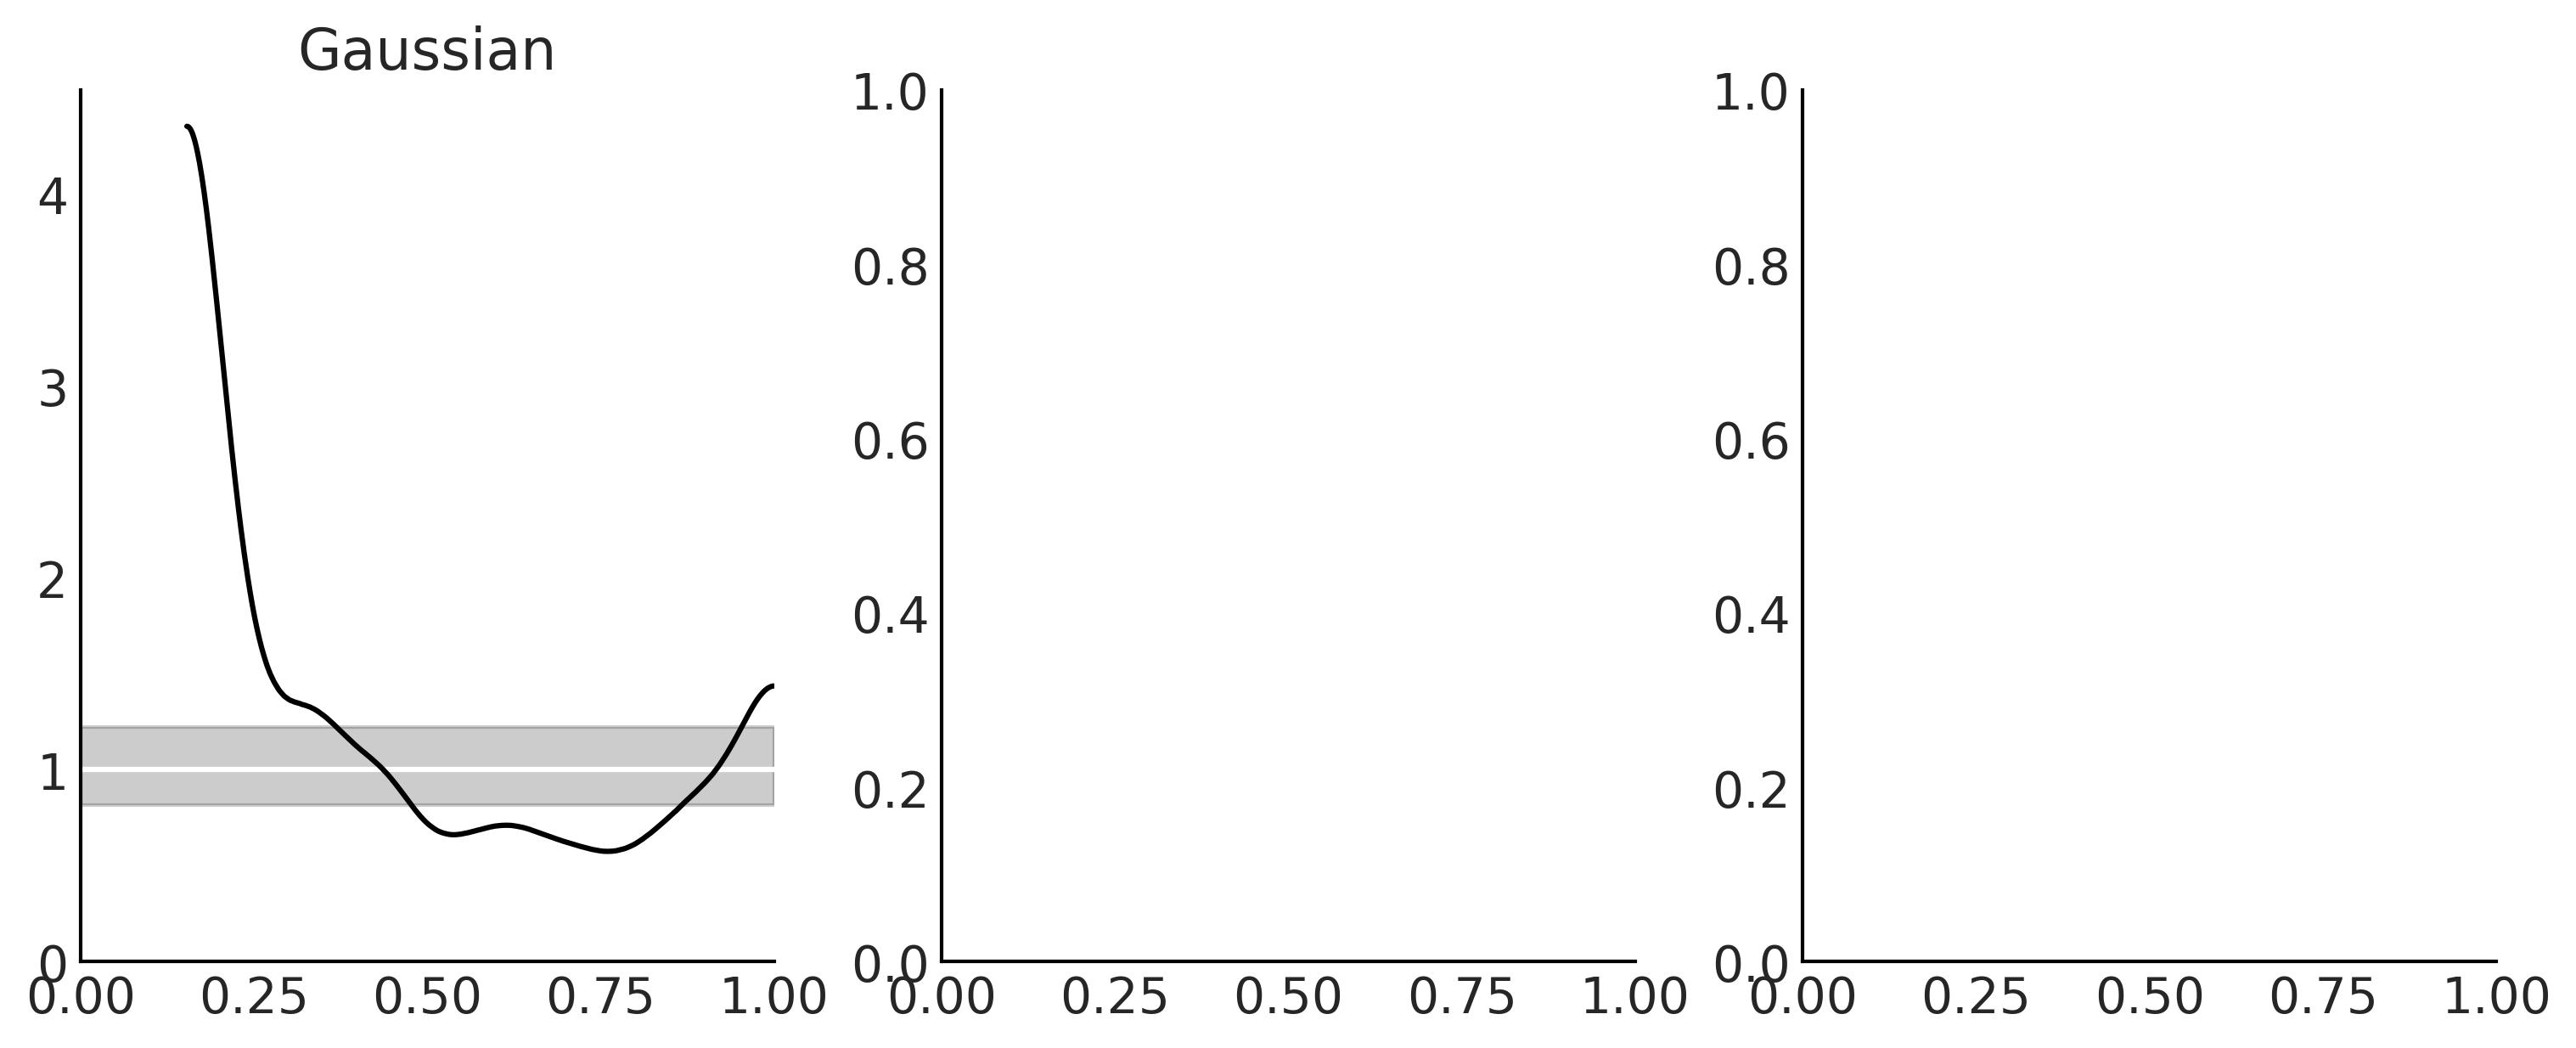

In [359]:
_, ax = plt.subplots(1, 3, figsize=(10, 4))
normal = az.from_dict(posterior_predictive={"y":ppc_n["c"]}, observed_data={"y":data.count_normalized})
az.plot_bpv(normal,kind='u_value', ax=ax[0])
ax[0].set_title('Gaussian')

#Could not get these two cases below to work...something that az.plot_bpv doet not like! [help...]
'''
poisson = az.from_dict(posterior_predictive={"y":ppc_p["c"]}, observed_data={"y":data['count']})
az.plot_bpv(poisson,kind='u_value', ax=ax[1])
ax[1].set_title('Poission')

nb = az.from_dict(posterior_predictive={"y":ppc_nb["c"]}, observed_data={"y":data['count']})
az.plot_bpv(nb,kind='u_value', ax=ax[2])
ax[2].set_title('Negative Binomial')
'''

## 5m15

In [390]:
#Part b)
space = pd.read_csv("../data/space_influenza.csv")[['age','sick']].copy()

with pm.Model() as model_logistic:
    β_0 = pm.Normal("β_0", mu=0, sigma=10)
    β_1 = pm.Normal("β_1", mu=0, sigma=10)
    μ = β_0 + pm.math.dot(space.age, β_1)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    yl = pm.Bernoulli("yl", p=θ, observed=space.sick)
    trace = pm.sample(4000, random_seed=0, chains=3)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    logistic_idata= az.from_pymc3(trace=trace,posterior_predictive=posterior_predictive)

num_knots = 6
knot_list = np.linspace(space.age.min(), space.age.max(), num_knots)[1:-1]
B = dmatrix("bs(cnt,knots=knots,degree=3,include_intercept=True)-1",{"cnt": space.age.values,"knots": knot_list})
with pm.Model() as splines:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    yl = pm.Bernoulli("yl", p=θ, observed=space.sick)
    trace_n= pm.sample(4000,chains=3)
    ppc_n = pm.sample_posterior_predictive(trace)
    spline_idata= az.from_pymc3(trace=trace_n,posterior_predictive=ppc_n)
    

/tmp/ipykernel_2715/4209848809.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(4000, random_seed=0, chains=3)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [β_1, β_0]


Sampling 3 chains for 1_000 tune and 4_000 draw iterations (3_000 + 12_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


/tmp/ipykernel_2715/4209848809.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_n= pm.sample(4000,chains=3)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [β, τ]


Sampling 3 chains for 1_000 tune and 4_000 draw iterations (3_000 + 12_000 draws total) took 8 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


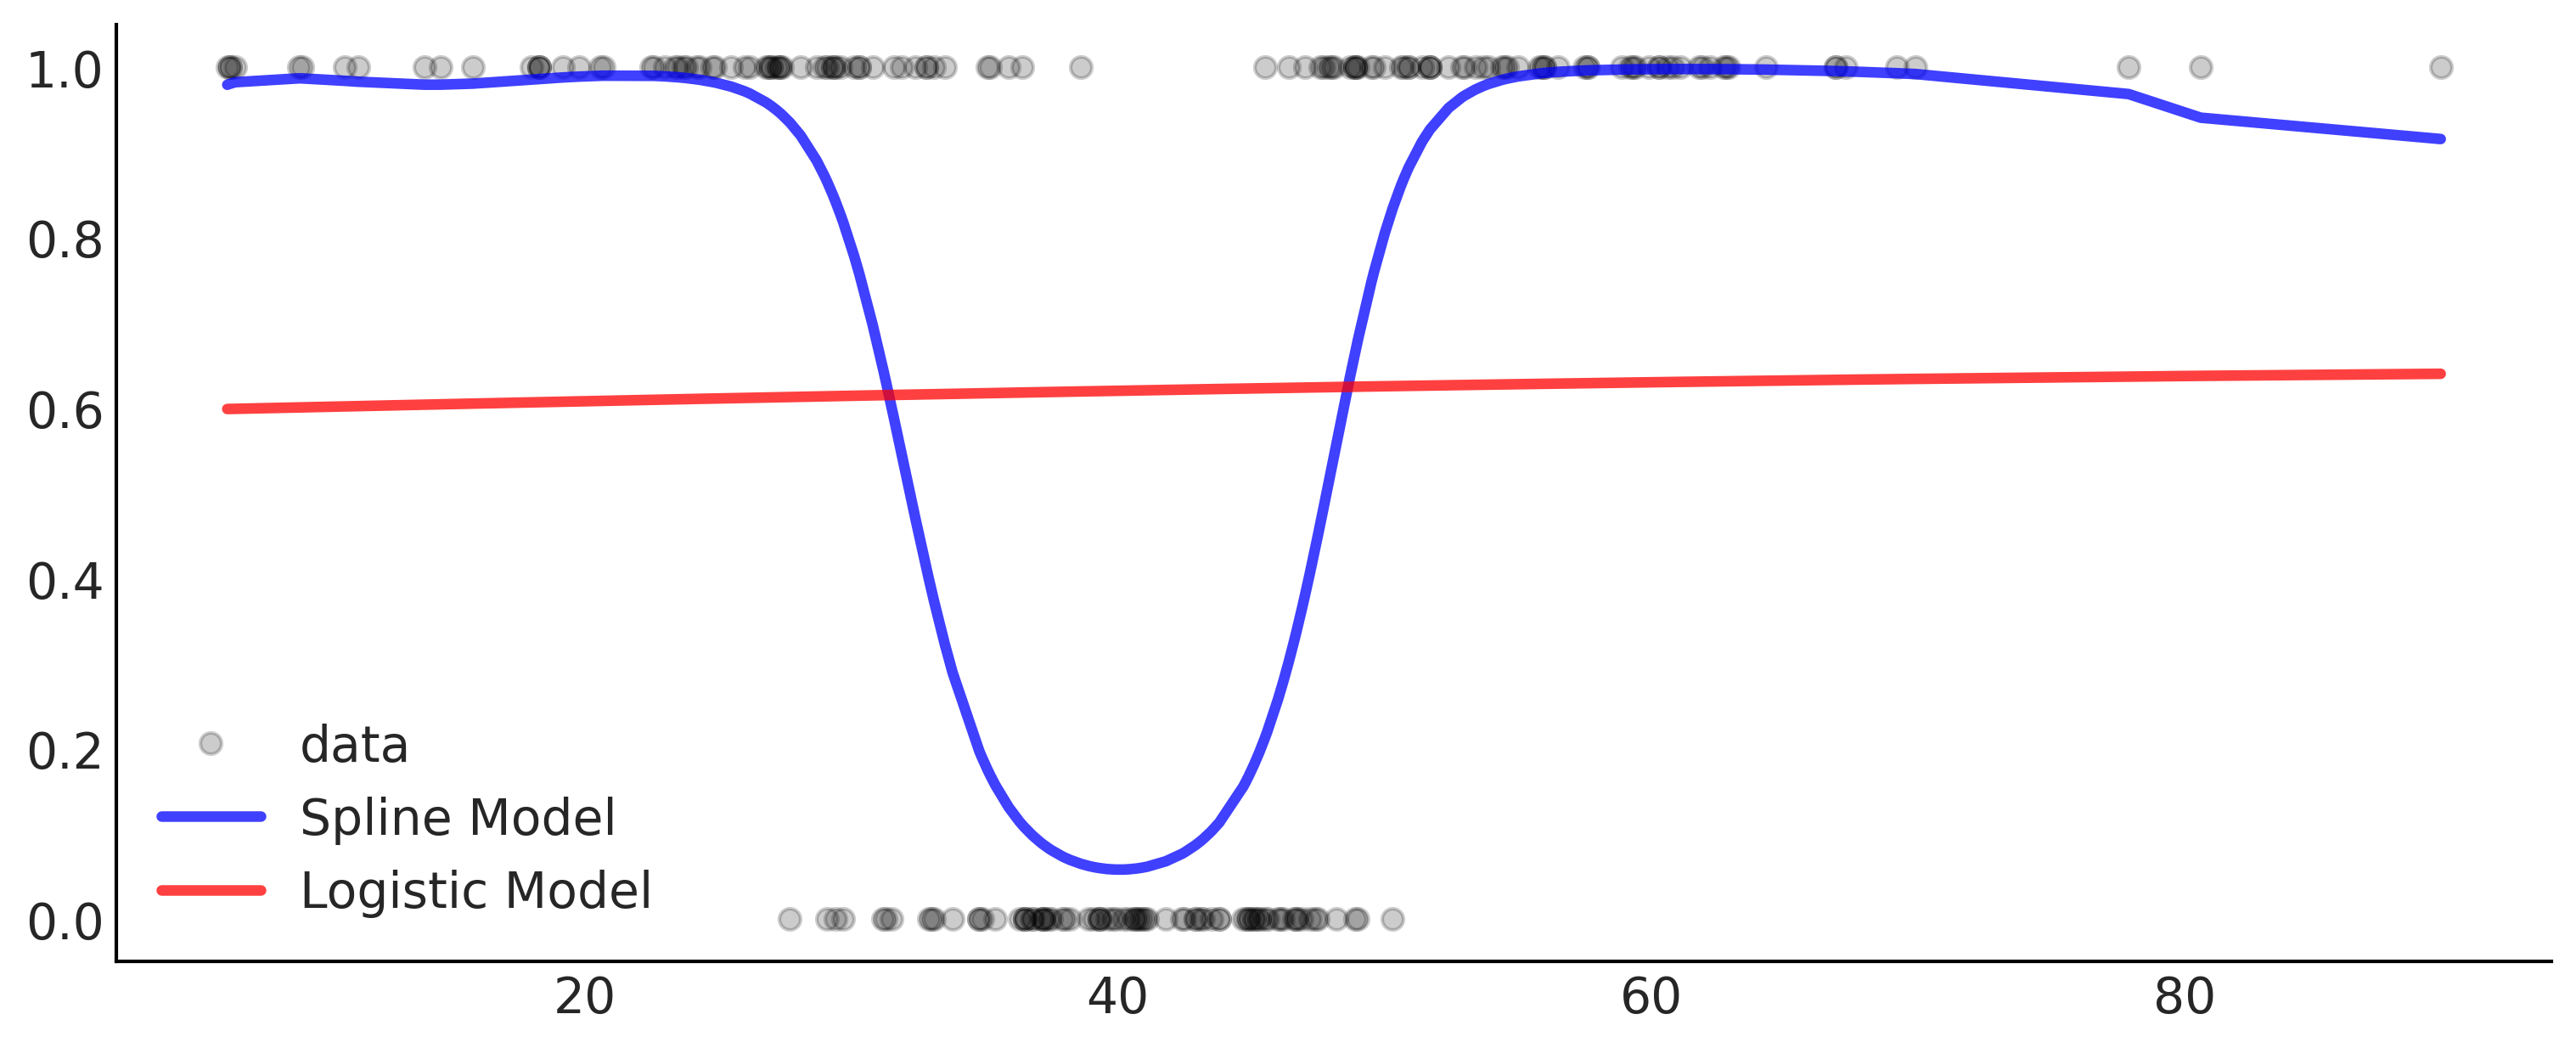

In [391]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(space.age, space.sick, "ko", alpha=0.2,label='data')
pg=spline_idata.posterior.stack(samples=['chain', 'draw'])
pl=logistic_idata.posterior.stack(samples=['chain', 'draw'])
ax.plot(space.age,pg["θ"].mean("samples"), c='b',lw=3,alpha=0.75,label='Spline Model')
ax.plot(space.age,pl["θ"].mean("samples"), c='r',lw=3,alpha=0.75,label='Logistic Model')
ax.legend()

In [392]:
az.compare({"Logistic":logistic_idata, "Spline":spline_idata})

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank         loo     p_loo      d_loo  weight        se       dse  \
Spline       0  -62.973873  3.600184   0.000000     1.0  7.647378  0.000000   
Logistic     1 -143.378606  1.755485  80.404733     0.0  3.485756  8.053759   

          warning loo_scale  
Spline       True       log  
Logistic    False       log

## 5M16

In [393]:
#Repeat processing steps from the chapter above
bikes = pd.read_csv("../data/bikes_hour.csv")
bikes.sort_values(by="hour", inplace=True)
bikes_cnt_om = bikes["count"].mean()
bikes_cnt_os = bikes["count"].std()
bikes["count_normalized"] = (bikes["count"] - bikes_cnt_om) / bikes_cnt_os
bikes = bikes[::50]

instant      dteday  season  yr  mnth  hour  holiday  weekday  \
0           1  2011-01-01       1   0     1     0        0        6   
4610     4611  2011-07-16       3   0     7     0        0        6   
7209     7210  2011-11-02       4   0    11     0        0        3   
6610     6611  2011-10-08       4   0    10     0        0        6   
2354     2355  2011-04-13       2   0     4     0        0        3   

      workingday  weathersit  temperature   atemp  humidity  windspeed  \
0              0           1         0.24  0.2879      0.81     0.0000   
4610           0           1         0.62  0.6061      0.65     0.1940   
7209           1           1         0.32  0.3485      0.87     0.0000   
6610           0           1         0.48  0.4697      0.72     0.0000   
2354           1           2         0.40  0.4091      1.00     0.2985   

      casual  registered  count  count_normalized  
0          3          13     16         -0.956312  
4610      42          68    110         -0.438084  
7209       0          19     19         -0.939773  
6610      17          72     89         -0.553859  
2354       3          12     15         -0.961825

In [451]:
num_knots = 6
knot_list_hour = np.linspace(bikes.hour.min(), bikes.hour.max(), num_knots)[1:-1]
B_hour = dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",{"cnt": bikes.hour.values,
                                                                          "knots": knot_list_hour})
num_knots2 = 2
knot_list_temp = np.linspace(bikes.temperature.min(), bikes.temperature.max(), num_knots2)[1:-1]
B_temp = dmatrix("bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",{"cnt": bikes.temperature.values,
                                                                          "knots": knot_list_temp})

with pm.Model() as m1:
    τh = pm.HalfCauchy('τh', 1) 
    βh = pm.Normal("βh", mu=0, sd=τh, shape=B_hour.shape[1])
    τt = pm.HalfCauchy('τt', 0.1) 
    βt = pm.Normal("βt", mu=0, sd=τt, shape=B_temp.shape[1])
    
    μh = pm.Deterministic("μh", pm.math.dot(np.asfortranarray(B_hour), βh))    
    μt = pm.Deterministic("μt", pm.math.dot(np.asfortranarray(B_temp), βt))    
    μ = pm.Deterministic("μ",μh + μt )
    
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=bikes["count_normalized"].values)
    idata1 = pm.sample(1000, return_inferencedata=True)
    ppc1 = pm.sample_posterior_predictive(idata1) 


with pm.Model() as m2:
    τ = pm.HalfCauchy('τ', 1) 
    β = pm.Normal("β", mu=0, sd=τ, shape=B_hour.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B_hour), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=bikes["count_normalized"].values)
    idata2 = pm.sample(1000, return_inferencedata=True)
    ppc2 = pm.sample_posterior_predictive(idata2) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, βt, τt, βh, τh]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [452]:
az.summary(idata1,var_names=["βt"], kind="diagnostics")

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
βt[0]      0.012    0.008    1096.0    1691.0    1.0
βt[1]      0.013    0.010    1265.0    1731.0    1.0
βt[2]      0.013    0.009    1186.0    1603.0    1.0
βt[3]      0.012    0.008    1058.0    1451.0    1.0

Text(0, 0.5, 'count')

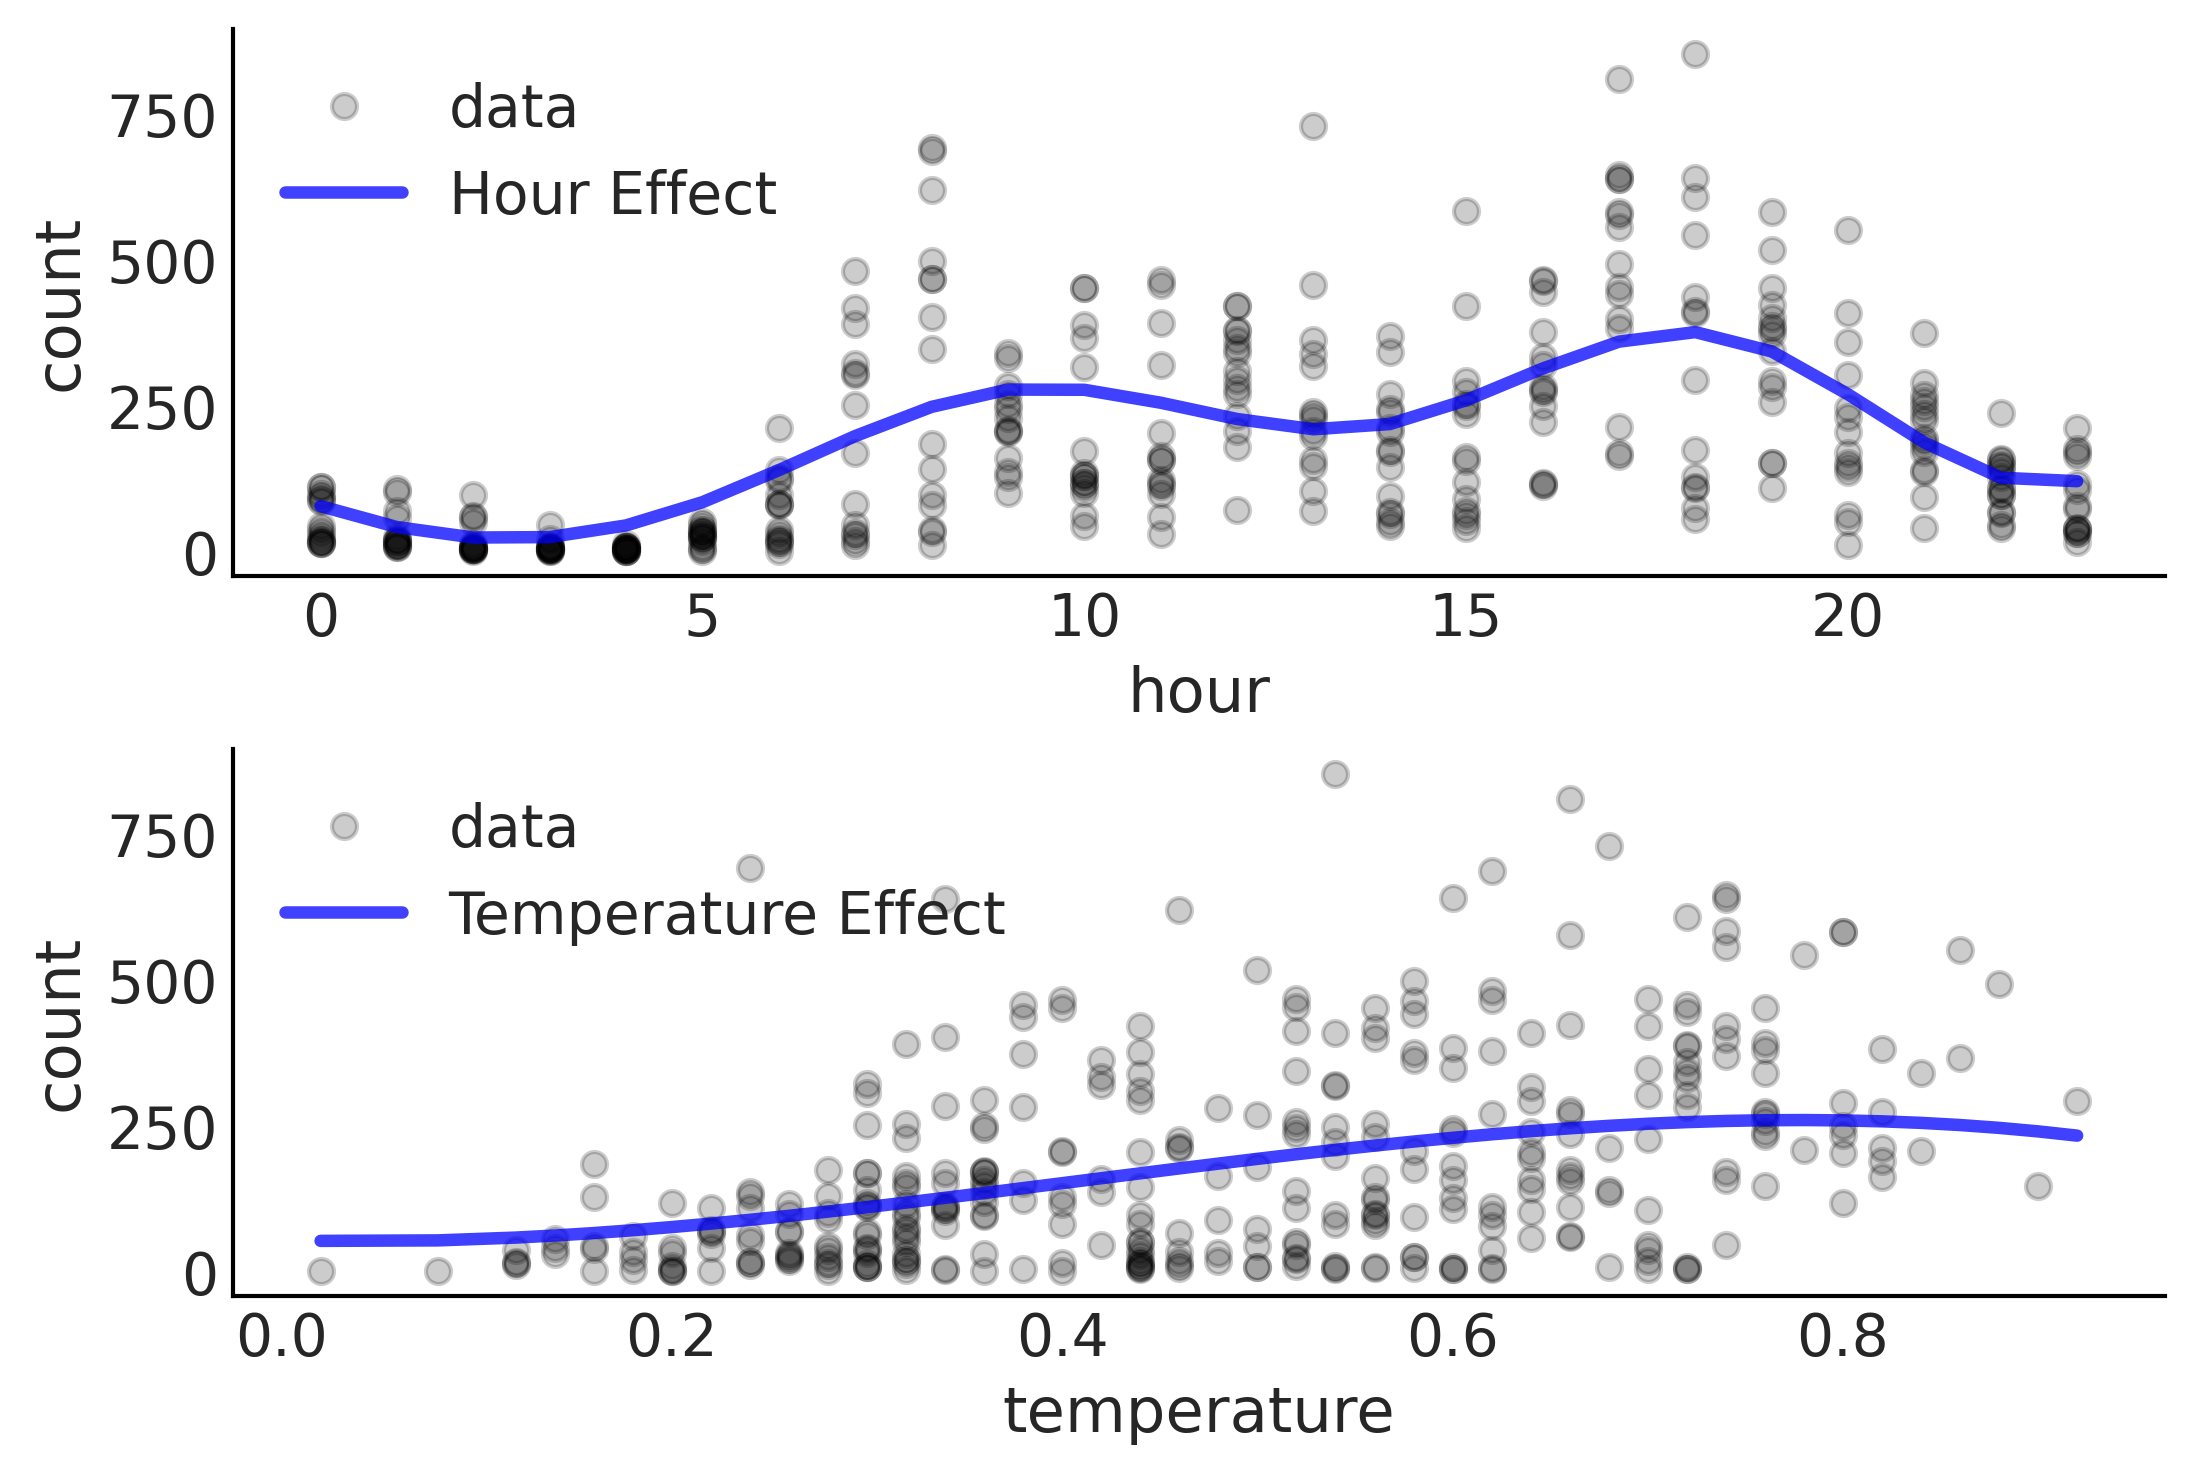

In [453]:
p1 = idata1.posterior.stack(samples=['chain', 'draw'])

_, ax = plt.subplots(2, 1)
ax[0].plot(bikes.hour, bikes['count'], "ko", alpha=0.2,label='data')
ax[0].plot(bikes.hour,p1["μh"].mean("samples")*bikes_cnt_os + bikes_cnt_om, c='b',lw=3,alpha=0.75,
           label='Hour Effect')
ax[0].legend();ax[0].set_xlabel("hour");ax[0].set_ylabel("count")    

bikes2=bikes.copy()
bikes2['μt']=p1["μt"].mean("samples")*bikes_cnt_os + bikes_cnt_om
bikes2=bikes2.sort_values(by='temperature')
ax[1].plot(bikes2.temperature, bikes2['count'], "ko", alpha=0.2,label='data')
ax[1].plot(bikes2.temperature,bikes2["μt"], c='b',lw=3,alpha=0.75,label='Temperature Effect')
ax[1].legend();ax[1].set_xlabel("temperature");ax[1].set_ylabel("count") 


In [454]:
az.compare({"Hour & Temperature":idata1, "Hour Only":idata2})

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank         loo      p_loo      d_loo    weight  \
Hour & Temperature     0 -341.651495  10.805304   0.000000  0.957066   
Hour Only              1 -388.652389   8.009142  47.000893  0.042934   

                           se       dse  warning loo_scale  
Hour & Temperature  21.293088  0.000000    False       log  
Hour Only           18.185508  9.421323    False       log